In [ ]:
import requests
import pandas as pd
from datetime import datetime
from google.colab import drive
import zipfile
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

drive.mount('/content/drive')

Mounted at /content/drive


# DEEL 01: EXTERNE DATA


## 1.1 Schoolvakanties
VIA RIJKSOVERHEID -->  https://www.rijksoverheid.nl/opendata/schoolvakanties

In [ ]:
# -----------------API-------------------
# URL van de Rijksoverheid API voor schoolvakanties
API_URL = "https://opendata.rijksoverheid.nl/v1/infotypes/schoolholidays?output=json"

# Verzoek versturen naar de API
reactie = requests.get(API_URL)

# Controleer of de API goed werkt
if reactie.status_code == 200:
    gegevens = reactie.json()

    # Lijst om vakantiegegevens op te slaan
    vakanties = []

    # Bepaal het huidige jaar en stel de gewenste jaren in tot het verst beschikbare schooljaar
    huidig_jaar = datetime.now().year
    beschikbare_jaren = range(2020, huidig_jaar + 1)  # Pak alles vanaf 2020 tot 1 jaar in de toekomst
    gewenste_jaren = [str(jaar) for jaar in beschikbare_jaren]

    # Doorloop alle vakantieperiodes in de API-reactie
    for item in gegevens:
        if "content" in item:
            for vakantie in item["content"]:
                schooljaar = vakantie.get("schoolyear", "").strip()

                # Controleer of het schooljaar in de gewenste periode valt
                if any(jaar in schooljaar for jaar in gewenste_jaren):
                    for regio in vakantie.get("vacations", []):
                        for regio_info in regio.get("regions", []):  # Doorloop alle regio's per vakantie
                            vakanties.append({
                                "id": item.get("id", ""),
                                "type": item.get("type", ""),
                                "canonical": item.get("canonical", ""),
                                "title": item.get("title", "").strip(),
                                "schooljaar": schooljaar,
                                "vakantietype": regio.get("type", "").strip(),
                                "regio": regio_info.get("region", "").strip(),
                                "startdatum": regio_info.get("startdate", "").strip(),
                                "einddatum": regio_info.get("enddate", "").strip(),
                                "notitie": item.get("notice", "").strip(),
                                "verantwoordelijke": ", ".join(item.get("authorities", [])),
                                "makers": ", ".join(item.get("creators", [])),
                                "licentie": item.get("license", ""),
                                "rechthebbenden": ", ".join(item.get("rightsholders", [])),
                                "taal": item.get("language", ""),
                                "locatie": item.get("location", ""),
                                "laatst gewijzigd": item.get("lastmodified", ""),
                                "verplicht": "Ja" if regio.get("compulsorydates") == "true" else "Nee"
                            })

    # Zet de gegevens om naar een Pandas DataFrame met de naam school_vak
    school_vak = pd.DataFrame(vakanties)

    # Sorteer vakanties op schooljaar en startdatum
    school_vak["startdatum"] = pd.to_datetime(school_vak["startdatum"], errors="coerce")
    school_vak["einddatum"] = pd.to_datetime(school_vak["einddatum"], errors="coerce")
    school_vak = school_vak.sort_values(by=["schooljaar", "startdatum"])

# ----------------- Opschonen -------------------
# Filter alleen vakanties van regio 'zuid' en maak een kopie
school_vak = school_vak[school_vak["regio"].str.lower() == "zuid"].copy()

# Verwijder onnodige spaties uit kolomnamen
school_vak.columns = school_vak.columns.str.strip()

# Converteer start- en einddatum naar datetime-formaat
school_vak["startdatum"] = pd.to_datetime(school_vak["startdatum"], errors="coerce")
school_vak["einddatum"] = pd.to_datetime(school_vak["einddatum"], errors="coerce")

# Nieuwe lijst maken voor uitgebreide data
expanded_rows = []

# Itereer over elke rij en genereer een rij per dag
for _, row in school_vak.iterrows():
    if pd.notna(row["startdatum"]) and pd.notna(row["einddatum"]):  # Controleer of er geen NaT-waarden zijn
        datum_range = pd.date_range(start=row["startdatum"], end=row["einddatum"])
        for datum in datum_range:
            expanded_rows.append({
                "datum": datum,
                "vakantietype": row["vakantietype"],
                "verplicht": row.get("verplicht", None),  # Gebruik .get() om KeyError te voorkomen
            })

# Zet de lijst om naar een DataFrame
vakanties_zuid = pd.DataFrame(expanded_rows)

#verplicht_bin waar 1 = Ja en 0 is nee
vakanties_zuid["verplicht_bin"] = vakanties_zuid["verplicht"].map({"Ja": 1, "Nee": 0})
vakanties_zuid = vakanties_zuid.drop(columns=["verplicht"])

# Sorteer op datum
vakanties_zuid = vakanties_zuid.sort_values(by="datum")
vakanties_zuid = vakanties_zuid.rename(columns={"datum": "datetime"})
vakanties_zuid["datetime"] = vakanties_zuid["datetime"].dt.tz_convert(None)


# ----------------- Per uur -------------------

# Nieuwe lijst maken voor uitgebreide data met uurlijkse gegevens
expanded_rows_uur = []

# Itereer over elke rij en genereer een rij per uur
for _, row in vakanties_zuid.iterrows():
    current_datetime = row["datetime"]
    for hour in range(24):
        new_datetime = current_datetime.replace(hour=hour, minute=0, second=0, microsecond=0)
        expanded_rows_uur.append({
            "datetime": new_datetime,
            "vakantietype": row["vakantietype"],
            "verplicht_bin": row["verplicht_bin"]
        })

# Zet de lijst om naar een DataFrame
vakanties_zuid_uur = pd.DataFrame(expanded_rows_uur)

# Sorteer op datum en tijd
vakanties_zuid_uur = vakanties_zuid_uur.sort_values(by="datetime")

# Laatste 60 rijen bekijken
vakanties_zuid_uur


,datetime,vakantietype,verplicht_bin
0,2019-10-12 00:00:00,Herfstvakantie,0
1,2019-10-12 01:00:00,Herfstvakantie,0
2,2019-10-12 02:00:00,Herfstvakantie,0
3,2019-10-12 03:00:00,Herfstvakantie,0
4,2019-10-12 04:00:00,Herfstvakantie,0
...,...,...,...
10075,2026-08-22 19:00:00,Zomervakantie,1
10076,2026-08-22 20:00:00,Zomervakantie,1
10077,2026-08-22 21:00:00,Zomervakantie,1
10078,2026-08-22 22:00:00,Zomervakantie,1


## 1.2 Weersvoorspellingen

### API via KNMI - Historisch
**WEERDATA VOLKEL 2021-2023 tot gister!**
BRON: KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI)

**Opmerking:** door stationsverplaatsingen en veranderingen in waarneemmethodieken zijn deze tijdreeksen van uurwaarden mogelijk inhomogeen! Dat betekent dat deze reeks van gemeten waarden niet geschikt is voor trendanalyse. Voor studies naar klimaatverandering verwijzen we naar de gehomogeniseerde dagreeksen [KNMI daggegevens](http://www.knmi.nl/nederland-nu/klimatologie/daggegevens) of de [Centraal Nederland Temperatuur (CNT)](http://www.knmi.nl/kennis-en-datacentrum/achtergrond/centraal-nederland-temperatuur-cnt).


- **datum (YYYYMMDD)**: datum (YYYY=jaar, MM=maand, DD=dag)  
- **temp_1.5m (T)**: temperatuur in 0.1 graden Celsius op 1.50 m hoogte tijdens de waarneming  
- **zonneschijn (SQ)**: duur van de zonneschijn (in 0.1 uren) per uurvak, berekend uit globale straling (-1 voor </0.05 uur)   
- **neerslag_mm (RH)**: uursom van de neerslag (in 0.1 mm) (-1 voor </0.05 mm)  
- **bewolking (N)**: bedekkingsgraad van de bovenlucht in achtsten, tijdens de waarneming (9=bovenlucht onzichtbaar)  
- **mist (M)**: 0=niet voorgekomen, 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming  
- **regen (R)**: 0=niet voorgekomen, 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming  
- **sneeuw (S)**: 0=niet voorgekomen, 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming  
- **onweer (O)**: 0=niet voorgekomen, 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming  
- **ijsvorming (Y)**: 0=niet voorgekomen, 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming  

**Weggelaten Kolommen:**
- **tijd (HH)**: tijd (uur), 12 UT = 13 MET, 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT  
- **windrichting (DD)**: windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord, 90=oost, 180=zuid, 270=west, 0=windstil, 990=veranderlijk)  
- **gem_windsnelheid (FH)**: gemiddelde windsnelheid in 0.1 m/s over het afgelopen uur  
- **windsnelheid_10m (FF)**: gemiddelde windsnelheid in 0.1 m/s over de laatste 10 minuten van het afgelopen uur  
- **max_windstoot (FX)**: hoogste windstoot (3 seconden gemiddelde windsnelheid; in 0.1 m/s) in het afgelopen uur  
- **min_temp_10cm (T10N)**: minimumtemperatuur in 0.1 graden Celsius op 10 cm hoogte in de afgelopen 6 uur  
- **dauwpunt (TD)**: dauwpuntstemperatuur in 0.1 graden Celsius op 1.50 m hoogte tijdens de waarneming  
- **global_straling (Q)**: globale straling (in J/cm²) per uurvak  
- **neerslagduur (DR)**: duur van de neerslag (in 0.1 uur) per uurvak    
- **luchtdruk (P)**: luchtdruk (in 0.1 hPa) herleid naar zeeniveau, tijdens de waarneming  
- **zicht (VV)**: horizontaal zicht tijdens de waarneming (waarden tussen 0 en 89, waarbij 0=minder dan 100m en 89=meer dan 70km)  
- **luchtvochtigheid (U)**: relatieve luchtvochtigheid (in procenten) op 1.50 m hoogte tijdens de waarneming  
- **weercode (WW)**: weercode (00-99), visueel (WW) of automatisch (WaWa) waargenomen, voor het actuele weer of het weer in het afgelopen uur. Zie [weercodes Nederland](https://cdn.knmi.nl/knmi/pdf/bibliotheek/scholierenpdf/weercodes_Nederland.pdf)  
- **weercode_indicator (IX)**: weercode-indicator voor de wijze van waarnemen (1=bemand gebruikmakend van code uit visuele waarnemingen, 4=automatisch en opgenomen, 7=automatisch gebruikmakend van code uit automatische waarnemingen)  

---

*Laatste update: KNMI weerdata 13 maart*



In [ ]:
# -----------------API KNMI-------------------
# Stap 1: Instellingen voor de bestanden en mappen
desktop_pad = "/Users/private/Desktop"
zip_bestand = os.path.join(desktop_pad, "uurgeg_375_2021-2030.zip")
uitpak_map = os.path.join(desktop_pad, "KNMI_weerdata")

if not os.path.exists(desktop_pad):
    os.makedirs(desktop_pad)

# Stap 2: Download het ZIP-bestand
url = "https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_375_2021-2030.zip"

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(zip_bestand, "wb") as bestand:
        for chunk in response.iter_content(chunk_size=1024):
            bestand.write(chunk)
    print(f"ZIP-bestand succesvol gedownload naar: {zip_bestand}")
else:
    print(f"Download mislukt, statuscode: {response.status_code}")
    exit()

# Stap 3: Pak het ZIP-bestand uit
with zipfile.ZipFile(zip_bestand, "r") as zip_ref:
    zip_ref.extractall(uitpak_map)
    print(f"Bestand uitgepakt in: {uitpak_map}")

# Stap 4: Zoek het .txt-bestand in de map
uitgepakt_bestand = None
for bestand in os.listdir(uitpak_map):
    if bestand.endswith(".txt"):
        uitgepakt_bestand = os.path.join(uitpak_map, bestand)
        break

if uitgepakt_bestand:
    print(f"Gevonden weerbestand: {uitgepakt_bestand}")
else:
    print("Geen .txt bestand gevonden na uitpakken!")
    exit()

# Stap 5: Weerdata uitlezen
weerdata_bestand = "/Users/private/Desktop/KNMI_weerdata/uurgeg_375_2021-2030.txt"

# Kolomnamen correct definiëren
kolomnamen = [
    "datum", "tijd", "windrichting", "gem_windsnelheid", "windsnelheid_10m",
    "max_windstoot", "temperatuur", "min_temp_10cm", "dauwpunt", "zonneschijn", "global_straling",
    "neerslagduur", "neerslag_mm", "luchtdruk", "zicht", "bewolking", "luchtvochtigheid",
    "weercode", "weercode_indicator", "mist", "regen", "sneeuw", "onweer", "ijsvorming"
]

# Weerdata inlezen (sla de eerste 66 rijen over, want dat is metadata van KNMI)
weer_KNMI = pd.read_csv(weerdata_bestand, skiprows=66, header=None, names=kolomnamen, sep=",", dtype=str)

# -----------------Opschonen-------------------
# Zet numerieke kolommen om naar correcte types
numerieke_kolommen = [
    "windrichting", "gem_windsnelheid", "windsnelheid_10m", "max_windstoot",
    "temperatuur", "min_temp_10cm", "dauwpunt", "zonneschijn", "global_straling",
    "neerslagduur", "neerslag_mm", "luchtdruk", "zicht", "bewolking",
    "luchtvochtigheid", "weercode", "weercode_indicator", "mist", "regen",
    "sneeuw", "onweer", "ijsvorming"
]

for kolom in numerieke_kolommen:
    weer_KNMI[kolom] = pd.to_numeric(weer_KNMI[kolom], errors="coerce")

# Datum- en tijdkolommen opschonen naar datetime
weer_KNMI["datum"] = weer_KNMI["datum"].astype(str).str.slice(0, 8)  # Extra tijd verwijderen
weer_KNMI["tijd"] = weer_KNMI["tijd"].str.strip().str.zfill(2)  # Spaties verwijderen en aanvullen tot 2 cijfers

# **Tijd 24 corrigeren naar 00 en de datum ophogen**
mask = weer_KNMI["tijd"] == "24"
weer_KNMI.loc[mask, "tijd"] = "00"
weer_KNMI.loc[mask, "datum"] = (pd.to_datetime(weer_KNMI.loc[mask, "datum"], format="%Y%m%d") + pd.Timedelta(days=1)).dt.strftime("%Y%m%d")

# Nieuwe datetime-kolom correct aanmaken
weer_KNMI["datetime"] = pd.to_datetime(weer_KNMI["datum"] + weer_KNMI["tijd"], format="%Y%m%d%H", errors="coerce")

# Temperatuurwaarden omzetten van 0.1°C naar °Cw
weer_KNMI["temperatuur"] = weer_KNMI["temperatuur"] / 10
# Corrigeer neerslag_mm (RH) van 0.1 mm eenheden naar mm
weer_KNMI["neerslag_mm"] = weer_KNMI["neerslag_mm"].replace(-1, 0.025) / 10

# Lijst met kolommen die WEG kunnen, gebaseerd op eerder uitgewerkte analyse
kolommen_verwijderen = [
    "min_temp_10cm",'datum', 'tijd', "dauwpunt", "global_straling",
    "neerslagduur", "luchtdruk", "zicht", "weercode", "weercode_indicator", 'windrichting', 'gem_windsnelheid', 'windsnelheid_10m', 'max_windstoot',
    "dauwpunt", 'luchtvochtigheid'
]

# DataFrame bijwerken door deze kolommen te droppen
weer_KNMI = weer_KNMI.drop(columns=kolommen_verwijderen, errors="ignore")
kolom_volgorde = ["datetime"] + [kol for kol in weer_KNMI.columns if kol != "datetime"]
weer_KNMI = weer_KNMI[kolom_volgorde]
Weather_KNMI_V_uur = weer_KNMI.reset_index(drop=True)

# -----------------Functies weertypes-------------------
# DEFINIIE WEERTYPE
def bepaal_weertype(row):
    """
    Bepaalt het weertype op basis van KNMI-data (Weather_KNMI_V_uur), dit kan in de
    toekomst verder uitgewerkt worden aan de hand van machinelearning (decisontrees)
    """

    # Onweer altijd voorrang geven
    if row["onweer"] > 0:
        if row["regen"] > 0:
            return "matige of zware regen met onweer"
        return "onweer mogelijk"

    # Mist en ijsvorming
    if row["mist"] > 0 and row["ijsvorming"] > 0:
        return "ijzige mist"
    elif row["mist"] > 0:
        return "mist"
    elif row["ijsvorming"] > 0:
        return "kans op gladheid"

    # Sneeuwcondities
    if row["sneeuw"] > 0:
        if row["neerslag_mm"] >= 5:
            return "zware sneeuwval"
        elif row["neerslag_mm"] >= 2:
            return "matige sneeuwval"
        return "lichte sneeuw"

    # Regen
    if row["regen"] > 0:
        if row["neerslag_mm"] >= 5:
            return "matige of zware regen"
        elif row["neerslag_mm"] >= 2:
            return "matige regen"
        elif row["neerslag_mm"] > 0.5:
            return "lichte regen"
        return "lichte motregen"

    # Nachtcontrole op basis van zonneschijn en tijd
    uur = row["datetime"].hour
    is_twijfeluur = 6 <= uur <= 9 or 18 <= uur <= 21
    is_nacht = row["zonneschijn"] == 0 if is_twijfeluur else uur < 6 or uur > 21

    # Bewolking op basis van achtsten
    if row["bewolking"] == 9:
        return "bovenlucht onzichtbaar"
    elif row["bewolking"] >= 7:
        return "zwaar bewolkt"
    elif row["bewolking"] >= 4:
        return "bewolkt"
    elif row["bewolking"] >= 2:
        return "gedeeltelijk bewolkt"
    elif row["bewolking"] == 1:
        return "licht bewolkt"

    # Zonneschijn als er geen bewolking is
    if row["zonneschijn"] > 0:
        return "zonnig" if not is_nacht else "helder"

    return "helder"

def bepaal_weertype2(row):
    """
    Bepaalt het weertype op basis van de beschikbare kolommen.
    Werkt ook als 'onweer_bin', 'mist_bin' of 'ijsvorming_bin' niet in de dataset staan.
    """

    # Onweer (alleen als de kolom bestaat)
    if "onweer_bin" in row and row["onweer_bin"] > 0:
        if "regen_bin" in row and row["regen_bin"] > 0:
            return "matige of zware regen met onweer"
        return "onweer mogelijk"

    # Mist en ijsvorming (alleen als de kolommen bestaan)
    mist = row["mist_bin"] if "mist_bin" in row else 0
    ijsvorming = row["ijsvorming_bin"] if "ijsvorming_bin" in row else 0

    if mist > 0 and ijsvorming > 0:
        return "ijzige mist"
    elif mist > 0:
        return "mist"
    elif ijsvorming > 0:
        return "kans op gladheid"

    # Sneeuwcondities
    if row["sneeuw_bin"] > 0:
        if row["neerslag_mm"] >= 5:
            return "zware sneeuwval"
        elif row["neerslag_mm"] >= 2:
            return "matige sneeuwval"
        return "lichte sneeuw"

    # Regen
    if "regen_bin" in row and row["regen_bin"] > 0:
        if row["neerslag_mm"] >= 5:
            return "matige of zware regen"
        elif row["neerslag_mm"] >= 2:
            return "matige regen"
        elif row["neerslag_mm"] > 0.5:
            return "lichte regen"
        return "lichte motregen"

    # Bewolking op basis van percentages
    if row["bewolking_%"] == 100:
        return "bovenlucht onzichtbaar"
    elif row["bewolking_%"] >= 87.5:
        return "zwaar bewolkt"
    elif row["bewolking_%"] >= 50:
        return "bewolkt"
    elif row["bewolking_%"] >= 25:
        return "gedeeltelijk bewolkt"
    elif row["bewolking_%"] > 0:
        return "licht bewolkt"

    return "helder"


# -----------------Weertypes toepassen-------------------
# Pas de functie toe op de dataset Weather_KNMI_V_uur
Weather_KNMI_V_uur["weertype"] = Weather_KNMI_V_uur.apply(bepaal_weertype, axis=1)
Weather_KNMI_V_uur["weertype"] = Weather_KNMI_V_uur["weertype"].str.lower().str.strip()

#Bewolking omzetten percentages
Weather_KNMI_V_uur["bewolking"] = round((Weather_KNMI_V_uur["bewolking"] / 8) * 100)

#Maand toevoegen
Weather_KNMI_V_uur['maand_nr'] = Weather_KNMI_V_uur['datetime'].dt.month

#Rename kolommen regen en sneeuw naar regen_bin en sneeuw_bin en maak het int type
Weather_KNMI_V_uur = Weather_KNMI_V_uur.rename(columns={"regen": "regen_bin", "sneeuw": "sneeuw_bin", "bewolking": "bewolking_%", "mist": "mist_bin", "ijsvorming": "ijsvorming_bin", "onweer": "onweer_bin"})
Weather_KNMI_V_uur[["regen_bin", "sneeuw_bin", "mist_bin", "ijsvorming_bin","onweer_bin"]] = Weather_KNMI_V_uur[["regen_bin", "sneeuw_bin", "mist_bin", "ijsvorming_bin","onweer_bin" ]].fillna(0)
Weather_KNMI_V_uur["regen_bin"] = Weather_KNMI_V_uur["regen_bin"].astype(int)
Weather_KNMI_V_uur["sneeuw_bin"] = Weather_KNMI_V_uur["sneeuw_bin"].astype(int)
Weather_KNMI_V_uur["mist_bin"] = Weather_KNMI_V_uur["mist_bin"].astype(int)
Weather_KNMI_V_uur["ijsvorming_bin"] = Weather_KNMI_V_uur["ijsvorming_bin"].astype(int)
Weather_KNMI_V_uur["onweer_bin"] = Weather_KNMI_V_uur["onweer_bin"].astype(int)

Weather_KNMI_V_uur

ZIP-bestand succesvol gedownload naar: /Users/private/Desktop/uurgeg_375_2021-2030.zip
Bestand uitgepakt in: /Users/private/Desktop/KNMI_weerdata
Gevonden weerbestand: /Users/private/Desktop/KNMI_weerdata/uurgeg_375_2021-2030.txt


,datetime,temperatuur,zonneschijn,neerslag_mm,bewolking_%,mist_bin,regen_bin,sneeuw_bin,onweer_bin,ijsvorming_bin,weertype,maand_nr
0,2021-01-02 10:00:00,2.4,0,0.0000,100.0,0,0,0,0,0,zwaar bewolkt,1
1,2021-01-02 11:00:00,3.1,0,0.0025,100.0,0,1,0,0,0,lichte motregen,1
2,2021-01-02 12:00:00,3.4,0,0.0025,100.0,0,1,0,0,0,lichte motregen,1
3,2021-01-02 13:00:00,3.4,0,0.0000,100.0,0,0,0,0,0,zwaar bewolkt,1
4,2021-01-02 14:00:00,3.6,0,0.0000,100.0,0,0,0,0,0,zwaar bewolkt,1
...,...,...,...,...,...,...,...,...,...,...,...,...
37330,2025-04-06 20:00:00,5.4,0,0.0000,0.0,0,0,0,0,0,helder,4
37331,2025-04-06 21:00:00,5.9,0,0.0000,0.0,0,0,0,0,0,helder,4
37332,2025-04-06 22:00:00,5.2,0,0.0000,0.0,0,0,0,0,0,helder,4
37333,2025-04-06 23:00:00,3.5,0,0.0000,0.0,0,0,0,0,0,helder,4


### API via  weatherAPI - forecast

**API VIA WEATHER API**
https://www.weatherapi.com/my/analytics.aspx
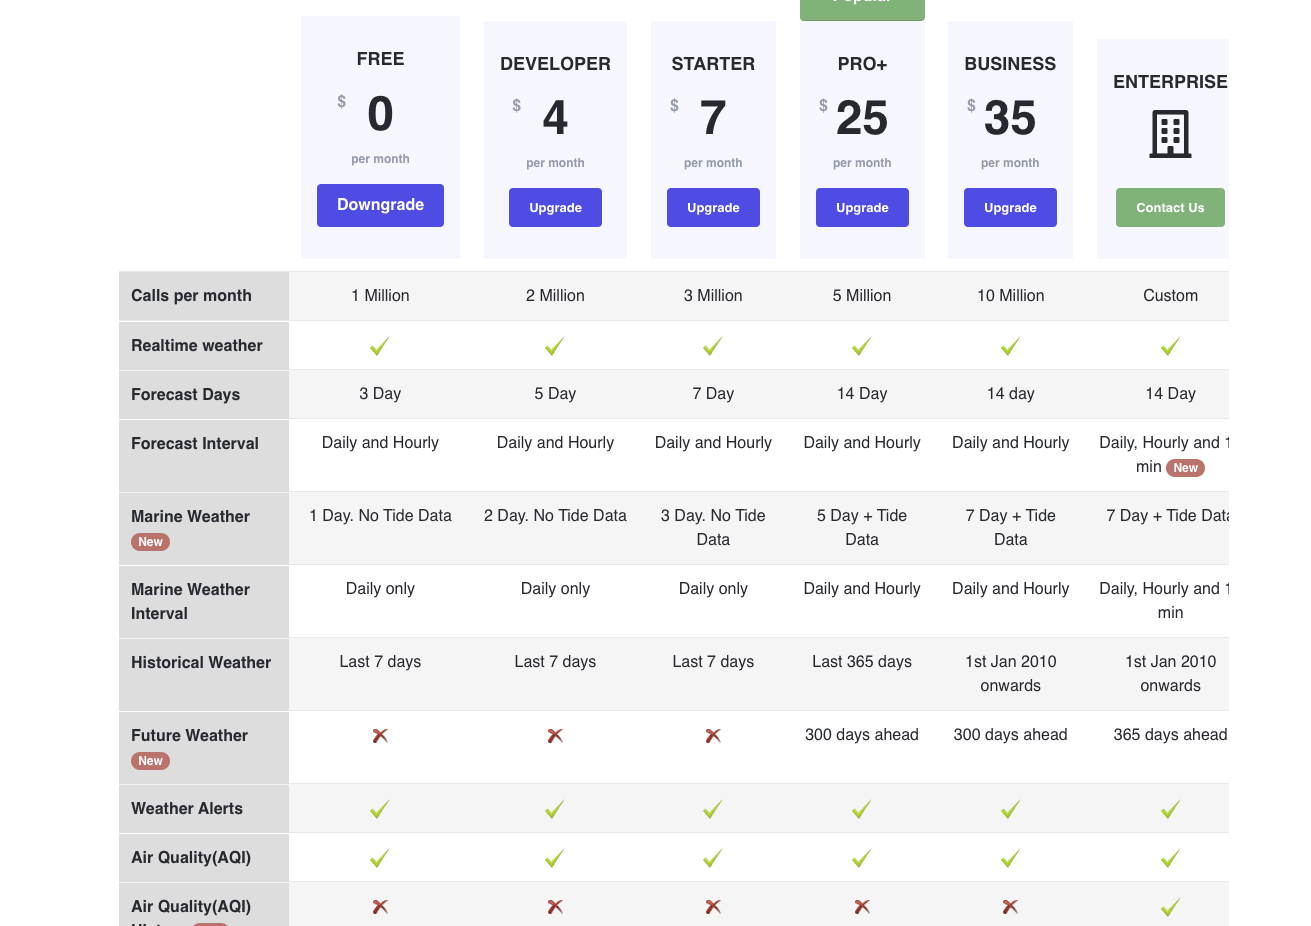


In [ ]:
# -----------------API forecast-------------------
API_KEY = "0dde3f6622464f39ba4151112251403"
locatie = "Volkel"
dagen_vooruit = 4

url = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={locatie}&days={dagen_vooruit}&aqi=no&alerts=no"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()

    voorspellingen = []
    for dag in data["forecast"]["forecastday"]:
        for uur in dag["hour"]:
            voorspellingen.append({
                "datumtijd": uur["time"],
                "temperatuur": uur["temp_c"],
                "bewolking_%": uur["cloud"],
                "neerslag_mm": uur["precip_mm"],
                "sneeuw_mm": uur["snow_cm"],
                "regen_bin":uur ['will_it_rain'],
                "sneeuw_bin":uur ['will_it_snow'],
                "weertype": uur["condition"]["text"],

            })

    Weather_API_T_uur = pd.DataFrame(voorspellingen)

# -----------------Weertypes aanpassen -------------------
# Vertaal de weertypes van Engels naar Nederlands
weertype_vertaling = {
    'cloudy': 'bewolkt',
    'overcast': 'zwaar bewolkt',
    'patchy rain nearby': 'plaatselijke regen mogelijk',
    'light drizzle': 'lichte motregen',
    'light rain': 'lichte regen',
    'moderate rain': 'matige regen',
    'light rain shower': 'lichte regenbui',
    'partly cloudy': 'gedeeltelijk bewolkt',
    'sunny': 'zonnig',
    'patchy sleet possible': 'plaatselijke ijzel mogelijk',
    'light freezing rain': 'lichte ijzel',
    'light snow': 'lichte sneeuw',
    'light snow showers': 'lichte sneeuwbuien',
    'moderate snow': 'matige sneeuw',
    'heavy snow': 'zware sneeuw',
    'moderate or heavy snow showers': 'matige of zware sneeuwbuien',
    'mist': 'mist',
    'fog': 'dichte mist',
    'thundery outbreaks possible': 'kans op onweersbuien',
    'light sleet': 'lichte ijzel',
    'moderate or heavy sleet': 'matige of zware ijzel',
    'freezing fog': 'ijzige mist',
    'clear': 'helder',
    'moderate or heavy rain with thunder': 'matige of zware regen met onweer'
}

Weather_API_T_uur["weertype"] = Weather_API_T_uur["weertype"].str.lower().str.strip()
Weather_API_T_uur["weertype"] = Weather_API_T_uur["weertype"].map(weertype_vertaling)

# ----------------Opschonen en uitbreiden-------------------
# Zet datumtijd om naar datetime format en vervang datumtijd voor datetime
Weather_API_T_uur["datumtijd"] = pd.to_datetime(Weather_API_T_uur["datumtijd"])
Weather_API_T_uur = Weather_API_T_uur.rename(columns={"datumtijd": "datetime"})

# Voeg het maand toe
Weather_API_T_uur['maand_nr'] = Weather_API_T_uur['datetime'].dt.month

Weather_API_T_uur


,datetime,temperatuur,bewolking_%,neerslag_mm,sneeuw_mm,regen_bin,sneeuw_bin,weertype,maand_nr
0,2025-04-07 00:00:00,4.8,10,0.0,0.0,0,0,helder,4
1,2025-04-07 01:00:00,4.3,9,0.0,0.0,0,0,helder,4
2,2025-04-07 02:00:00,4.0,15,0.0,0.0,0,0,helder,4
3,2025-04-07 03:00:00,3.7,16,0.0,0.0,0,0,helder,4
4,2025-04-07 04:00:00,3.4,15,0.0,0.0,0,0,helder,4
...,...,...,...,...,...,...,...,...,...
67,2025-04-09 19:00:00,11.1,5,0.0,0.0,0,0,zonnig,4
68,2025-04-09 20:00:00,9.1,5,0.0,0.0,0,0,zonnig,4
69,2025-04-09 21:00:00,8.0,3,0.0,0.0,0,0,helder,4
70,2025-04-09 22:00:00,6.9,33,0.0,0.0,0,0,gedeeltelijk bewolkt,4


### Alternatieve weer APIs
API via WeatherKit (Apple) - Historisch (wacht op develooers account


via weatherAPI - Historisch *(alternatively)*



In [ ]:
# # MET HET GOODKOOPSTE BETAALDE PLAN KAN DIT DUS ENKEL VOOR 7 DAGEN TERUG
# API_KEY = "0dde3f6622464f39ba4151112251403"
# locatie = "Volkel"

# # Start- en einddatum instellen
# startdatum = datetime(2025, 1, 1)  # Begin van de dataset
# einddatum = datetime.today()  # Vandaag

# # Lijst om data op te slaan
# historische_weerdata = []

# # Loop over elke dag in de periode
# huidige_dag = startdatum
# while huidige_dag <= einddatum:
#     datum_str = huidige_dag.strftime("%Y-%m-%d")
#     url = f"http://api.weatherapi.com/v1/history.json?key={API_KEY}&q={locatie}&dt={datum_str}"

#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()

#         for uur in data["forecast"]["forecastday"][0]["hour"]:
#             historische_weerdata.append({
#                 "datumtijd": uur["time"],
#                 "temperatuur": uur["temp_c"],
#                 "bewolking": uur["cloud"],
#                 "neerslag_mm": uur["precip_mm"],
#                 "weertype": uur["condition"]["text"]
#             })
#     else:
#         print(f"❌ Fout bij ophalen van {datum_str}: {response.status_code}")

#     # Ga naar de volgende dag
#     huidige_dag += timedelta(days=1)

# # Zet om naar DataFrame en sla op
# Weather_API_V = pd.DataFrame(historische_weerdata)

# # Vertaal de weertypes van Engels naar Nederlands
# weertype_vertaling = {
#     'cloudy': 'bewolkt',
#     'overcast': 'zwaar bewolkt',
#     'patchy rain possible': 'plaatselijke regen mogelijk',
#     'light drizzle': 'lichte motregen',
#     'light rain': 'lichte regen',
#     'moderate rain': 'matige regen',
#     'light rain shower': 'lichte regenbui',
#     'partly cloudy': 'gedeeltelijk bewolkt',
#     'sunny': 'zonnig',
#     'patchy sleet possible': 'plaatselijke ijzel mogelijk',
#     'light freezing rain': 'lichte ijzel',
#     'light snow': 'lichte sneeuw',
#     'light snow showers': 'lichte sneeuwbuien',
#     'moderate snow': 'matige sneeuw',
#     'heavy snow': 'zware sneeuw',
#     'moderate or heavy snow showers': 'matige of zware sneeuwbuien',
#     'mist': 'mist',
#     'fog': 'dichte mist',
#     'thundery outbreaks possible': 'kans op onweersbuien',
#     'light sleet': 'lichte ijzel',
#     'moderate or heavy sleet': 'matige of zware ijzel',
#     'freezing fog': 'ijzige mist',
#     'clear': 'helder',
#     'moderate or heavy rain with thunder': 'matige of zware regen met onweer'
# }

# Weather_API_V["weertype"] = Weather_API_V["weertype"].str.lower().str.strip()
# Weather_API_V["weertype"] = Weather_API_V["weertype"].map(weertype_vertaling)
# Weather_API_V
# Weather_API_V


\**ALTERNATIVELY**
https://openweathermap.org/price

Het is dus de linker, 100 calls voor 0,0014$, dat rechter abonnement "pay as you call" werkt niet.

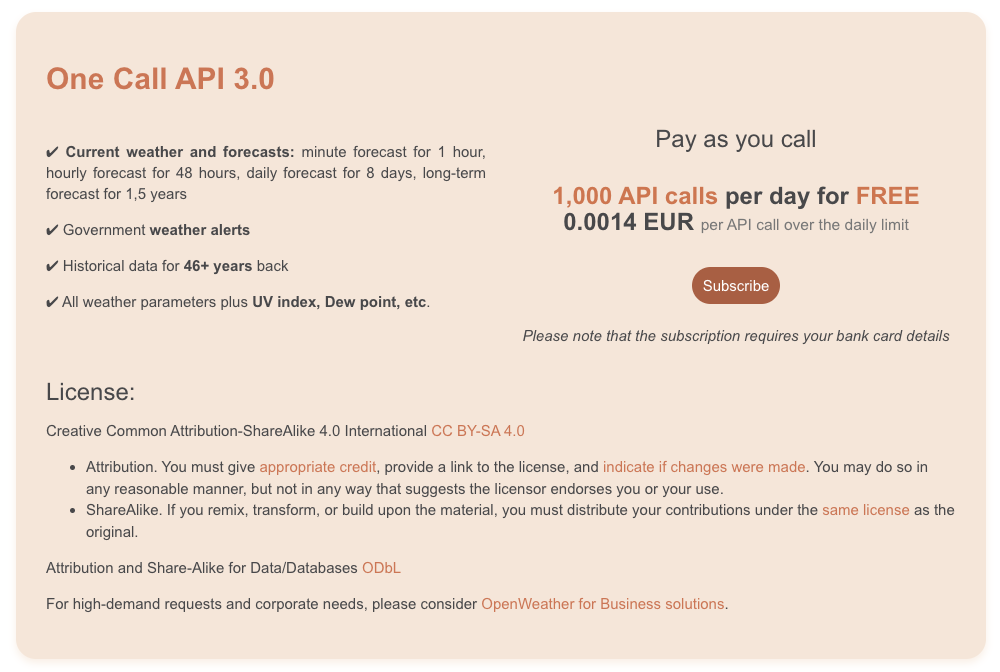

In [ ]:
# import requests
# import pandas as pd
# import time
# from datetime import datetime, timedelta

# # API Key
# API_KEY = "d55fd28990848071811aa92071cf29d1"

# # Coördinaten voor Volkel, Nederland
# LAT = 51.6547
# LON = 5.7077

# # OpenWeather API URLs
# BASE_URL = "https://api.openweathermap.org/data/3.0/onecall/timemachine"
# FORECAST_URL = "https://api.openweathermap.org/data/3.0/onecall"

# # Definieer tijdsbereik
# START_DATE = "2021-01-01"
# END_DATE = datetime.today().strftime("%Y-%m-%d")  # Automatische laatste datum
# FILE_NAME = "weerdata_volkel.csv"

# # Lijst om weerdata op te slaan
# weather_data = []

# # Stap 1: Historische weerdata ophalen
# print("Ophalen van historische weerdata...")
# date_range = pd.date_range(start=START_DATE, end=END_DATE, freq="D")

# for date in date_range:
#     unix_timestamp = int(time.mktime(date.timetuple()))
#     params = {
#         "lat": LAT,
#         "lon": LON,
#         "dt": unix_timestamp,
#         "appid": API_KEY,
#         "units": "metric",
#     }

#     response = requests.get(BASE_URL, params=params)

#     if response.status_code == 200:
#         data = response.json()
#         for hourly_data in data["data"]:
#             weather_data.append({
#                 "datetime": pd.to_datetime(hourly_data["dt"], unit="s"),
#                 "temperature": hourly_data.get("temp"),
#                 "feels_like": hourly_data.get("feels_like"),
#                 "humidity": hourly_data.get("humidity"),
#                 "pressure": hourly_data.get("pressure"),
#                 "cloud_coverage": hourly_data.get("clouds"),
#                 "wind_speed_kph": hourly_data.get("wind_speed") * 3.6,  # Omrekenen van m/s naar km/u
#                 "wind_direction": hourly_data.get("wind_deg"),
#                 "precipitation_mm": hourly_data.get("rain", {}).get("1h", 0),
#                 "weather_type": hourly_data["weather"][0]["description"] if "weather" in hourly_data else None
#             })
#     else:
#         print(f"Fout bij ophalen van {date.date()}: {response.status_code}")

# # Stap 2: 4-daagse weersvoorspelling ophalen
# print("Ophalen van 4-daagse weersvoorspelling...")
# params_forecast = {
#     "lat": LAT,
#     "lon": LON,
#     "appid": API_KEY,
#     "units": "metric",
#     "exclude": "current,minutely,daily,alerts",
# }

# response_forecast = requests.get(FORECAST_URL, params=params_forecast)

# if response_forecast.status_code == 200:
#     forecast_data = response_forecast.json()
#     for hourly_data in forecast_data["hourly"]:
#         weather_data.append({
#             "datetime": pd.to_datetime(hourly_data["dt"], unit="s"),
#             "temperature": hourly_data.get("temp"),
#             "feels_like": hourly_data.get("feels_like"),
#             "humidity": hourly_data.get("humidity"),
#             "pressure": hourly_data.get("pressure"),
#             "cloud_coverage": hourly_data.get("clouds"),
#             "wind_speed_kph": hourly_data.get("wind_speed") * 3.6,
#             "wind_direction": hourly_data.get("wind_deg"),
#             "precipitation_mm": hourly_data.get("rain", {}).get("1h", 0),
#             "weather_type": hourly_data["weather"][0]["description"] if "weather" in hourly_data else None
#         })
# else:
#     print(f"Fout bij ophalen van voorspelling: {response_forecast.status_code}")

# # Converteren naar DataFrame en opslaan als CSV
# df_weather = pd.DataFrame(weather_data)
# df_weather.to_csv(FILE_NAME, index=False)
# print(f"Weerdata opgeslagen in {FILE_NAME}")

# # Toon de eerste rijen om te controleren
# print(df_weather.head())


In [ ]:
print(f"URL: {response.url}")  # Geeft de volledige URL weer die wordt opgevraagd
print(f"Statuscode: {response.status_code}")  # Geeft de HTTP-statuscode
print(f"Response tekst: {response.text}")  # Geeft de volledige API-response terug


URL: http://api.weatherapi.com/v1/forecast.json?key=0dde3f6622464f39ba4151112251403&q=Volkel&days=4&aqi=no&alerts=no
Statuscode: 200
Response tekst: {"location":{"name":"Volkel","region":"North Brabant","country":"Netherlands","lat":51.6425,"lon":5.6542,"tz_id":"Europe/Amsterdam","localtime_epoch":1744031309,"localtime":"2025-04-07 15:08"},"current":{"last_updated_epoch":1744030800,"last_updated":"2025-04-07 15:00","temp_c":12.1,"temp_f":53.8,"is_day":1,"condition":{"text":"Sunny","icon":"//cdn.weatherapi.com/weather/64x64/day/113.png","code":1000},"wind_mph":8.3,"wind_kph":13.3,"wind_degree":58,"wind_dir":"ENE","pressure_mb":1026.0,"pressure_in":30.3,"precip_mm":0.0,"precip_in":0.0,"humidity":38,"cloud":0,"feelslike_c":10.7,"feelslike_f":51.2,"windchill_c":12.5,"windchill_f":54.6,"heatindex_c":13.6,"heatindex_f":56.5,"dewpoint_c":-1.8,"dewpoint_f":28.9,"vis_km":10.0,"vis_miles":6.0,"uv":3.5,"gust_mph":9.5,"gust_kph":15.3},"forecast":{"forecastday":[{"date":"2025-04-07","date_epoch":17

## 1.3 Feestdagen

In [ ]:
# -----------------Feestdage handmatig toevoegen-------------------
feestdagen_data = [
    # 2021
    ('2021-04-04', 'Eerste Paasdag'),
    ('2021-04-05', 'Tweede Paasdag'),
    ('2021-04-27', 'Koningsdag'),
    ('2021-05-13', 'Hemelvaartsdag'),
    ('2021-05-23', 'Eerste Pinksterdag'),
    ('2021-05-24', 'Tweede Pinksterdag'),

    # 2022
    ('2022-04-15', 'Goede Vrijdag'),
    ('2022-04-17', 'Eerste Paasdag'),
    ('2022-04-18', 'Tweede Paasdag'),
    ('2022-04-27', 'Koningsdag'),
    ('2022-05-05', 'Bevrijdingsdag'),
    ('2022-05-26', 'Hemelvaartsdag'),
    ('2022-06-06', 'Tweede Pinksterdag'),

    # 2023
    ('2023-04-07', 'Goede Vrijdag'),
    ('2023-04-09', 'Eerste Paasdag'),
    ('2023-04-10', 'Tweede Paasdag'),
    ('2023-04-27', 'Koningsdag'),
    ('2023-05-05', 'Bevrijdingsdag'),
    ('2023-05-18', 'Hemelvaartsdag'),
    ('2023-05-28', 'Eerste Pinksterdag'),
    ('2023-05-29', 'Tweede Pinksterdag'),

    # 2024
    ('2024-03-29', 'Goede Vrijdag'),
    ('2024-03-31', 'Eerste Paasdag'),
    ('2024-04-01', 'Tweede Paasdag'),
    ('2024-04-27', 'Koningsdag'),
    ('2024-05-05', 'Bevrijdingsdag'),
    ('2024-05-09', 'Hemelvaartsdag'),
    ('2024-05-19', 'Eerste Pinksterdag'),
    ('2024-05-20', 'Tweede Pinksterdag'),

    # 2025
    ('2025-04-18', 'Goede Vrijdag'),
    ('2025-04-20', 'Eerste Paasdag'),
    ('2025-04-21', 'Tweede Paasdag'),
    ('2025-04-26', 'Koningsdag'),
    ('2025-05-05', 'Bevrijdingsdag'),
    ('2025-05-29', 'Hemelvaartsdag'),
    ('2025-06-08', 'Eerste Pinksterdag'),
    ('2025-06-09', 'Tweede Pinksterdag'),

    # 2026
    ('2026-04-03', 'Goede Vrijdag'),
    ('2026-04-05', 'Eerste Paasdag'),
    ('2026-04-06', 'Tweede Paasdag'),
    ('2026-04-27', 'Koningsdag'),
    ('2026-05-05', 'Bevrijdingsdag'),
    ('2026-05-14', 'Hemelvaartsdag'),
    ('2026-05-24', 'Eerste Pinksterdag'),
    ('2026-05-25', 'Tweede Pinksterdag'),
]
# DataFrame maken en Kerst en nieuwjaarsdag eruit halen omdat deze binnen een vakantie valt
feestdagen = pd.DataFrame(feestdagen_data, columns=['date', 'feestdag'])
feestdagen['date'] = pd.to_datetime(feestdagen['date'])
feestdagen.head()


,date,feestdag
0,2021-04-04,Eerste Paasdag
1,2021-04-05,Tweede Paasdag
2,2021-04-27,Koningsdag
3,2021-05-13,Hemelvaartsdag
4,2021-05-23,Eerste Pinksterdag


## 1.4 Evenementen
Evenementen staan onderverdeeld in externedata omdat ze handmatig toegevoegd kunnen worden.

In [ ]:
# Lijst met evenementen (datum, naam, beschrijving)
evenementen_data = [
    ("2024-12-26", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2024-12-27", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2024-12-28", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2024-12-29", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2024-12-30", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2024-12-31", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2025-01-02", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2025-01-03", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2025-01-04", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),
    ("2025-01-05", "Winterland", "Een gethematiseerd winterverhaal bij een kampvuur met een extra horeca tent"),

    ("2025-01-01", "Nieuwjaarsduik", "Unox nieuwjaarsduik + apart ticket met lage toegangsprijs van 3,50 EUR p.p."),
    ("2024-01-01", "Nieuwjaarsduik", "Unox nieuwjaarsduik + apart ticket met lage toegangsprijs van 3,50 EUR p.p."),

    ("2024-10-21", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2024-10-22", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2024-10-23", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2024-10-24", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2024-10-25", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2024-10-26", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2025-10-13", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2025-10-14", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2025-10-15", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2025-10-16", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2025-10-17", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),
    ("2025-10-18", "Herfstfestival", "Avond entertainment op het park, met afsluitende eindshow op de klimberg"),

    ("2024-10-06", "Heerlijk Hemelrijk Festival", "Organisatie door Par-T. Wij verkopen zelf 7.500 tickets van 5 EUR. Geen overige bezoekers op het park"),
    ("2025-10-05", "Heerlijk Hemelrijk Festival", "Organisatie door Par-T. Wij verkopen zelf 7.500 tickets van 5 EUR. Geen overige bezoekers op het park"),

    ("2024-10-04", "Festyland", "Festyland wordt achter op ons park georganiseerd door Par-T. Geen kinderfeestjes of groepen."),
    ("2024-10-05", "Festyland", "Festyland wordt achter op ons park georganiseerd door Par-T. Geen kinderfeestjes of groepen."),

    ("2024-08-17", "Springspektakel", "Diverse springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),
    ("2024-08-18", "Springspektakel", "Diverse springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),
    ("2024-08-16", "Springspektakel", "Diverse springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),
    ("2024-08-17", "Springspektakel", "Diverse springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),

    ("2024-07-13", "Spetterspektakel", "Diverse water springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),
    ("2024-07-14", "Spetterspektakel", "Diverse water springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),
    ("2025-07-05", "Spetterspektakel", "Diverse water springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),
    ("2025-07-06", "Spetterspektakel", "Diverse water springkussens + muziek op ons voetbalveld. Leuk extraatje voor leden."),

    ("2024-05-10", "Phoxy fanclub dag", "Fanclubdag van Phoxy (PSV kids club)"),
    ("2025-05-29", "Phoxy fanclub dag", "Fanclubdag van Phoxy (PSV kids club)"),
    ("2025-05-30", "Phoxy fanclub dag", "Fanclubdag van Phoxy (PSV kids club)"),

    ("2024-04-27", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-04-28", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-04-29", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-04-30", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-05-01", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-05-02", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-05-03", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-05-04", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2024-05-05", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),

    ("2025-04-27", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-04-28", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-04-29", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-04-30", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-05-01", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-05-02", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-05-03", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-05-04", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),
    ("2025-05-05", "Oervalleidagen", "Dinodagen in de Oervallei met een theatershow en klein entertainment"),

    ("2024-02-14", "Piratendagen", "Knutselen in binnenspeeltuin. Kleinschalig evenementje. In ’25 niet georganiseerd."),
    ("2024-02-15", "Piratendagen", "Knutselen in binnenspeeltuin. Kleinschalig evenementje. In ’25 niet georganiseerd."),
    ("2024-02-16", "Piratendagen", "Knutselen in binnenspeeltuin. Kleinschalig evenementje. In ’25 niet georganiseerd.")
]

# DataFrame aanmaken
evenementen = pd.DataFrame(evenementen_data, columns=["date", "event", "beschrijving"])
evenementen["date"] = pd.to_datetime(evenementen["date"])

evenementen.head()

,date,event,beschrijving
0,2024-12-26,Winterland,Een gethematiseerd winterverhaal bij een kampv...
1,2024-12-27,Winterland,Een gethematiseerd winterverhaal bij een kampv...
2,2024-12-28,Winterland,Een gethematiseerd winterverhaal bij een kampv...
3,2024-12-29,Winterland,Een gethematiseerd winterverhaal bij een kampv...
4,2024-12-30,Winterland,Een gethematiseerd winterverhaal bij een kampv...


## 1.4 Samenvoegen externe data


### Historisch

In [ ]:
# -----------------PER UUR-------------------
# -----------------Weather iets opschonen-------------------
# Kolomvolgorde die we in beide datasets willen behouden
kolomvolgorde = [
    "datetime", "maand_nr", "weertype", "temperatuur", "bewolking_%", "neerslag_mm"
    , "regen_bin", "sneeuw_bin", "mist_bin", "onweer_bin", "ijsvorming_bin"
]
# Reorder kolommen op basis van de gewenste volgorde
Weather_KNMI_V_uur = Weather_KNMI_V_uur[kolomvolgorde]

# Kolomvolgorde die we in beide datasets willen behouden
kolomvolgorde2 = [
    "datetime",  "maand_nr", "weertype", "temperatuur", "bewolking_%", "neerslag_mm",
    "sneeuw_mm", "regen_bin", "sneeuw_bin"
]
# Reorder kolommen op basis van de gewenste volgorde
Weather_API_T_uur = Weather_API_T_uur[kolomvolgorde2]

# -----------------Samenvoegen met vakanties -------------------
# Merge beide datasets op datetime
External_hist_dta_uur = Weather_KNMI_V_uur.merge(vakanties_zuid_uur, how="left", on="datetime")

# Voeg een indicatie toe of het een vakantiedag is
External_hist_dta_uur["vakantie_bin"] = External_hist_dta_uur["vakantietype"].notna().map({True: 1, False: 0})

# Vul lege vakantietype en verplicht kolommen aan
External_hist_dta_uur["vakantietype"] = External_hist_dta_uur["vakantietype"].fillna("Geen")
External_hist_dta_uur["verplicht_bin"] = External_hist_dta_uur["verplicht_bin"].fillna("Geen")

# -----------------Omzetten vanaf uur interval naar dag -------------------
# 1. Maak een tijdelijke kopie van de dataset
External_hist_dta_temp = External_hist_dta_uur.copy()

# 2. Pas de weertype-functie toe op uurlijkse data
External_hist_dta_temp["weertype_uur"] = External_hist_dta_temp.apply(bepaal_weertype2, axis=1)

# 3. Zet 'datetime' als index en filter alleen de openingsuren (10:00–18:00)
External_hist_dta_temp = External_hist_dta_temp.set_index("datetime")
External_hist_dta_open = External_hist_dta_temp.between_time("10:00", "18:00").reset_index()

# 4. Maak een 'date'-kolom zonder tijd om per dag te groeperen
External_hist_dta_open["date"] = External_hist_dta_open["datetime"].dt.date

# 5. Groepeer per dag en bereken de gewenste statistieken
External_hist_dta_dag = External_hist_dta_open.groupby("date").agg({
    "temperatuur": "mean",         # Gemiddelde temperatuur tussen 10-18u
    "maand_nr": "max",   # Als het ooit vakantie was, dan blijft het 1
    "bewolking_%": "mean",         # Gemiddelde bewolking
    "neerslag_mm": "sum",          # Totale neerslag in 10-18u
    "regen_bin": "max",            # 1 als het ooit geregend heeft
    "sneeuw_bin": "max",
    "mist_bin": "max",
    "onweer_bin": "max",
    "ijsvorming_bin": "max",
    "weertype_uur": lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None,  # Meest voorkomende uur-weertype
    "vakantietype": lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "Geen",  # Meest voorkomende vakantietype
    "verplicht_bin": "max",  # Als het ooit verplicht was, dan blijft het 1
    "vakantie_bin": "max",   # Als het ooit vakantie was, dan blijft het 1
}).reset_index()

# Pas de weertype-functie opnieuw toe op de geaggregeerde dagwaarden #IK DENK DAT MEEST VOORKOMEND (TUSSEN 10-18) HET MEEST LOGISCH IS
External_hist_dta_dag["weertype_opnieuwbepaald"] = External_hist_dta_dag.apply(bepaal_weertype2, axis=1)
External_hist_dta_dag = External_hist_dta_dag.rename(columns={'weertype_uur': 'weertype_meestvoorkomen'})

# Zet de 'date' kolom terug naar datetime64[ns] voor correcte merges later
External_hist_dta_dag["date"] = pd.to_datetime(External_hist_dta_dag["date"])

# -----------------Omzetten van weertype naar numeriek en binaire waardes -------------------
#verwijder rijen met meer dan 4 NaN
External_hist_dta_dag = External_hist_dta_dag.dropna()

#weermapping
weertype_mapping = {
    "matige of zware regen met onweer": 0,
    "onweer mogelijk": 1,
    "ijzige mist": 2,
    "mist": 3,
    "kans op gladheid": 4,
    "zware sneeuwval": 5,
    "matige sneeuwval": 6,
    "lichte sneeuw": 7,
    "matige of zware regen": 8,
    "matige regen": 9,
    "lichte regen": 10,
    "lichte motregen": 11,
    "bovenlucht onzichtbaar": 12,
    "zwaar bewolkt": 13,
    "bewolkt": 14,
    "gedeeltelijk bewolkt": 15,
    "licht bewolkt": 16,
    "helder": 17
}

weertype_mapping2 = {
    "matige of zware regen met onweer": 0,
    "onweer mogelijk": 0,
    "ijzige mist": 0,
    "mist": 0,
    "kans op gladheid": 0,
    "zware sneeuwval": 0,
    "matige sneeuwval": 0,
    "lichte sneeuw": 0,
    "matige of zware regen": 0,
    "matige regen": 0,
    "lichte regen": 0,
    "lichte motregen": 0,
    "bovenlucht onzichtbaar": 0,
    "zwaar bewolkt": 0,
    "bewolkt": 1,
    "gedeeltelijk bewolkt": 1,
    "licht bewolkt": 1,
    "helder": 1
}

#3 manieren om weertype te generaliseren
External_hist_dta_dag["weertype_mv_num"] = External_hist_dta_dag["weertype_meestvoorkomen"].map(weertype_mapping)
External_hist_dta_dag["goed/slecht_weermv_bin"] = External_hist_dta_dag["weertype_meestvoorkomen"].map(weertype_mapping2)

# -----------------Samenvoegen met feestdagen -------------------
External_hist_dta_dag = External_hist_dta_dag.merge(feestdagen, how="left", on="date")
External_hist_dta_dag["feestdag_bin"] = External_hist_dta_dag["feestdag"].notna().map({True: 1, False: 0})
External_hist_dta_dag["feestdag"] = External_hist_dta_dag["feestdag"].fillna("Geen feestdag")

# -----------------Samenvoegen met events  -------------------
# Merge evenementen met External_hist_dta_dag
External_hist_dta_dag = pd.merge(External_hist_dta_dag, evenementen, on='date', how='left')

#Verwijder beschrijving
External_hist_dta_dag = External_hist_dta_dag.drop(columns=['beschrijving'])

# Fill NaN waardes in 'event' and 'beschrijving' met 'Geen evenement'
External_hist_dta_dag['event'].fillna('Geen evenement', inplace=True)

# Impactniveau numeriek maken (bijv. 3 = hoog, 2 = medium, 1 = laag, 0 = geen, -1 = exclusief)
impact_dict_num = {
    "Herfstfestival": 3,
    "Heerlijk Hemelrijk Festival": 3,
    "Springspektakel": 2,
    "Oervalleidagen": 2,
    "Phoxy fanclub dag": 2,
    "Spetterspektakel": 1,
    "Piratendagen": 1,
    "Nieuwjaarsduik": 0,
    "Festyland": 0  }
External_hist_dta_dag["event_impact_num"] = External_hist_dta_dag["event"].map(impact_dict_num).fillna(0).astype(int)

#Nieuwe kolom event_bin (alleen middel en hoog staan op ja)
External_hist_dta_dag["event_bin"] = External_hist_dta_dag["event_impact_num"].apply(lambda x: 1 if x > 0 else 0)

External_hist_dta_dag.tail(2)


<ipython-input-88-082819fd529f>:132: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  External_hist_dta_dag['event'].fillna('Geen evenement', inplace=True)


,date,temperatuur,maand_nr,bewolking_%,neerslag_mm,regen_bin,sneeuw_bin,mist_bin,onweer_bin,ijsvorming_bin,...,verplicht_bin,vakantie_bin,weertype_opnieuwbepaald,weertype_mv_num,goed/slecht_weermv_bin,feestdag,feestdag_bin,event,event_impact_num,event_bin
1554,2025-04-05,15.133333,4,13.666667,0.0,0,0,0,0,0,...,Geen,0,licht bewolkt,17,1,Geen feestdag,0,Geen evenement,0,0
1555,2025-04-06,10.844444,4,1.333333,0.0,0,0,0,0,0,...,Geen,0,licht bewolkt,17,1,Geen feestdag,0,Geen evenement,0,0


### Forecast

In [ ]:
# -----------------PER UUR  -------------------
# -----------------Samenvoegen met vakanties  -------------------
# Merge beide datasets op datetime
External_forecast_dta_uur = Weather_API_T_uur.merge(vakanties_zuid, how="left", on="datetime")

# Voeg een indicatie toe of het een vakantiedag is
External_forecast_dta_uur["vakantie_bin"] = External_forecast_dta_uur["vakantietype"].notna().map({True: 1, False: 0})

# Vul lege vakantietype en verplicht kolommen aan
External_forecast_dta_uur["vakantietype"] = External_forecast_dta_uur["vakantietype"].fillna("Geen")
External_forecast_dta_uur["verplicht_bin"] = External_forecast_dta_uur["verplicht_bin"].fillna("Geen")




# -----------------PER DAG------------------
# 1. Maak een kopie van de dataset
External_forecast_dta_temp = External_forecast_dta_uur.copy()

# -----------------Alleen kijkende naar openingstijden ------------------
# 3. Zet 'datetime' als index en filter alleen de openingsuren (10:00–18:00)
External_forecast_dta_temp = External_forecast_dta_temp.set_index("datetime")
External_forecast_dta_open = External_forecast_dta_temp.between_time("10:00", "18:00").reset_index()

# 4. Maak een 'date'-kolom zonder tijd om per dag te groeperen
External_forecast_dta_open["date"] = External_forecast_dta_open["datetime"].dt.date

# -----------------Omzetten naar dag ------------------
#Groepeer per dag en bereken de gewenste statistieken
External_forecast_dta_dag = (
    External_forecast_dta_open
    .groupby("date")
    .agg({
        "temperatuur": "mean",         # Gemiddelde temperatuur tussen 10-18u
        "maand_nr": "max",
        "bewolking_%": "mean",         # Gemiddelde bewolking
        "neerslag_mm": "sum",          # Totale neerslag in 10-18u
        "regen_bin": "max",            # 1 als het ooit geregend heeft
        "sneeuw_bin": "max",
        "weertype": lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None,  # Meest voorkomende uur-weertype
        # Voeg vakantietype, verplicht_bin en vakantie_bin toe
        "vakantietype": lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "Geen",  # Meest voorkomende vakantietype
        "verplicht_bin": "max",  # Als het ooit verplicht was, dan blijft het 1
        "vakantie_bin": "max",   # Als het ooit vakantie was, dan blijft het 1
    })
    .reset_index()
)

# -----------------Nieuw weertype toevoegen ------------------
# 6. Pas de weertype-functie opnieuw toe op de geaggregeerde dagwaarden
External_forecast_dta_dag["weertype_opnieuwbepaald"] = External_forecast_dta_dag.apply(bepaal_weertype2, axis=1)
External_forecast_dta_dag = External_forecast_dta_dag.rename(columns={'weertype': 'weertype_meestvoorkomen'})


# -----------------Omzetten van weertype naar numeriek en binaire waardes -------------------
#verwijder rijen met meer dan 4 NaN
External_hist_dta_dag = External_hist_dta_dag.dropna()

#weermapping
weertype_mapping = {
    "matige of zware regen met onweer": 0,
    "onweer mogelijk": 1,
    "ijzige mist": 2,
    "mist": 3,
    "kans op gladheid": 4,
    "zware sneeuwval": 5,
    "matige sneeuwval": 6,
    "lichte sneeuw": 7,
    "matige of zware regen": 8,
    "matige regen": 9,
    "lichte regen": 10,
    "lichte motregen": 11,
    "bovenlucht onzichtbaar": 12,
    "zwaar bewolkt": 13,
    "bewolkt": 14,
    "gedeeltelijk bewolkt": 15,
    "licht bewolkt": 16,
    "helder": 17
}

weertype_mapping2 = {
    "matige of zware regen met onweer": 0,
    "onweer mogelijk": 0,
    "ijzige mist": 0,
    "mist": 0,
    "kans op gladheid": 0,
    "zware sneeuwval": 0,
    "matige sneeuwval": 0,
    "lichte sneeuw": 0,
    "matige of zware regen": 0,
    "matige regen": 0,
    "lichte regen": 0,
    "lichte motregen": 0,
    "bovenlucht onzichtbaar": 0,
    "zwaar bewolkt": 0,
    "bewolkt": 1,
    "gedeeltelijk bewolkt": 1,
    "licht bewolkt": 1,
    "helder": 1
}

#2 manieren om weertype te generaliseren (WE GEBRUIKEN ENKEL MEEST VOORKOMEND!!)
External_forecast_dta_dag["weertype_mv_num"] = External_forecast_dta_dag["weertype_meestvoorkomen"].map(weertype_mapping)
External_forecast_dta_dag["goed/slecht_weermv_bin"] = External_forecast_dta_dag["weertype_meestvoorkomen"].map(weertype_mapping2)

# -----------------Samenvoegen feestdagen ------------------
External_forecast_dta_dag["date"] = pd.to_datetime(External_forecast_dta_dag["date"])
External_forecast_dta_dag = External_forecast_dta_dag.merge(feestdagen, how="left", on="date")
External_forecast_dta_dag["feestdag_bin"] = External_forecast_dta_dag["feestdag"].notna().map({True: 1, False: 0})

# -----------------Samenvoegen met events  -------------------
# Merge evenementen met External_forecast_dta_dag
External_forecast_dta_dag = pd.merge(External_forecast_dta_dag, evenementen, on='date', how='left')

#Verwijder beschrijving
External_forecast_dta_dag = External_forecast_dta_dag.drop(columns=['beschrijving'])

# Fill NaN waardes in 'event' and 'beschrijving' met 'Geen evenement'
External_forecast_dta_dag['event'].fillna('Geen evenement', inplace=True)

# Impactniveau numeriek maken (bijv. 3 = hoog, 2 = medium, 1 = laag, 0 = geen, -1 = exclusief)
impact_dict_num = {
    "Herfstfestival": 3,
    "Heerlijk Hemelrijk Festival": 3,
    "Springspektakel": 2,
    "Oervalleidagen": 2,
    "Phoxy fanclub dag": 2,
    "Spetterspektakel": 1,
    "Piratendagen": 1,
    "Nieuwjaarsduik": 0,
    "Festyland": 0  }
External_forecast_dta_dag["event_impact_num"] =External_forecast_dta_dag["event"].map(impact_dict_num).fillna(0).astype(int)

#Nieuwe kolom event_bin (alleen middel en hoog staan op ja)
External_forecast_dta_dag["event_bin"] = External_forecast_dta_dag["event_impact_num"].apply(lambda x: 1 if x > 0 else 0)

# Bekijk de eerste paar rijen
External_forecast_dta_dag.head(2)


<ipython-input-89-e8c512d4950a>:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  External_forecast_dta_dag['event'].fillna('Geen evenement', inplace=True)


,date,temperatuur,maand_nr,bewolking_%,neerslag_mm,regen_bin,sneeuw_bin,weertype_meestvoorkomen,vakantietype,verplicht_bin,vakantie_bin,weertype_opnieuwbepaald,weertype_mv_num,goed/slecht_weermv_bin,feestdag,feestdag_bin,event,event_impact_num,event_bin
0,2025-04-07,12.022222,4,18.222222,0.0,0,0,zonnig,Geen,Geen,0,licht bewolkt,NaN,NaN,NaN,0,Geen evenement,0,0
1,2025-04-08,14.111111,4,8.444444,0.0,0,0,zonnig,Geen,Geen,0,licht bewolkt,NaN,NaN,NaN,0,Geen evenement,0,0




---


#  DEEL 02: INTERNE DATA


## 2.1 Ticket_toegang


In [ ]:
# -----------------Openen artikelen en tickettoegang  -------------------
drive.mount('/content/drive')
file_path1 = "/content/drive/My Drive/BillyBird/Ticket Toegang Statestieken LEX 2025-03-21T09_35_10.xlsx"
Ticket_toegang = pd.read_excel(file_path1)

file_path6 = "/content/drive/My Drive/BillyBird/Artikelen LEX 2025-03-21T14_07_54.xlsx"
Artikelen = pd.read_excel(file_path6)


# Haal beschrijving op
Artikelen = Artikelen.rename(columns={'Nr.': 'Artikelnr.'})
Ticket_toegang = pd.merge(Ticket_toegang, Artikelen[['Artikelnr.', 'Omschrijving']], on='Artikelnr.', how='left')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Ticket_toegang

,Artikelnr.,Postnr.,Variant,ticket Type,Toelatingscode,Toelatingsdatum,Toelating Uur,Toelating Telling,Toelatingstelling (Negatief),Toelating graaf (Re-Entry),Gegenereerde telling (Pos),Gegenereerde telling (Neg),Som Toelating Count,Hoogste toegang Entry No.,Omschrijving
0,HEMEL-HOOG,1,<BLANK>,ENTREE,HEMEL-HOOG,2021-08-09,11,0,0,0,2,0,1217148,2,Entreeticket Hemelrijk
1,PARKEERTICKET,2,<BLANK>,PARKEER,PARKEREN,2021-08-09,11,0,0,0,1,0,1217148,3,NaN
2,HEMEL-HOOG,3,<BLANK>,ENTREE,HEMEL-HOOG,2021-08-09,14,0,0,0,2,0,1217148,6,Entreeticket Hemelrijk
3,PARKEERTICKET,4,<BLANK>,PARKEER,PARKEREN,2021-08-09,14,0,0,0,2,0,1217148,8,NaN
4,HEMEL-HOOG,5,<BLANK>,ENTREE,HEMEL-HOOG,2021-08-09,15,2,0,0,0,0,1217148,12,Entreeticket Hemelrijk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98051,HEMEL-MIDDEN,101996,<BLANK>,ENTREE,HEMEL-MIDDEN,2024-11-18,18,0,0,0,4,0,1217148,4497328,Entreeticket Hemelrijk
98052,PARKEER,101997,<BLANK>,PARKEER,PARKEREN,2024-11-18,18,0,0,0,1,0,1217148,4497330,Parkeerticket
98053,HEMEL-LAAG,101998,<BLANK>,ENTREE,HEMEL-LAAG,2024-11-19,0,0,0,0,1,0,1217148,4497334,Entreeticket Hemelrijk
98054,PARKEER,101999,<BLANK>,PARKEER,PARKEREN,2024-11-19,0,0,0,0,1,0,1217148,4497336,Parkeerticket


['HEMEL-HOOG' 'PARKEERTICKET' 'PARKEER' 'HEMEL-MIDDEN' 'CIRCUS-TICKET'
 'HEMEL-LAAG' 'LID ENTREE' 'ART00659' 'BINNENSPEELTUIN' 'KASSA-ENTREE'
 'ENTREE-KF' 'ENTREE-SG' 'ART00873' 'ART00874' 'AQUAFUN-DAGGAST'
 'AQUAFUN-LID' 'ENTREE-SG30' 'ART00867' 'ART00671' 'ART00666' 'ART00660'
 'ART00661' 'ART00676' 'ART00665' 'ART00920' 'ART00919' 'ART00673'
 'FESTIVAL' 'ART00864' 'ART00672' 'ART00670' 'ART00939' 'ART00862'
 'ART00711' 'ART00663' 'ART00689' 'AQUANOODLID' 'AQUAFUNOBNL' 'ART00716'
 'ENTREE-F' 'ART00941' 'ART00942' 'PIZZADEAL-KIND' 'PIZZADEAL-VOLW'
 'NIEUWJAAR' 'BORRELPLANK' 'ART00694' 'ART00452' 'ART00669' 'EVENEMENT'
 'ART00668' 'EVENEMENT2' 'ART00667' 'PAASBRUNCH-KIND' 'PAASBRUNCH-VOLW'
 'PICKNICKBOX' 'GRATIS ENTREE' 'ART00674' 'ART00954' 'ART00953' 'ART00957'
 'ART00977' 'ART00970' 'ART00863' 'HEMEL-JAARROND2' 'ART00865' 'ART00664'
 'ART00662' 'ART00988' 'ENTREE-KF-OUD' 'ENTREE-SG30-OUD' 'ART01021'
 'ENTREE-SG30-VROEG' 'ART01005' 'ENTREE-ACTIE' 'HEMEL-JAARROND'
 'PARKERENPSV' 'ART0

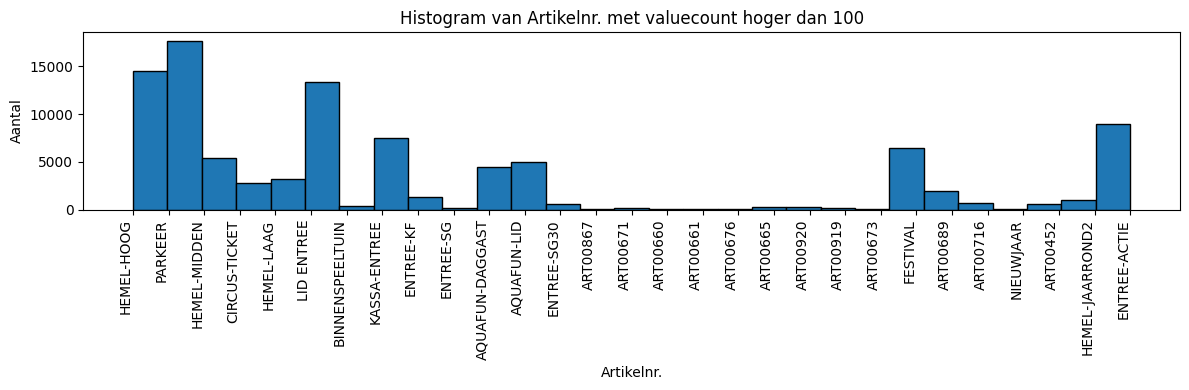

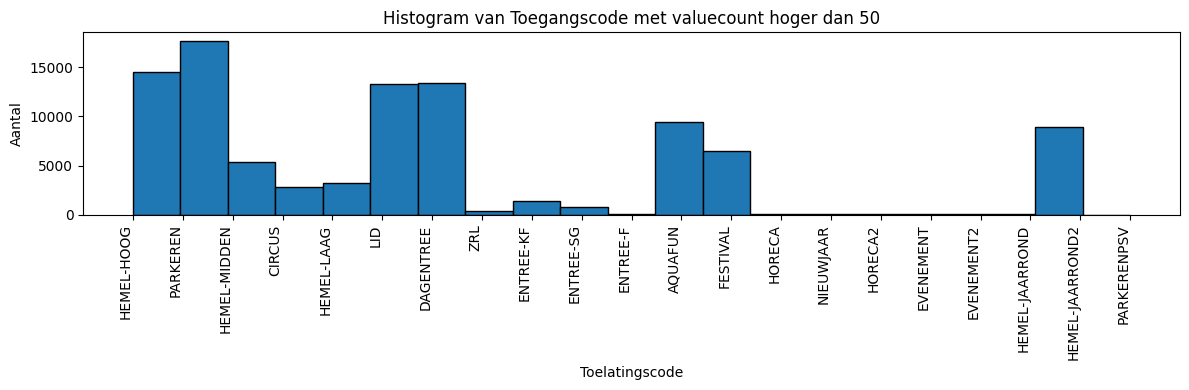

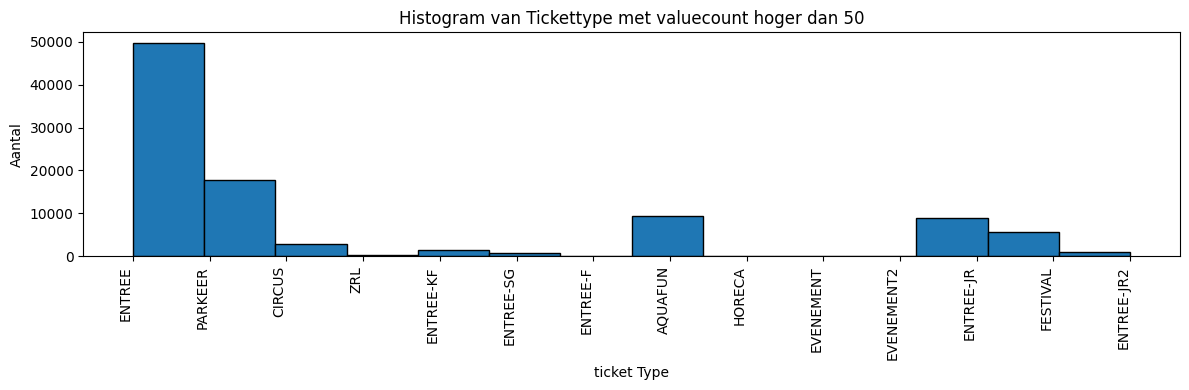

In [ ]:
print(Ticket_toegang['Artikelnr.'].unique())
print('')
print(Ticket_toegang['ticket Type'].unique())
print('')
print(Ticket_toegang['Toelatingscode'].unique())

# Artikelnr
# Assuming Ticket_toegang is your DataFrame and 'Artikelnr.' is the column you want to plot
artikelnr_counts = Ticket_toegang['Artikelnr.'].value_counts()

# Filter for Artikelnr. with value counts higher than 100
artikelnr_counts_filtered = artikelnr_counts[artikelnr_counts > 50]

# Create the histogram
plt.figure(figsize=(12, 4))
plt.hist(Ticket_toegang['Artikelnr.'].apply(lambda x: x if x in artikelnr_counts_filtered.index else None).dropna(), bins=len(artikelnr_counts_filtered), edgecolor='black')

plt.xlabel('Artikelnr.')
plt.ylabel('Aantal')
plt.title('Histogram van Artikelnr. met valuecount hoger dan 100')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Toegangscode
toegangscode_counts = Ticket_toegang['Toelatingscode'].value_counts()
toegangscode_counts_filtered = toegangscode_counts[toegangscode_counts > 0]

plt.figure(figsize=(12, 4))
plt.hist(Ticket_toegang['Toelatingscode'].apply(lambda x: x if x in toegangscode_counts_filtered.index else None).dropna(),
         bins=len(toegangscode_counts_filtered), edgecolor='black')

plt.xlabel('Toelatingscode')
plt.ylabel('Aantal')
plt.title('Histogram van Toegangscode met valuecount hoger dan 50')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Tickettype
tickettype_counts = Ticket_toegang['ticket Type'].value_counts()
tickettype_counts_filtered = tickettype_counts[tickettype_counts > 0]

plt.figure(figsize=(12, 4))
plt.hist(Ticket_toegang['ticket Type'].apply(lambda x: x if x in tickettype_counts_filtered.index else None).dropna(),
         bins=len(tickettype_counts_filtered), edgecolor='black')

plt.xlabel('ticket Type')
plt.ylabel('Aantal')
plt.title('Histogram van Tickettype met valuecount hoger dan 50')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


### Leden entree


<ipython-input-67-5149ff76ebbe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Leden['datetime'] = pd.to_datetime(Leden['Toelatingsdatum'].astype(str) + ' ' + Leden['Toelating Uur'].astype(str))


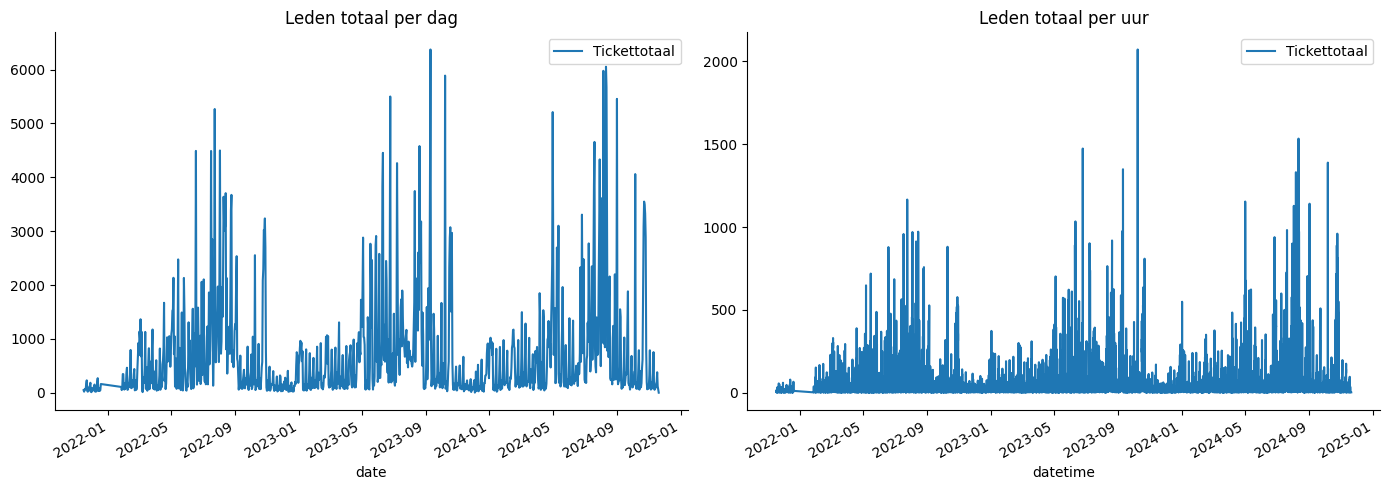

In [ ]:
# -----------------Leden definitie  -------------------
leden_entree = ['LID ENTREE']

# -----------------Leden filter  -------------------
Leden = Ticket_toegang[Ticket_toegang['Artikelnr.'].isin(leden_entree)]

# -----------------Datetime  -------------------
Leden['datetime'] = pd.to_datetime(Leden['Toelatingsdatum'].astype(str) + ' ' + Leden['Toelating Uur'].astype(str))
Leden = Leden.drop(columns=[
    'Toelatingsdatum', 'Toelating Uur', 'Variant',
    'Toelatingstelling (Negatief)', 'Toelating graaf (Re-Entry)',
    'Som Toelating Count', 'Hoogste toegang Entry No.', 'Postnr.',
    'Gegenereerde telling (Pos)', 'Gegenereerde telling (Neg)'
])

# -----------------Ticketaantallen bepalen per uur -------------------
Leden_uur = Leden.groupby('datetime')['Toelating Telling'].sum().reset_index()
Leden_uur = Leden_uur.rename(columns={'Toelating Telling': 'Tickettotaal'})

# CHECK DIT
Leden_uur = Leden_uur[(Leden_uur['datetime'].dt.hour >= 8) & (Leden_uur['datetime'].dt.hour < 19)]

# -----------------Omzetten naar dag -------------------
Leden_dag = Leden_uur.groupby(Leden_uur['datetime'].dt.date)['Tickettotaal'].sum().reset_index()
Leden_dag.columns = ['date', 'Tickettotaal']
Leden_dag['date'] = pd.to_datetime(Leden_dag['date'])

# -----------------Plot: Tickettotaal per dag en per uur -------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Linker plot: per dag
Leden_dag.plot(x='date', y='Tickettotaal', kind='line', ax=axes[0], title='Leden totaal per dag')
axes[0].spines[['top', 'right']].set_visible(False)

# Rechter plot: per uur
Leden_uur.plot(x='datetime', y='Tickettotaal', kind='line', ax=axes[1], title='Leden totaal per uur')
axes[1].spines[['top', 'right']].set_visible(False)

# Ruimte tussen de plots optimaliseren\
plt.tight_layout()
plt.show()



### Ticket entree

<ipython-input-68-51211735f411>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tickets['datetime'] = pd.to_datetime(Tickets['Toelatingsdatum'].astype(str) + ' ' + Tickets['Toelating Uur'].astype(str))


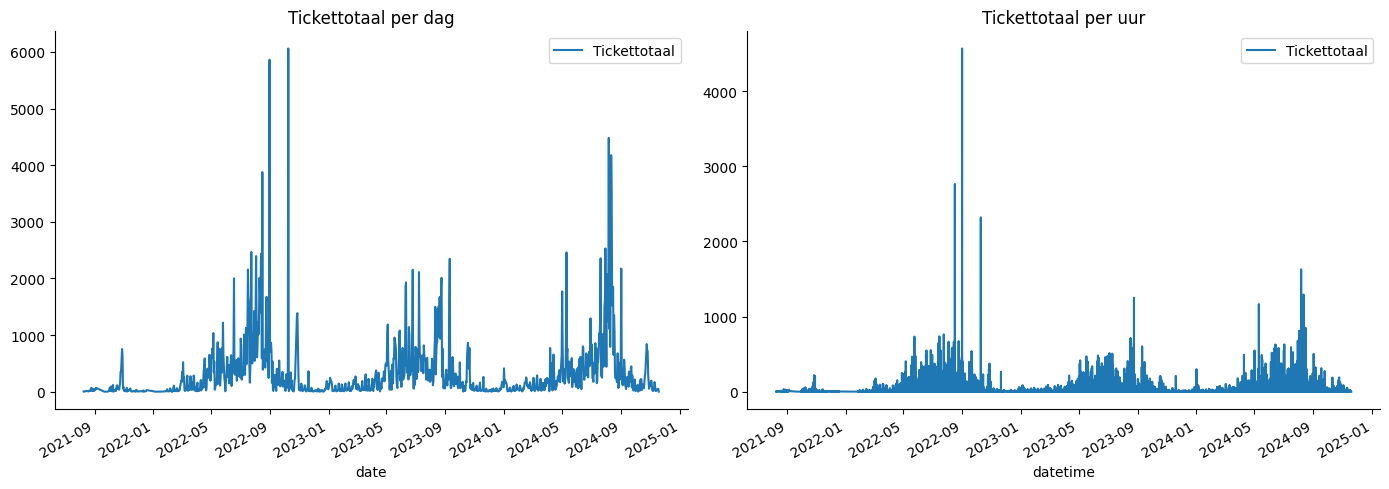

In [ ]:
# -----------------Ticket definitie  -------------------
relevante_types = ["ENTREE", "ENTREE-JR", "ENTREE-JR2", "ENTREE-SG"]

# -----------------Filter op tickets -------------------
Tickets = Ticket_toegang[Ticket_toegang['ticket Type'].isin(relevante_types)]
Tickets['datetime'] = pd.to_datetime(Tickets['Toelatingsdatum'].astype(str) + ' ' + Tickets['Toelating Uur'].astype(str))
Tickets = Tickets.drop(columns=[
    'Toelatingsdatum', 'Toelating Uur', 'Variant',
    'Toelatingstelling (Negatief)', 'Toelating graaf (Re-Entry)',
    'Som Toelating Count', 'Hoogste toegang Entry No.', 'Postnr.',
    'Gegenereerde telling (Pos)', 'Gegenereerde telling (Neg)'
])
# LID zit hier nu ook nog bij, en moet er uit
Tickets = Tickets[~Tickets['Toelatingscode'].str.contains('LID')]

# -----------------Ticketaantallen bepalen per uur -------------------
Tickets_uur = Tickets.groupby('datetime')['Toelating Telling'].sum().reset_index()
Tickets_uur = Tickets_uur.rename(columns={'Toelating Telling': 'Tickettotaal'})

Tickets_uur = Tickets_uur[(Tickets_uur['datetime'].dt.hour >= 8) & (Tickets_uur['datetime'].dt.hour < 19)]

# -----------------Omzetten naar dag -------------------
Tickets_dag = Tickets_uur.groupby(Tickets_uur['datetime'].dt.date)['Tickettotaal'].sum().reset_index()
Tickets_dag.columns = ['date', 'Tickettotaal']
Tickets_dag['date'] = pd.to_datetime(Tickets_dag['date'])


# -----------------Plot: Tickettotaal per dag en per uur -------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Linker plot: per dag
Tickets_dag.plot(x='date', y='Tickettotaal', kind='line', ax=axes[0], title='Tickettotaal per dag')
axes[0].spines[['top', 'right']].set_visible(False)

# Rechter plot: per uur
Tickets_uur.plot(x='datetime', y='Tickettotaal', kind='line', ax=axes[1], title='Tickettotaal per uur')
axes[1].spines[['top', 'right']].set_visible(False)

# Ruimte tussen de plots optimaliseren
plt.tight_layout()
plt.show()



### Kinderfeestjes

<ipython-input-69-67d1f16c2d13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kinderfeest['datetime'] = pd.to_datetime(kinderfeest['Toelatingsdatum'].astype(str) + ' ' + kinderfeest['Toelating Uur'].astype(str))


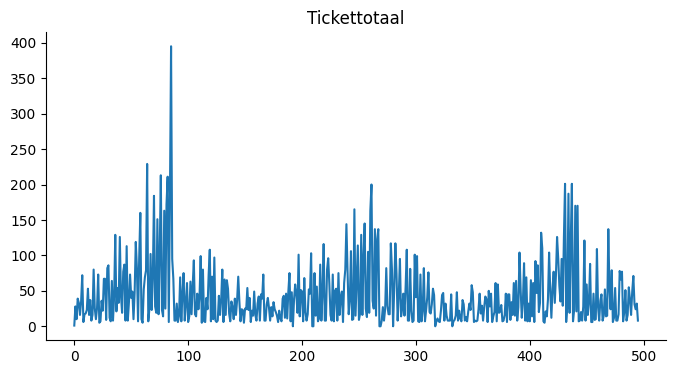

In [ ]:
# -----------------Feestje definitie  -------------------
kinderfeestje = ['ENTREE-KF', 'ENTREE-KF-OUD']

# -----------------Filter op kinderfeest -------------------
kinderfeest = Ticket_toegang[Ticket_toegang['Artikelnr.'].isin(kinderfeestje)]
kinderfeest['datetime'] = pd.to_datetime(kinderfeest['Toelatingsdatum'].astype(str) + ' ' + kinderfeest['Toelating Uur'].astype(str))
kinderfeest = kinderfeest.drop(columns=[
    'Toelatingsdatum', 'Toelating Uur', 'Variant',
    'Toelatingstelling (Negatief)', 'Toelating graaf (Re-Entry)',
    'Som Toelating Count', 'Hoogste toegang Entry No.', 'Postnr.',
    'Gegenereerde telling (Pos)', 'Gegenereerde telling (Neg)'
])

# -----------------Ticketaantallen bepalen per uur -------------------
kinderfeest_uur = kinderfeest.groupby('datetime')['Toelating Telling'].sum().reset_index()
kinderfeest_uur = kinderfeest_uur.rename(columns={'Toelating Telling': 'Tickettotaal'})

# -----------------Omzetten naar dag -------------------
kinderfeest_dag = kinderfeest_uur.groupby(kinderfeest_uur['datetime'].dt.date)['Tickettotaal'].sum().reset_index()
kinderfeest_dag.columns = ['date', 'Tickettotaal']
kinderfeest_dag['date'] = pd.to_datetime(kinderfeest_dag['date'])

# -----------------Plot -------------------
kinderfeest_dag['Tickettotaal'].plot(kind='line', figsize=(8, 4), title='Tickettotaal')
plt.gca().spines[['top', 'right']].set_visible(False)


### Festival & evenementen

<ipython-input-70-70fd8c6381ad>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  events['datetime'] = pd.to_datetime(
<ipython-input-70-70fd8c6381ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['datetime'] = pd.to_datetime(


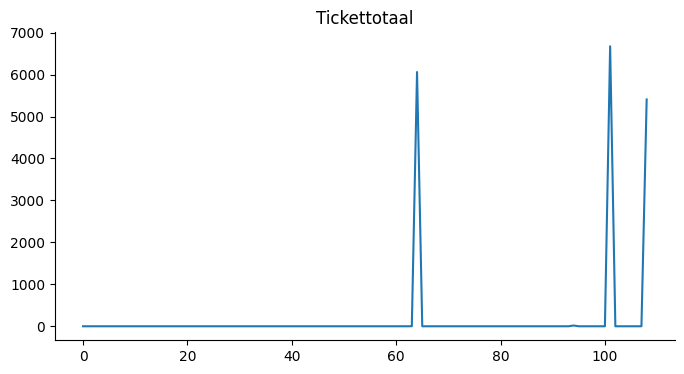

In [ ]:
# -----------------Event Definitie  -------------------
event = ['FESTIVAL', 'EVENEMENT', 'EVENEMENT2']

# -----------------Events filter -------------------
events = Ticket_toegang[Ticket_toegang['Artikelnr.'].isin(event)]
events['datetime'] = pd.to_datetime(
    events['Toelatingsdatum'].astype(str) + ' ' + events['Toelating Uur'].astype(str),
    errors='coerce'
)

events = events.drop(columns=[
    'Toelatingsdatum', 'Toelating Uur', 'Variant',
    'Toelatingstelling (Negatief)', 'Toelating graaf (Re-Entry)',
    'Som Toelating Count', 'Hoogste toegang Entry No.', 'Postnr.',
    'Gegenereerde telling (Pos)', 'Gegenereerde telling (Neg)'
])

# -----------------Ticketaantallen bepalen per uur -------------------
events_uur = events.groupby('datetime')['Toelating Telling'].sum().reset_index()
events_uur = events_uur.rename(columns={'Toelating Telling': 'Tickettotaal'})

# -----------------Omzetten naar dag -------------------
events_dag = events_uur.groupby(events_uur['datetime'].dt.date)['Tickettotaal'].sum().reset_index()
events_dag.columns = ['date', 'Tickettotaal']
events_dag['date'] = pd.to_datetime(events_dag['date'])

# -----------------Plot -------------------
from matplotlib import pyplot as plt
events_dag['Tickettotaal'].plot(kind='line', figsize=(8, 4), title='Tickettotaal')
plt.gca().spines[['top', 'right']].set_visible(False)


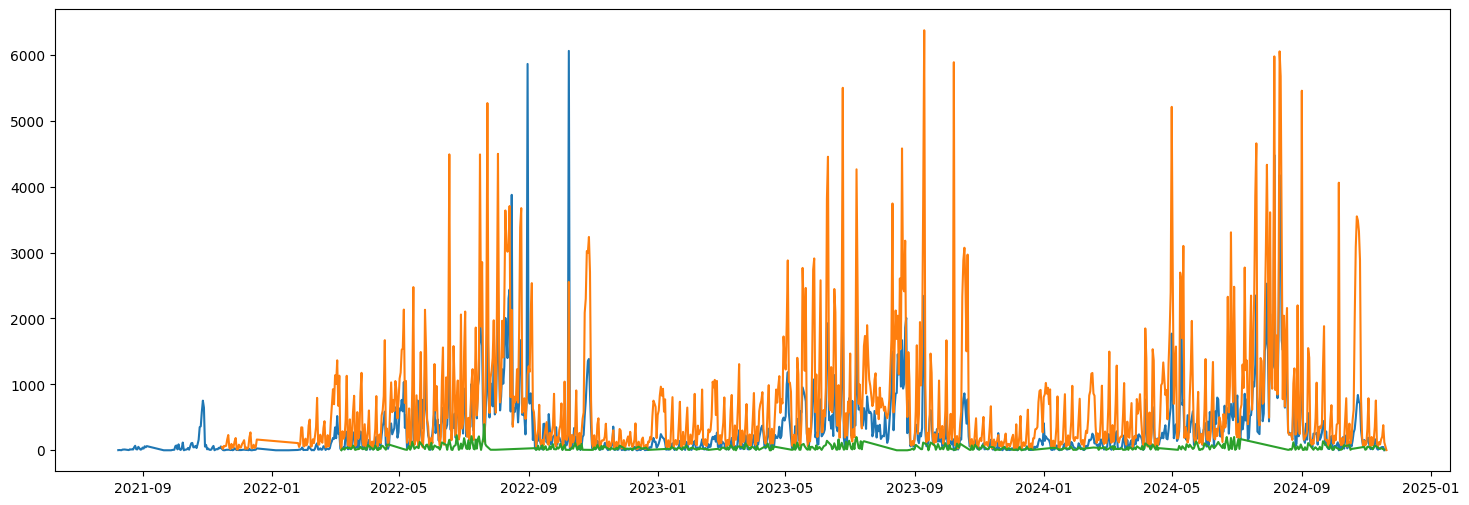

In [ ]:

plt.figure(figsize=(18, 6))
outlier_threshold = 20000
filtered_tickets = Tickets_dag[Tickets_dag['Tickettotaal'] <= outlier_threshold]

# Plot each dataset with a different color and label
plt.plot(filtered_tickets['date'], filtered_tickets['Tickettotaal'], label='Tickets')
plt.plot(Leden_dag['date'], Leden_dag['Tickettotaal'], label='Leden')
plt.plot(kinderfeest_dag['date'], kinderfeest_dag['Tickettotaal'], label='Kinderfee


## 2.2 Lidmaatschappen

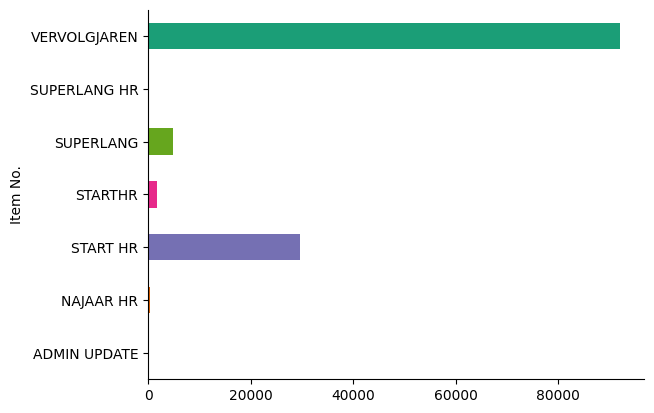

In [ ]:
# Open het Excel bestand
file_path2 = "/content/drive/My Drive/BillyBird/Lidmaatschappen LEX 2025-03-21T09_17_33.xlsx"
Lidmaatschappen = pd.read_excel(file_path2)
Lidmaatschappen.head(2)

Lidmaatschappen.groupby('Item No.').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 2.3 Lid_aankomst

In [ ]:
# Open het Excel bestand
file_path3 = "/content/drive/My Drive/BillyBird/Lid aankomst logboek LEX 2025-03-21T09_35_50.xlsx"
Lid_aankomst = pd.read_excel(file_path3)
Lid_aankomst['Extern lid No.'].value_counts()
Lid_aankomst

KeyboardInterrupt: 

## 2.4 Artikelen & posten

In [ ]:
Artikelen

,Artikelnr.,Omschrijving,Omschrijving 2,Basiseenheid,Kostprijs geherwaardeerd,Kostprijs,ticket Type,Artikel Status,Eenheidsprijs,Adviesprijs,Zoeknaam,Kolom4
0,10PCTBLOASFESTIJN,10pct korting bloasfestijn,NaN,STK,True,0,NaN,STANDAARD,0.0,0.0,10PCT KORTING BLOASFESTIJN,NaN
1,ADMIN UPDATE,Administratieve update memberships voor overga...,NaN,STK,False,0,NaN,STANDAARD,0.0,0.0,ADMINISTRATIEVE UPDATE MEMBERSHIPS VOOR OVERGA...,NaN
2,AQUAFUN-DAGGAST,Ticket AquaFunPark daggast,NaN,STK,False,0,AQUAFUN,STANDAARD,7.5,0.0,TICKET AQUAFUNPARK DAGGAST,NaN
3,AQUAFUN-LID,Ticket AquaFunPark leden en groepen,NaN,STK,False,0,AQUAFUN,STANDAARD,4.0,0.0,TICKET AQUAFUNPARK LEDEN EN GROEPEN,NaN
4,AQUAFUNOBNL,Aquafun Overboeking Niet lid,NaN,STK,False,0,NaN,STANDAARD,7.5,0.0,AQUAFUN OVERBOEKING NIET LID,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1048,START HR,Start Lidmaatschap Hemelrijk,NAAM NIET AANPASSEN!,STK,False,0,NaN,STANDAARD,0.0,0.0,START LIDMAATSCHAP HEMELRIJK,NaN
1049,STARTHR,Startabonnement Hemelrijk,NaN,STK,False,0,NaN,STANDAARD,0.0,0.0,STARTABONNEMENT HEMELRIJK,NaN
1050,SUPERLANG,Superlang lidmaatschap Hemelrijk,NAAM NIET AANPASSEN!,STK,False,0,NaN,STANDAARD,0.0,0.0,SUPERLANG LIDMAATSCHAP HEMELRIJK,NaN
1051,SUPERLANG HR,Superlang lidmaatschap Hemelrijk,NIET AANPASSEN,STK,False,0,NaN,STANDAARD,0.0,0.0,SUPERLANG LIDMAATSCHAP HEMELRIJK,NaN


In [ ]:
# VOOR NU IS ALLEEN GEFILTERD OP ENTREE MAAR ER MOET GEKEKEN WORDEN NAAR:
  # FESTIVAL
  # EVENEMENT

# Drop rijen met Nan voor 'ticket Type'
Artikelen = Artikelen.dropna(subset=['ticket Type'])

# Filter Ticket_toegang_park dataframe to only include rows where 'ticket Type' contains 'ENTREE'
Artikelen_entree = Artikelen[Artikelen['ticket Type'].str.contains('ENTREE')]

Artikelen_entree

,Artikelnr.,Omschrijving,Omschrijving 2,Basiseenheid,Kostprijs geherwaardeerd,Kostprijs,ticket Type,Artikel Status,Eenheidsprijs,Adviesprijs,Zoeknaam,Kolom4
455,ART00452,BEGELEIDER GROEP/KF,NaN,STK,False,0,ENTREE,STANDAARD,0.0,0.0,BEGELEIDER GROEP/KF,NaN
662,ART00660,PARTNERPARK PLOPSA,NaN,STK,False,0,ENTREE,STANDAARD,19.0,0.0,PLOPSA,NaN
663,ART00661,PARTNERPARK BESTZOO,NaN,STK,False,0,ENTREE,STANDAARD,19.0,0.0,BESTZOO,NaN
664,ART00662,PARTNERPARK COSMODROME,NaN,STK,False,0,ENTREE,STANDAARD,19.0,0.0,COSMODROME,NaN
665,ART00663,PARTNERPARK TUINEN VAN APPELTERN,NaN,STK,False,0,ENTREE,STANDAARD,19.0,0.0,APPELTERN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1032,HEMEL-LAAG,Entreeticket Hemelrijk,NAAM NIET AANPASSEN!,STK,False,0,ENTREE,STANDAARD,9.5,0.0,ENTREETICKET HEMELRIJK,NaN
1033,HEMEL-MIDDEN,Entreeticket Hemelrijk,NAAM NIET AANPASSEN!,STK,False,0,ENTREE,STANDAARD,12.5,0.0,ENTREETICKET HEMELRIJK,NaN
1034,KASSA-ENTREE,ENTREETICKET,Voor iedere dag van het jaar,STK,False,0,ENTREE,STANDAARD,19.0,0.0,ENTREELAAG,NaN
1035,LID ENTREE,Entree park voor leden,NaN,STK,False,0,ENTREE,STANDAARD,0.0,0.0,ENTREE PARK VOOR LEDEN,NaN


In [ ]:
# Open het Excel bestand
#file_path4 = "/content/drive/My Drive/BillyBird/Artikelposten LEX 2025-03-21T09_28_52.xlsx"
#Artikelposten = pd.read_excel(file_path4)
#Artikelposten

## 2.5 Kostenplaats

In [ ]:
# Open het Excel bestand
#file_path5 = "/content/drive/My Drive/BillyBird/Kostenplaats.csv"

#Kostenplaats = pd.read_csv(file_path5)
#Kostenplaats



---


# DEEL 03: OUTLIERS

## 3.1 Boxplots

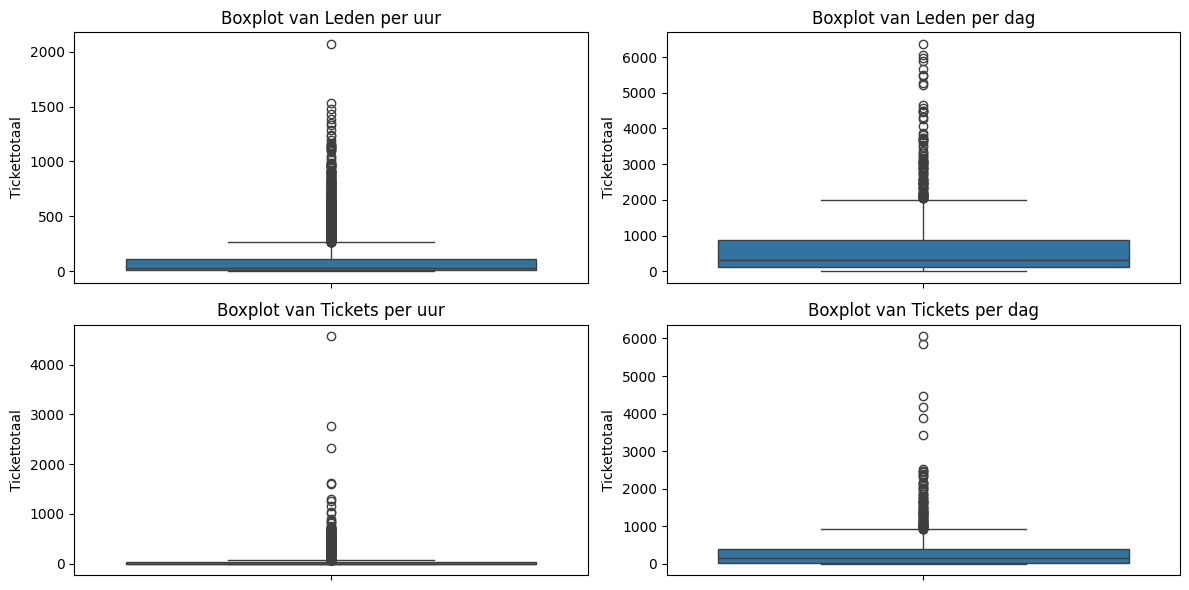

In [ ]:


plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.boxplot(y=Leden_uur['Tickettotaal'])
plt.title('Boxplot van Leden per uur')

plt.subplot(2, 2, 2)
sns.boxplot(y=Leden_dag['Tickettotaal'])
plt.title('Boxplot van Leden per dag')

plt.subplot(2, 2, 3)
sns.boxplot(y=Tickets_uur['Tickettotaal'])
plt.title('Boxplot van Tickets per uur')

plt.subplot(2, 2, 4)
sns.boxplot(y=Tickets_dag['Tickettotaal'])
plt.title('Boxplot van Tickets per dag')

plt.tight_layout()
plt.show()


In [ ]:
Hoogste = Tickets_uur.sort_values(by='Tickettotaal', ascending=False)
Hoogste.head(10)

,datetime,Tickettotaal
4209,2022-08-31 15:00:00,4570
3937,2022-08-16 14:00:00,2766
4708,2022-10-09 14:00:00,2320
13347,2024-08-06 11:00:00,1629
4709,2022-10-09 15:00:00,1595
13452,2024-08-11 11:00:00,1292
8892,2023-08-24 11:00:00,1251
11913,2024-05-10 10:00:00,1166
4707,2022-10-09 13:00:00,1049
13346,2024-08-06 10:00:00,1016


In [ ]:
Hoogste = Leden_uur.sort_values(by='Tickettotaal', ascending=False)
Hoogste.head(10)

,datetime,Tickettotaal
5109,2023-10-08 14:00:00,2072
7516,2024-08-11 11:00:00,1534
4167,2023-06-25 10:00:00,1474
5110,2023-10-08 15:00:00,1428
7988,2024-10-06 14:00:00,1389
4887,2023-09-10 10:00:00,1349
7460,2024-08-06 11:00:00,1331
7459,2024-08-06 10:00:00,1283
4888,2023-09-10 11:00:00,1242
4890,2023-09-10 13:00:00,1235


In [ ]:
values_above_800 = Tickets_dag[Tickets_dag['Tickettotaal'] > 800]['Tickettotaal'].count()
values_below_800 = Tickets_dag[Tickets_dag['Tickettotaal'] < 800]['Tickettotaal'].count()
values_above_2000 = Tickets_dag[Tickets_dag['Tickettotaal'] > 2000]['Tickettotaal'].count()

print(f"Number of values above 800: {values_above_800}")
print(f"Number of values below 800: {values_below_800}")
print(f"Number of values above 2000: {values_above_2000}")


Number of values above 800: 107
Number of values below 800: 1030
Number of values above 2000: 21


## 3.2 Outliers verwijderen

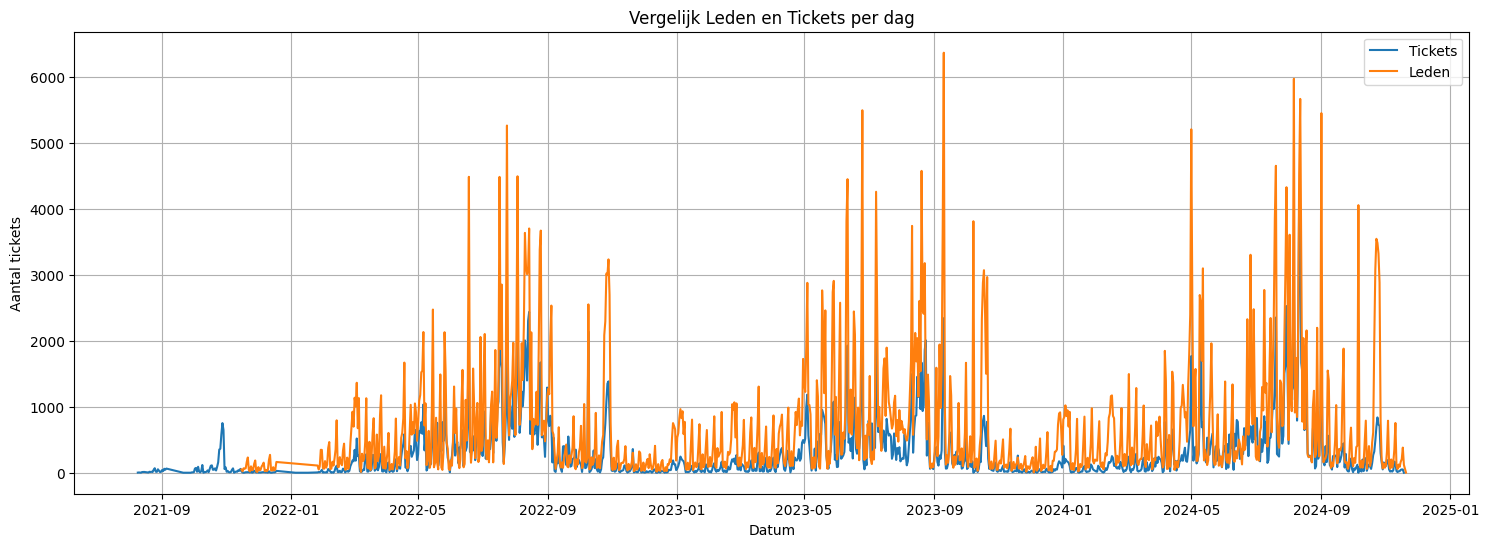

In [ ]:
# -----------------Outliers op uur basis  -------------------
Leden_uur = Leden_uur[Leden_uur['Tickettotaal'] < 1500]

# -----------------Omzetten naar dag -------------------
Leden_dag = Leden_uur.groupby(Leden_uur['datetime'].dt.date)['Tickettotaal'].sum().reset_index()
Leden_dag.columns = ['date', 'Tickettotaal']
Leden_dag['date'] = pd.to_datetime(Leden_dag['date'])

# -----------------Outliers op uur basis  -------------------
Tickets_uur = Tickets_uur[Tickets_uur['Tickettotaal'] < 1500]

# -----------------Omzetten naar dag -------------------
Tickets_dag = Tickets_uur.groupby(Tickets_uur['datetime'].dt.date)['Tickettotaal'].sum().reset_index()
Tickets_dag.columns = ['date', 'Tickettotaal']
Tickets_dag['date'] = pd.to_datetime(Tickets_dag['date'])

# -----------------Plot -------------------
plt.figure(figsize=(18, 6))
plt.plot(Tickets_dag['date'], Tickets_dag['Tickettotaal'], label='Tickets')
plt.plot(Leden_dag['date'], Leden_dag['Tickettotaal'], label='Leden')
plt.xlabel('Datum')
plt.ylabel('Aantal tickets')
plt.title('Vergelijk Leden en Tickets per dag')
plt.legend()
plt.grid(True)
plt.show()


# DEEL 04: SAMENVOEGEN INTERNE EN EXTERNE DATA

## 4.1 Leden

In [ ]:
#------------- Selecteren juist data obv beschikbare toegangsdata en samenvoegen ------------#
Leden_dag_test = Leden_dag
first_date = Leden_dag_test['date'].min()
last_date = Leden_dag_test['date'].max()
hist_leden_dag = External_hist_dta_dag[(External_hist_dta_dag['date'] >= first_date) & (External_hist_dta_dag['date'] <= last_date)]

# Merge
hist_leden_dag = pd.merge(Leden_dag_test, hist_leden_dag, on='date', how='left')
hist_leden_dag ['Tickettotaal'] = pd.to_numeric(hist_leden_dag ['Tickettotaal'], errors='coerce')

# ----------------- Weekdagen binaire maken -------------------
hist_leden_dag['weekdag'] = hist_leden_dag['date'].dt.dayofweek  # Ma=0, Zo=6

# ----------------- Opslaan als excel -------------------
hist_leden_dag.to_excel('hist_leden_dag.xlsx', index=False)

# ----------------- Correlatie  -------------------
# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_leden_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_leden_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

correlaties_met_target = correlation_matrix['Tickettotaal'].sort_values(ascending=False)
print(correlaties_met_target)


Tickettotaal              1.000000
temperatuur               0.517702
vakantie_bin              0.481783
event_impact_num          0.281501
event_bin                 0.251050
weertype_mv_num           0.227895
goed/slecht_weermv_bin    0.225915
weekdag                   0.225143
feestdag_bin              0.139791
maand_nr                  0.007748
onweer_bin               -0.006297
ijsvorming_bin           -0.055489
sneeuw_bin               -0.057907
mist_bin                 -0.075494
neerslag_mm              -0.139649
regen_bin                -0.243952
bewolking_%              -0.250901
Name: Tickettotaal, dtype: float64


## 4.2 Tickets

In [ ]:
#------------- Selecteren juist data obv beschikbare toegangsdata en samenvoegen ------------#
Tickets_dag_test = Tickets_dag
first_date = Tickets_dag_test['date'].min()
last_date = Tickets_dag_test['date'].max()
hist_tickets_dag = External_hist_dta_dag[(External_hist_dta_dag['date'] >= first_date) & (External_hist_dta_dag['date'] <= last_date)]

# Merge
hist_tickets_dag = pd.merge(Tickets_dag_test, hist_tickets_dag, on='date', how='left')
hist_tickets_dag ['Tickettotaal'] = pd.to_numeric(hist_tickets_dag ['Tickettotaal'], errors='coerce')

# ----------------- Weekdagen binaire maken -------------------
hist_tickets_dag['weekdag'] = hist_tickets_dag['date'].dt.dayofweek  # Ma=0, Zo=6

# ----------------- Opslaan als excel -------------------
hist_tickets_dag.to_excel('hist_tickets_dag.xlsx', index=False)

# ----------------- Correlatie  -------------------
# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_tickets_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_tickets_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

correlaties_met_target = correlation_matrix['Tickettotaal'].sort_values(ascending=False)
print(correlaties_met_target)


Tickettotaal              1.000000
temperatuur               0.623764
vakantie_bin              0.415480
goed/slecht_weermv_bin    0.225300
weertype_mv_num           0.220293
weekdag                   0.129367
event_impact_num          0.124619
event_bin                 0.123591
feestdag_bin              0.066225
onweer_bin                0.037976
maand_nr                  0.030151
ijsvorming_bin           -0.047061
sneeuw_bin               -0.062186
mist_bin                 -0.088989
neerslag_mm              -0.111467
regen_bin                -0.234029
bewolking_%              -0.256084
Name: Tickettotaal, dtype: float64


In [ ]:
hist_tickets_dag.to_excel('/content/drive/My Drive/BillyBird/tussendata/hist_tickets_dag.xlsx', index=False)
hist_leden_dag.to_excel('/content/drive/My Drive/BillyBird/tussendata/hist_leden_dag.xlsx', index=False)

# DEEL 05: EXPLORATORY DATA ANALYSIS (DAG)

In [ ]:
hist_tickets_dag = pd.read_excel('/content/drive/My Drive/BillyBird/tussendata/hist_tickets_dag.xlsx')
hist_leden_dag = pd.read_excel('/content/drive/My Drive/BillyBird/tussendata/hist_leden_dag.xlsx')

In [ ]:
hist_tickets_dag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1139 non-null   datetime64[ns]
 1   Tickettotaal             1139 non-null   int64         
 2   temperatuur              1139 non-null   float64       
 3   maand_nr                 1139 non-null   int64         
 4   bewolking_%              1139 non-null   float64       
 5   neerslag_mm              1139 non-null   float64       
 6   regen_bin                1139 non-null   int64         
 7   sneeuw_bin               1139 non-null   int64         
 8   mist_bin                 1139 non-null   int64         
 9   onweer_bin               1139 non-null   int64         
 10  ijsvorming_bin           1139 non-null   int64         
 11  weertype_meestvoorkomen  1139 non-null   object        
 12  vakantietype             1139 non-

## 5.1 Distributie van de target

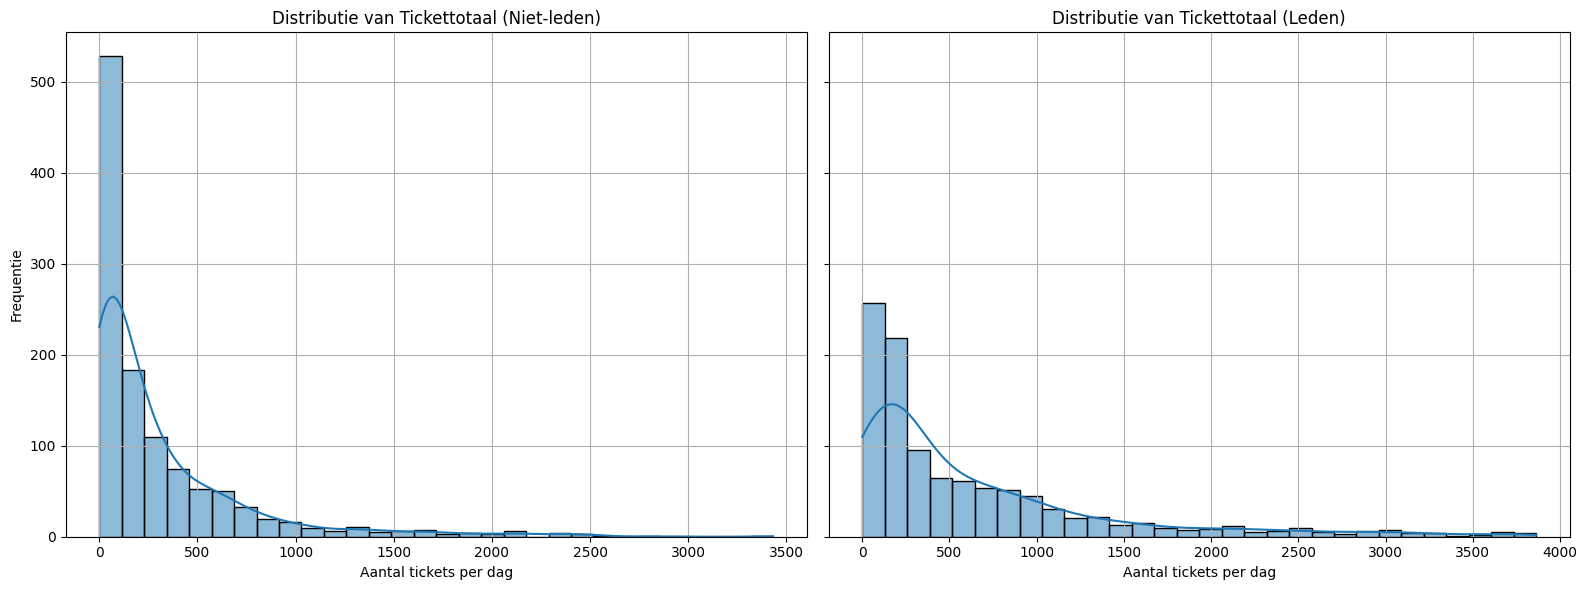

Samenvattende statistieken Niet-leden:
 count    1138.000000
mean      302.616872
std       437.405366
min         0.000000
25%        29.000000
50%       142.500000
75%       383.500000
max      3432.000000
Name: Tickettotaal, dtype: float64 

Samenvattende statistieken Leden:
 count    1047.000000
mean      634.250239
std       752.749876
min         2.000000
25%       132.000000
50%       323.000000
75%       847.000000
max      3862.000000
Name: Tickettotaal, dtype: float64


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Histogram voor Niet-leden
sns.histplot(hist_tickets_dag['Tickettotaal'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distributie van Tickettotaal (Niet-leden)')
axes[0].set_xlabel('Aantal tickets per dag')
axes[0].set_ylabel('Frequentie')
axes[0].grid(True)

# Histogram voor Leden
sns.histplot(hist_leden_dag['Tickettotaal'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distributie van Tickettotaal (Leden)')
axes[1].set_xlabel('Aantal tickets per dag')
axes[1].set_ylabel('Frequentie')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Samenvattende statistieken per groep
print("Samenvattende statistieken Niet-leden:\n", hist_tickets_dag['Tickettotaal'].describe(), '\n')
print("Samenvattende statistieken Leden:\n", hist_leden_dag['Tickettotaal'].describe())


In [ ]:
# Selecteer de top 10 drukste dagen voor niet-leden
drukste_tickets_dagen = hist_tickets_dag.sort_values(by='Tickettotaal', ascending=False).head(10)

# Selecteer de top 10 drukste dagen voor leden
drukste_leden_dagen = hist_leden_dag.sort_values(by='Tickettotaal', ascending=False).head(10)

# Maak één duidelijk overzicht
print('Top 10 drukste dagen - Niet-Leden:\n', drukste_tickets_dagen[['date', 'Tickettotaal']], '\n')
print('Top 10 drukste dagen - Leden:\n', drukste_leden_dagen[['date', 'Tickettotaal']])


Top 10 drukste dagen - Niet-Leden:
            date  Tickettotaal
1038 2024-08-12          3432
1033 2024-08-06          2852
1026 2024-07-30          2529
289  2022-07-24          2467
945  2024-05-10          2458
310  2022-08-14          2440
299  2022-08-03          2394
1016 2024-07-20          2355
702  2023-09-10          2345
309  2022-08-13          2304 

Top 10 drukste dagen - Leden:
            date  Tickettotaal
929  2024-07-19          3862
530  2023-06-10          3817
645  2023-10-08          3816
589  2023-08-11          3745
617  2023-09-09          3732
230  2022-08-14          3706
241  2022-08-25          3674
226  2022-08-10          3639
941  2024-08-02          3611
1019 2024-10-23          3549


## 5.2 Tweede oulier verwerking (optional)

In [ ]:
q1 = hist_tickets_dag['Tickettotaal'].quantile(0.25)
q3 = hist_tickets_dag['Tickettotaal'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

hist_tickets_dag['is_outlier'] = hist_tickets_dag['Tickettotaal'] > upper_bound
print(hist_tickets_dag['is_outlier'].value_counts())


is_outlier
False    1051
True       87
Name: count, dtype: int64


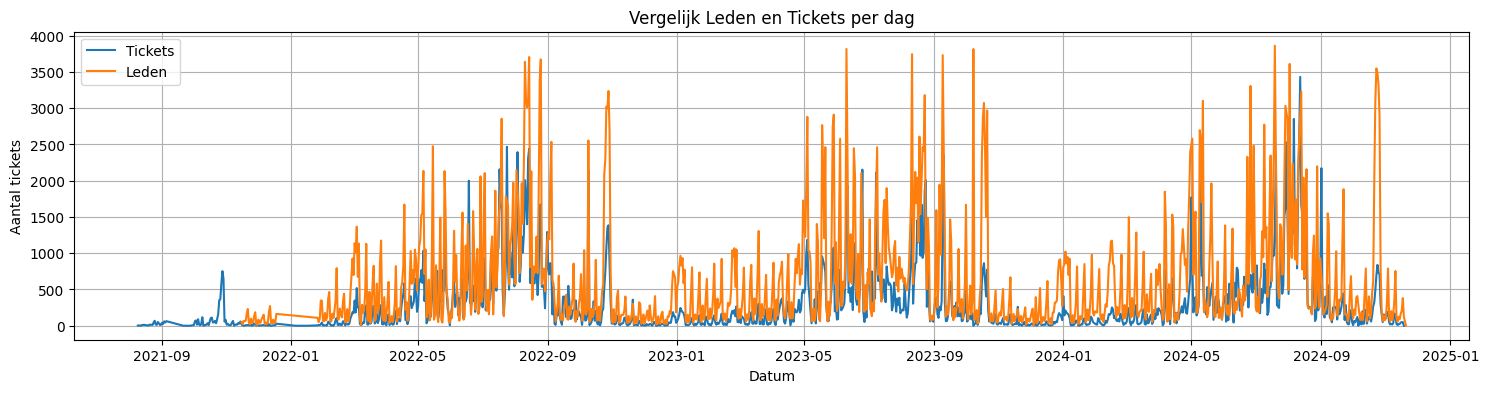

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(Tickets_dag['date'], Tickets_dag['Tickettotaal'], label='Tickets')
plt.plot(Leden_dag['date'], Leden_dag['Tickettotaal'], label='Leden')
plt.xlabel('Datum')
plt.ylabel('Aantal tickets')
plt.title('Vergelijk Leden en Tickets per dag')
plt.legend()
plt.grid(True)
plt.show()

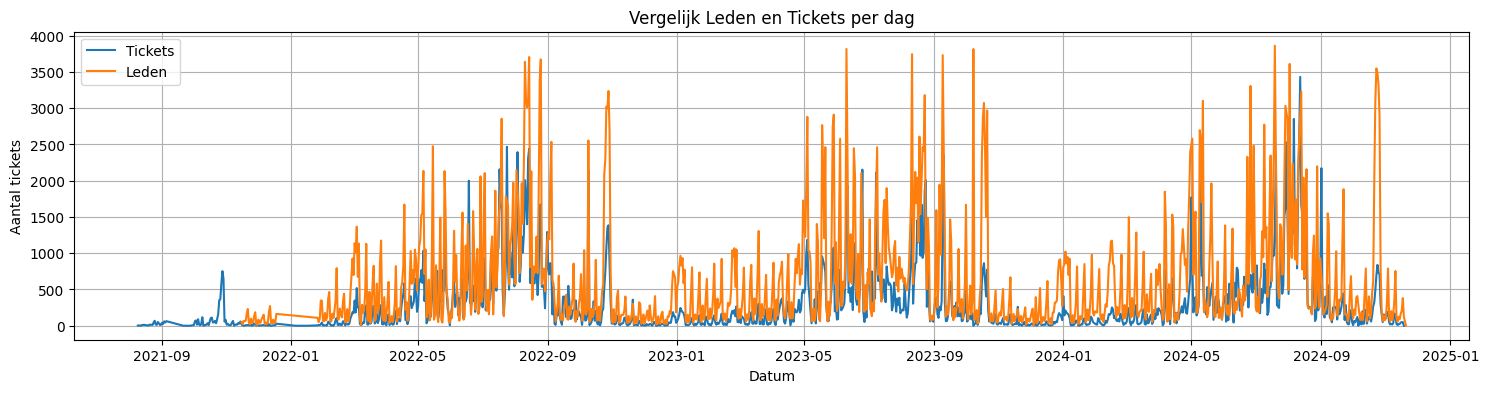

In [ ]:
hist_tickets_dag = hist_tickets_dag[hist_tickets_dag['Tickettotaal'] < 4000]
hist_leden_dag = hist_leden_dag[hist_leden_dag['Tickettotaal'] < 4000]

plt.figure(figsize=(18, 4))
plt.plot(Tickets_dag['date'], Tickets_dag['Tickettotaal'], label='Tickets')
plt.plot(Leden_dag['date'], Leden_dag['Tickettotaal'], label='Leden')
plt.xlabel('Datum')
plt.ylabel('Aantal tickets')
plt.title('Vergelijk Leden en Tickets per dag')
plt.legend()
plt.grid(True)
plt.show()

## 5.3 Periodieke partonen

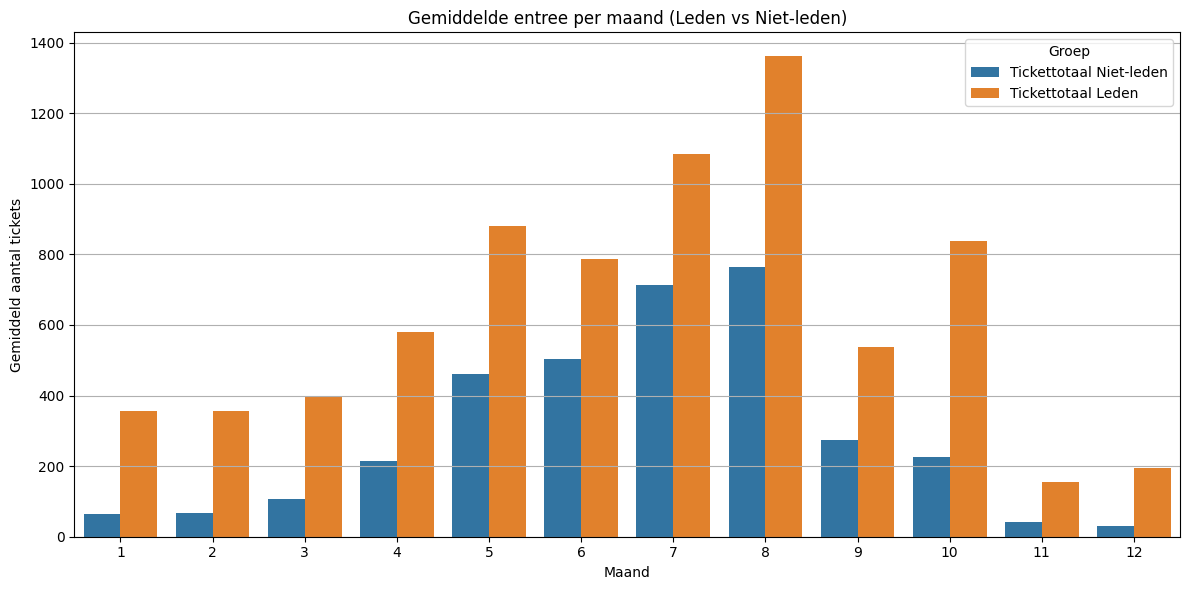

In [ ]:
# Maandgemiddelden berekenen
maandgemiddelde_tickets = hist_tickets_dag.groupby('maand_nr')['Tickettotaal'].mean().reset_index()
maandgemiddelde_leden = hist_leden_dag.groupby('maand_nr')['Tickettotaal'].mean().reset_index()

# Merge beide
df_maand = pd.merge(maandgemiddelde_tickets, maandgemiddelde_leden, on='maand_nr', suffixes=(' Niet-leden', ' Leden'))
df_maand = df_maand.rename(columns={'maand_nr': 'Maand'})

# Omzetten naar lange vorm voor seaborn
df_melted = df_maand.melt(id_vars='Maand', var_name='Groep', value_name='Gemiddeld aantal tickets')

# Plotten
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Maand', y='Gemiddeld aantal tickets', hue='Groep')
plt.title('Gemiddelde entree per maand (Leden vs Niet-leden)')
plt.xlabel('Maand')
plt.ylabel('Gemiddeld aantal tickets')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


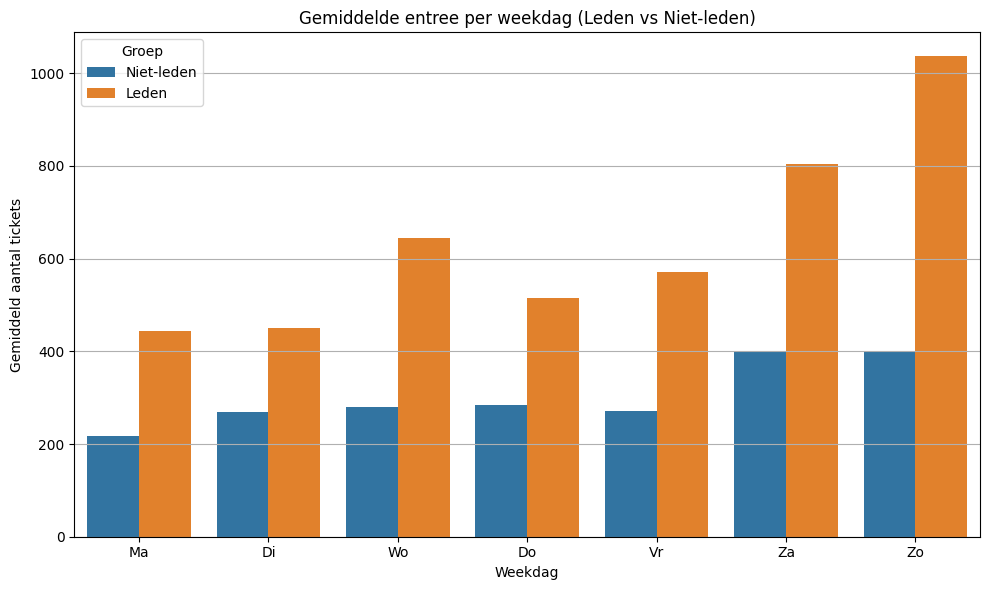

In [ ]:
# Mapping van getallen naar dagen
dag_labels = ['Ma', 'Di', 'Wo', 'Do', 'Vr', 'Za', 'Zo']

# Voeg labels toe op basis van getal
hist_tickets_dag['weekdag_label'] = hist_tickets_dag['weekdag'].map(dict(enumerate(dag_labels)))
hist_leden_dag['weekdag_label'] = hist_leden_dag['weekdag'].map(dict(enumerate(dag_labels)))

# Gemiddelden per dag
weekdag_gem_tickets = hist_tickets_dag.groupby('weekdag_label')['Tickettotaal'].mean().reindex(dag_labels)
weekdag_gem_leden = hist_leden_dag.groupby('weekdag_label')['Tickettotaal'].mean().reindex(dag_labels)

# DataFrame maken
df_weekdag = pd.DataFrame({
    'Weekdag': dag_labels,
    'Niet-leden': weekdag_gem_tickets.values,
    'Leden': weekdag_gem_leden.values
})

# Melten naar lange vorm voor seaborn
df_melted = df_weekdag.melt(id_vars='Weekdag', var_name='Groep', value_name='Gemiddeld aantal tickets')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Weekdag', y='Gemiddeld aantal tickets', hue='Groep')
plt.title('Gemiddelde entree per weekdag (Leden vs Niet-leden)')
plt.xlabel('Weekdag')
plt.ylabel('Gemiddeld aantal tickets')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## 5.4 Vakanties & evenementen

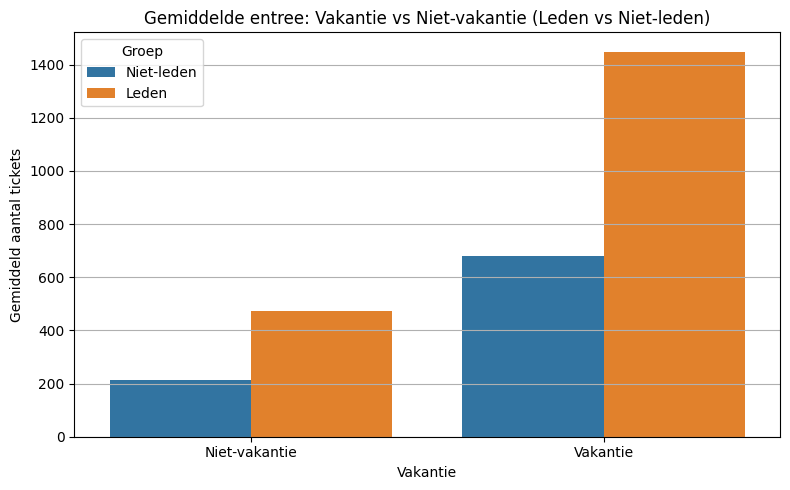

In [ ]:
# Gemiddelde per groep
vakantie_gem_tickets = hist_tickets_dag.groupby('vakantie_bin')['Tickettotaal'].mean()
vakantie_gem_leden = hist_leden_dag.groupby('vakantie_bin')['Tickettotaal'].mean()

# Labels op volgorde zetten (0 = Niet-vakantie, 1 = Vakantie)
labels = ['Niet-vakantie', 'Vakantie']

# DataFrame maken
df_vakantie = pd.DataFrame({
    'Vakantie': labels,
    'Niet-leden': vakantie_gem_tickets.sort_index().values,
    'Leden': vakantie_gem_leden.sort_index().values
})

# Lange vorm voor Seaborn
df_melted = df_vakantie.melt(id_vars='Vakantie', var_name='Groep', value_name='Gemiddeld aantal tickets')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Vakantie', y='Gemiddeld aantal tickets', hue='Groep')
plt.title('Gemiddelde entree: Vakantie vs Niet-vakantie (Leden vs Niet-leden)')
plt.ylabel('Gemiddeld aantal tickets')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


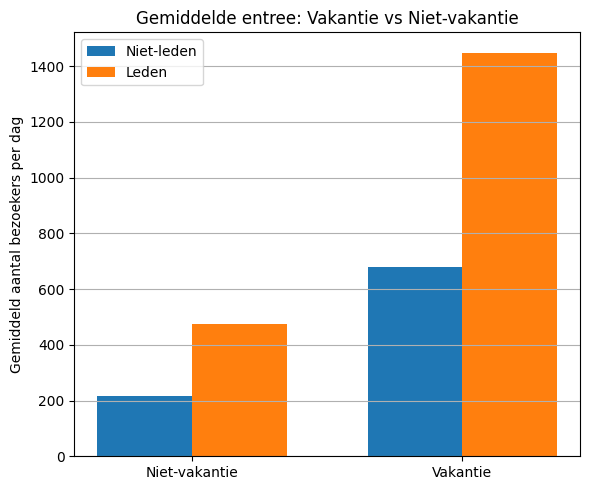

In [ ]:
# Gemiddelde entree per groep
vakantie_gem_tickets = hist_tickets_dag.groupby('vakantie_bin')['Tickettotaal'].mean()
vakantie_gem_leden = hist_leden_dag.groupby('vakantie_bin')['Tickettotaal'].mean()

# Labels
labels = ['Niet-vakantie', 'Vakantie']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

# Plot
plt.figure(figsize=(6, 5))
plt.bar(x - width/2, vakantie_gem_tickets.sort_index().values, width=width, label='Niet-leden')
plt.bar(x + width/2, vakantie_gem_leden.sort_index().values, width=width, label='Leden')

plt.xticks(x, labels)
plt.title('Gemiddelde entree: Vakantie vs Niet-vakantie')
plt.ylabel('Gemiddeld aantal bezoekers per dag')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


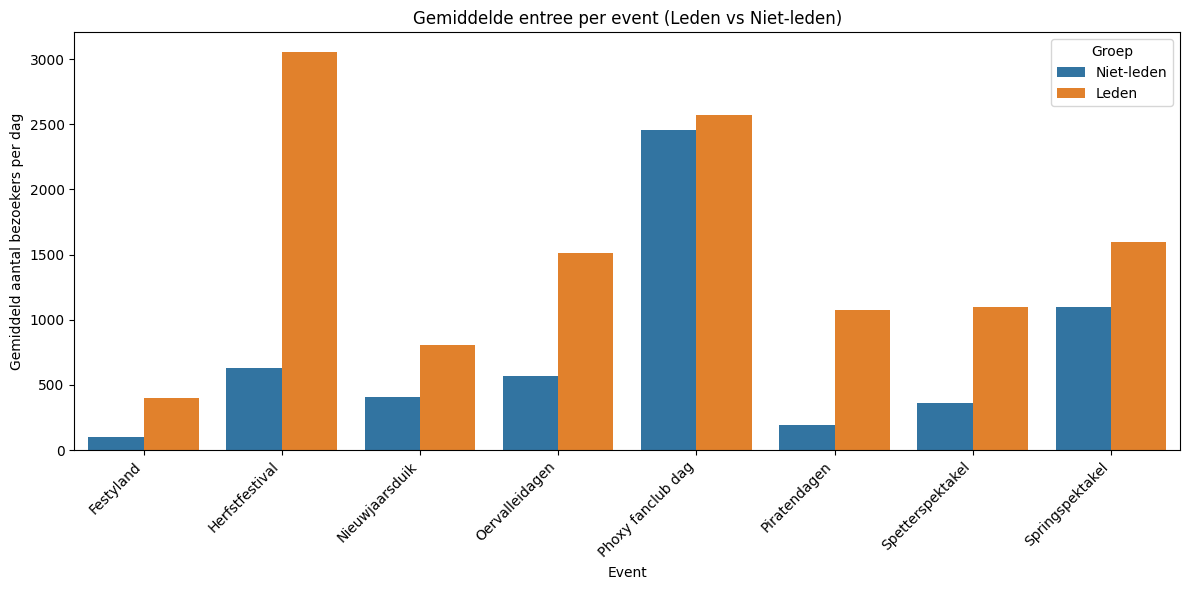

In [ ]:
# Filter "Geen evenement" eruit
tickets_event_data = hist_tickets_dag[hist_tickets_dag['event'] != 'Geen evenement'].copy()
leden_event_data = hist_leden_dag[hist_leden_dag['event'] != 'Geen evenement'].copy()

# Bereken gemiddelden per event
event_gem_tickets = tickets_event_data.groupby('event')['Tickettotaal'].mean().reset_index(name='Niet-leden')
event_gem_leden = leden_event_data.groupby('event')['Tickettotaal'].mean().reset_index(name='Leden')

# Merge en transformeer naar lange vorm
df_event = pd.merge(event_gem_tickets, event_gem_leden, on='event')
df_melted = df_event.melt(id_vars='event', var_name='Groep', value_name='Gemiddelde entree')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='event', y='Gemiddelde entree', hue='Groep')
plt.title('Gemiddelde entree per event (Leden vs Niet-leden)')
plt.xlabel('Event')
plt.ylabel('Gemiddeld aantal bezoekers per dag')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 5.5 Weerinvloeden

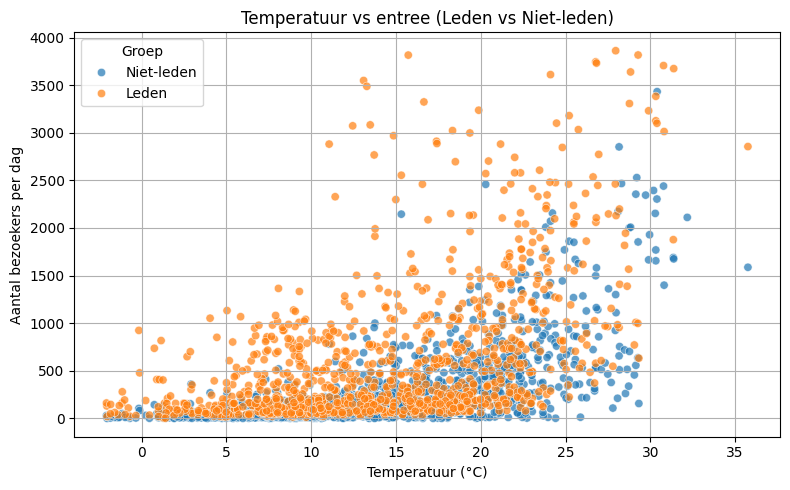

In [ ]:
# Voeg groep toe aan beide datasets
hist_tickets_dag['Groep'] = 'Niet-leden'
hist_leden_dag['Groep'] = 'Leden'

# Combineer beide
temp_data = pd.concat([hist_tickets_dag, hist_leden_dag])

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='temperatuur', y='Tickettotaal', hue='Groep', data=temp_data, alpha=0.7)
plt.title('Temperatuur vs entree (Leden vs Niet-leden)')
plt.xlabel('Temperatuur (°C)')
plt.ylabel('Aantal bezoekers per dag')
plt.grid(True)
plt.tight_layout()
plt.show()


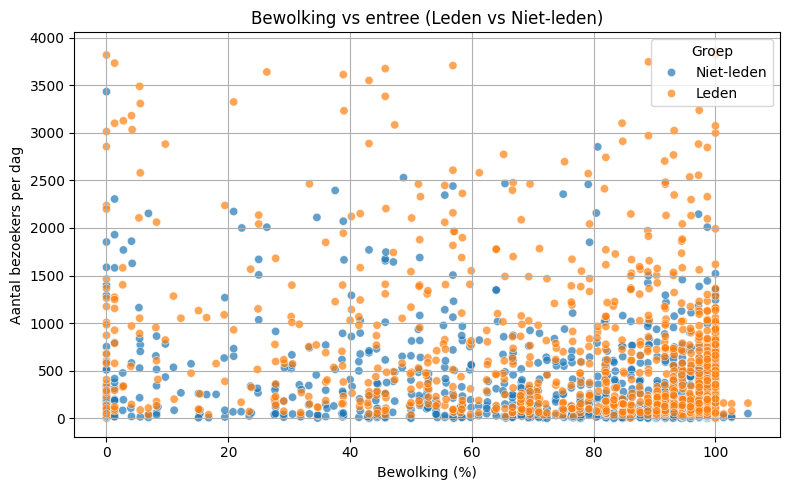

In [ ]:
# Voeg groepslabels toe (indien nog niet gedaan)
hist_tickets_dag['Groep'] = 'Niet-leden'
hist_leden_dag['Groep'] = 'Leden'

# Combineer datasets
cloud_data = pd.concat([hist_tickets_dag, hist_leden_dag])

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='bewolking_%', y='Tickettotaal', hue='Groep', data=cloud_data, alpha=0.7)
plt.title('Bewolking vs entree (Leden vs Niet-leden)')
plt.xlabel('Bewolking (%)')
plt.ylabel('Aantal bezoekers per dag')
plt.grid(True)
plt.tight_layout()
plt.show()

#LATEN WE EVEN CHECKEN OF BEWOLKING WEL TOEPASBAAR IS


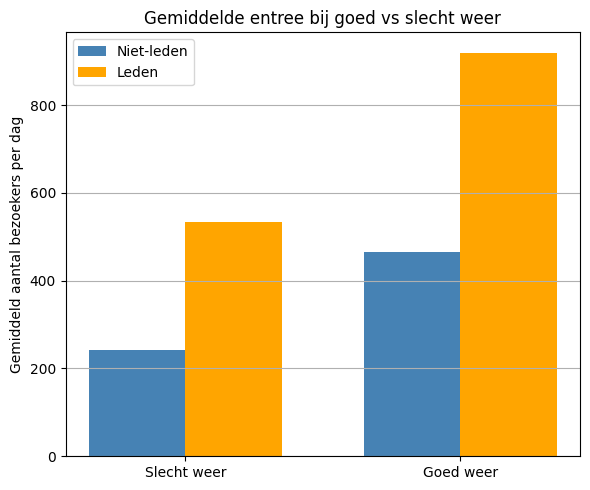

In [ ]:
# Gemiddelde entree bij goed vs slecht weer (0 = slecht, 1 = goed)
gem_tickets = hist_tickets_dag.groupby('goed/slecht_weermv_bin')['Tickettotaal'].mean().sort_index()
gem_leden = hist_leden_dag.groupby('goed/slecht_weermv_bin')['Tickettotaal'].mean().sort_index()

# Labels
labels = ['Slecht weer', 'Goed weer']
x = np.arange(len(labels))
width = 0.35

# Plot
plt.figure(figsize=(6, 5))
plt.bar(x - width/2, gem_tickets.values, width=width, label='Niet-leden', color='steelblue')
plt.bar(x + width/2, gem_leden.values, width=width, label='Leden', color='orange')

plt.xticks(x, labels)
plt.title('Gemiddelde entree bij goed vs slecht weer')
plt.ylabel('Gemiddeld aantal bezoekers per dag')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


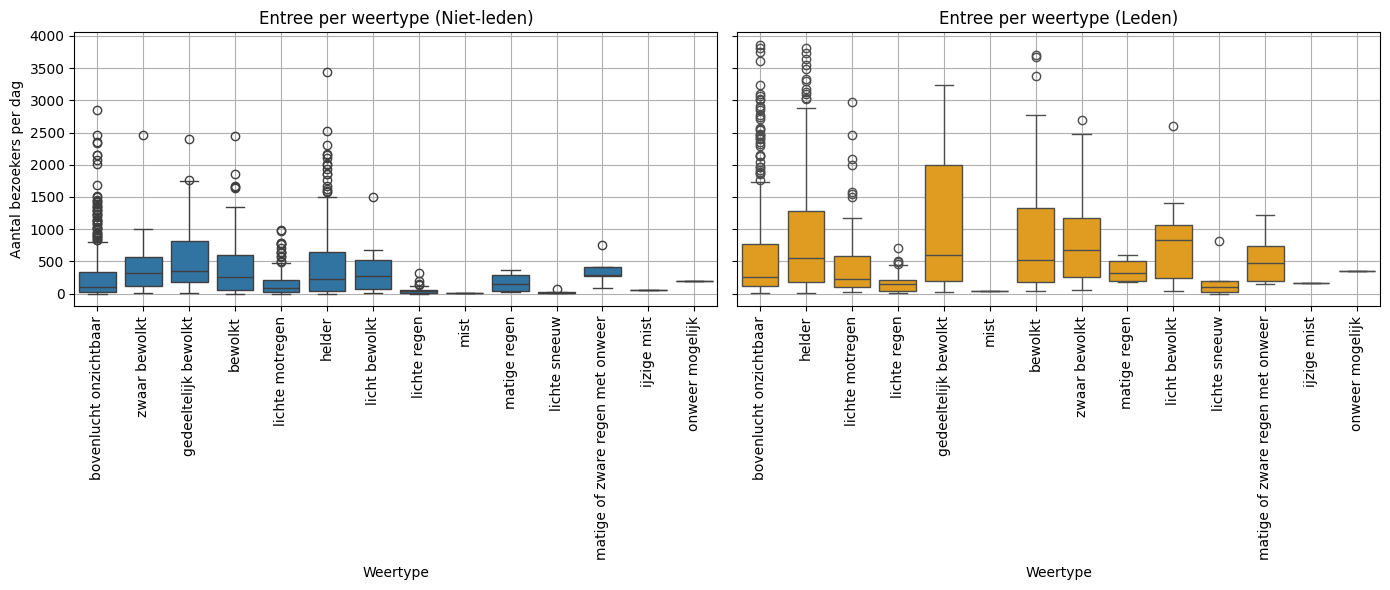

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Niet-leden
sns.boxplot(x='weertype_meestvoorkomen', y='Tickettotaal', data=hist_tickets_dag, ax=axes[0])
axes[0].set_title('Entree per weertype (Niet-leden)')
axes[0].set_xlabel('Weertype')
axes[0].set_ylabel('Aantal bezoekers per dag')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# Leden
sns.boxplot(x='weertype_meestvoorkomen', y='Tickettotaal', data=hist_leden_dag, ax=axes[1], color='orange')
axes[1].set_title('Entree per weertype (Leden)')
axes[1].set_xlabel('Weertype')
axes[1].set_ylabel('Aantal bezoekers per dag')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 5.6 Correlaties & multicolinairity check

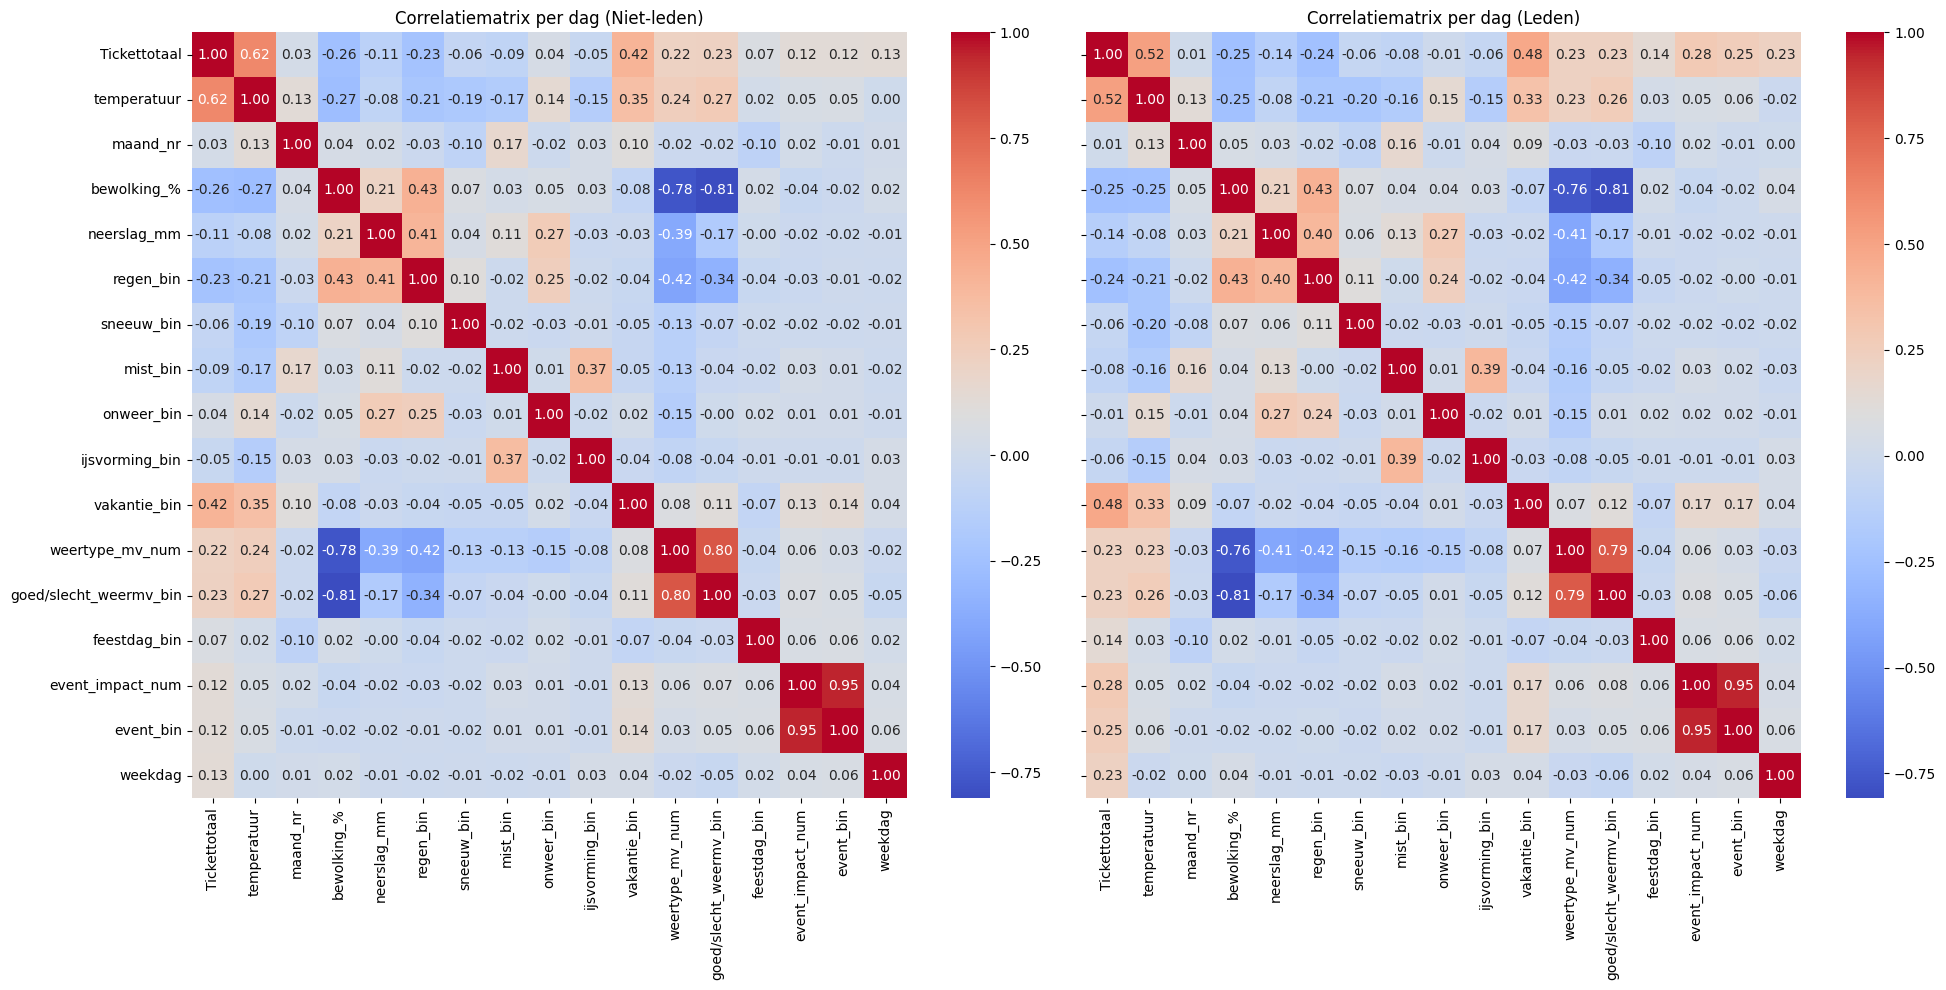

In [ ]:
# Numerieke kolommen selecteren
num_cols_tickets = hist_tickets_dag.select_dtypes(include='number')
num_cols_leden = hist_leden_dag.select_dtypes(include='number')

# Correlatiematrices berekenen
corr_tickets = num_cols_tickets.corr()
corr_leden = num_cols_leden.corr()

# Plot naast elkaar
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Niet-leden
sns.heatmap(corr_tickets, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlatiematrix per dag (Niet-leden)')

# Leden
sns.heatmap(corr_leden, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title('Correlatiematrix per dag (Leden)')

plt.tight_layout()
plt.show()

# DEEL 06: MODEL SELECTIE

In [ ]:
from sklearn.model_selection import train_test_split

# Feature set
features = [
    'temperatuur',
    'vakantie_bin',
    'goed/slecht_weermv_bin',
    'weekdag',
    'weertype_mv_num',
    'maand_nr',
    'event_impact_num'
]

# === Niet-leden ===
X_tickets = hist_tickets_dag[features]
y_tickets = hist_tickets_dag['Tickettotaal']

X_tickets_train, X_tickets_test, y_tickets_train, y_tickets_test = train_test_split(
    X_tickets, y_tickets, test_size=0.15, random_state=42
)

# === Leden ===
X_leden = hist_leden_dag[features]
y_leden = hist_leden_dag['Tickettotaal']

X_leden_train, X_leden_test, y_leden_train, y_leden_test = train_test_split(
    X_leden, y_leden, test_size=0.15, random_state=42
)


## 6.1 Multilinair regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# === Niet-leden ===
model_tickets = LinearRegression()
model_tickets.fit(X_tickets_train, y_tickets_train)
y_pred_tickets = model_tickets.predict(X_tickets_test)
mae_tickets = mean_absolute_error(y_tickets_test, y_pred_tickets)
r2_tickets = r2_score(y_tickets_test, y_pred_tickets)

print("Lineaire Regressie Resultaten (Niet-leden):")
print(f"MAE: {mae_tickets:.2f}")
print(f"R²-score: {r2_tickets:.3f}\n")

# === Leden ===
model_leden = LinearRegression()
model_leden.fit(X_leden_train, y_leden_train)
y_pred_leden = model_leden.predict(X_leden_test)
mae_leden = mean_absolute_error(y_leden_test, y_pred_leden)
r2_leden = r2_score(y_leden_test, y_pred_leden)

print("Lineaire Regressie Resultaten (Leden):")
print(f"MAE: {mae_leden:.2f}")
print(f"R²-score: {r2_leden:.3f}")


Lineaire Regressie Resultaten (Niet-leden):
MAE: 173.76
R²-score: 0.497

Lineaire Regressie Resultaten (Leden):
MAE: 406.38
R²-score: 0.487


## 6.2 Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
# === Niet-leden ===
model_rf_tickets = RandomForestRegressor(n_estimators=500, random_state=42)
model_rf_tickets.fit(X_tickets_train, y_tickets_train)
y_pred_rf_tickets = model_rf_tickets.predict(X_tickets_test)

mae_rf_tickets = mean_absolute_error(y_tickets_test, y_pred_rf_tickets)
r2_rf_tickets = r2_score(y_tickets_test, y_pred_rf_tickets)

print("Random Forest Resultaten (Niet-leden):")
print(f"MAE: {mae_rf_tickets:.2f}")
print(f"R²-score: {r2_rf_tickets:.3f}\n")

# === Leden ===
model_rf_leden = RandomForestRegressor(n_estimators=500, random_state=42)
model_rf_leden.fit(X_leden_train, y_leden_train)
y_pred_rf_leden = model_rf_leden.predict(X_leden_test)

mae_rf_leden = mean_absolute_error(y_leden_test, y_pred_rf_leden)
r2_rf_leden = r2_score(y_leden_test, y_pred_rf_leden)

print("Random Forest Resultaten (Leden):")
print(f"MAE: {mae_rf_leden:.2f}")
print(f"R²-score: {r2_rf_leden:.3f}")


Random Forest Resultaten (Niet-leden):
MAE: 120.84
R²-score: 0.659

Random Forest Resultaten (Leden):
MAE: 231.49
R²-score: 0.770


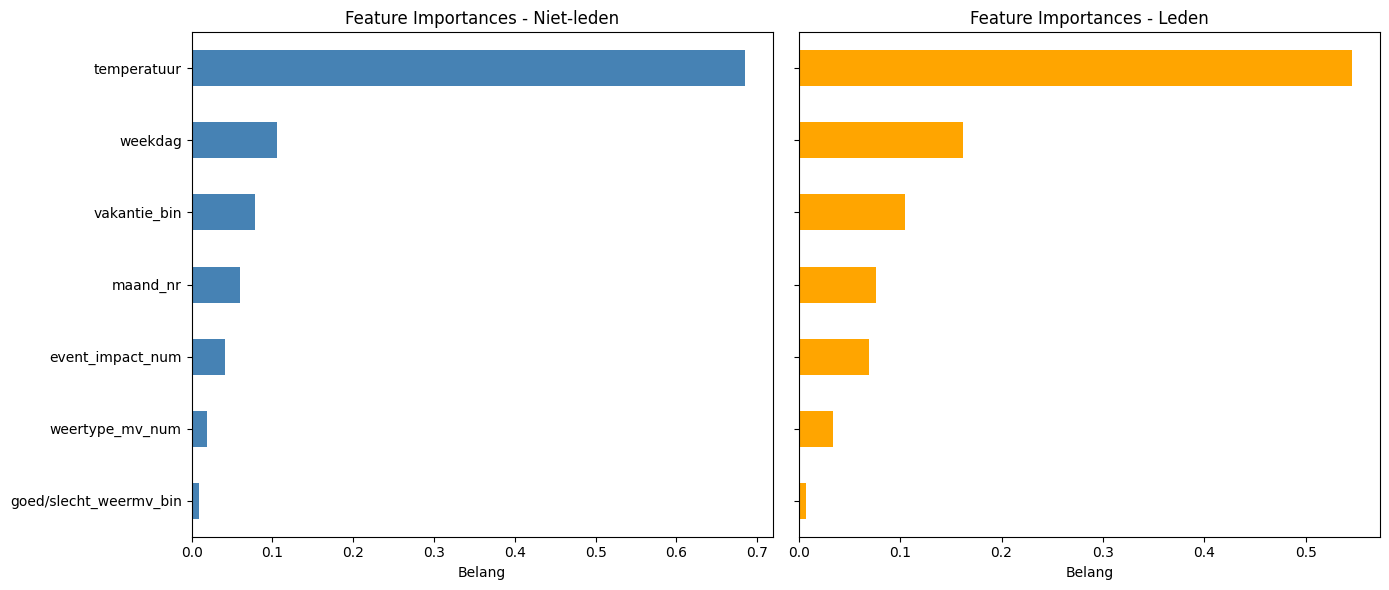

In [ ]:
# Feature importances ophalen
importances_tickets = pd.Series(model_rf_tickets.feature_importances_, index=features)
importances_leden = pd.Series(model_rf_leden.feature_importances_, index=features)

# Plot naast elkaar
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Niet-leden
importances_tickets.sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Feature Importances - Niet-leden')
axes[0].set_xlabel('Belang')

# Leden
importances_leden.sort_values().plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Feature Importances - Leden')
axes[1].set_xlabel('Belang')

plt.tight_layout()
plt.show()


## 6.3 XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# === Niet-leden ===
model_xgb_tickets = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb_tickets.fit(X_tickets_train, y_tickets_train)
y_pred_xgb_tickets = model_xgb_tickets.predict(X_tickets_test)

mae_xgb_tickets = mean_absolute_error(y_tickets_test, y_pred_xgb_tickets)
r2_xgb_tickets = r2_score(y_tickets_test, y_pred_xgb_tickets)

print("XGBoost Resultaten (Niet-leden):")
print(f"MAE: {mae_xgb_tickets:.2f}")
print(f"R²-score: {r2_xgb_tickets:.3f}\n")

# === Leden ===
model_xgb_leden = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb_leden.fit(X_leden_train, y_leden_train)
y_pred_xgb_leden = model_xgb_leden.predict(X_leden_test)

mae_xgb_leden = mean_absolute_error(y_leden_test, y_pred_xgb_leden)
r2_xgb_leden = r2_score(y_leden_test, y_pred_xgb_leden)

print("XGBoost Resultaten (Leden):")
print(f"MAE: {mae_xgb_leden:.2f}")
print(f"R²-score: {r2_xgb_leden:.3f}")


XGBoost Resultaten (Niet-leden):
MAE: 120.98
R²-score: 0.664

XGBoost Resultaten (Leden):
MAE: 234.80
R²-score: 0.760


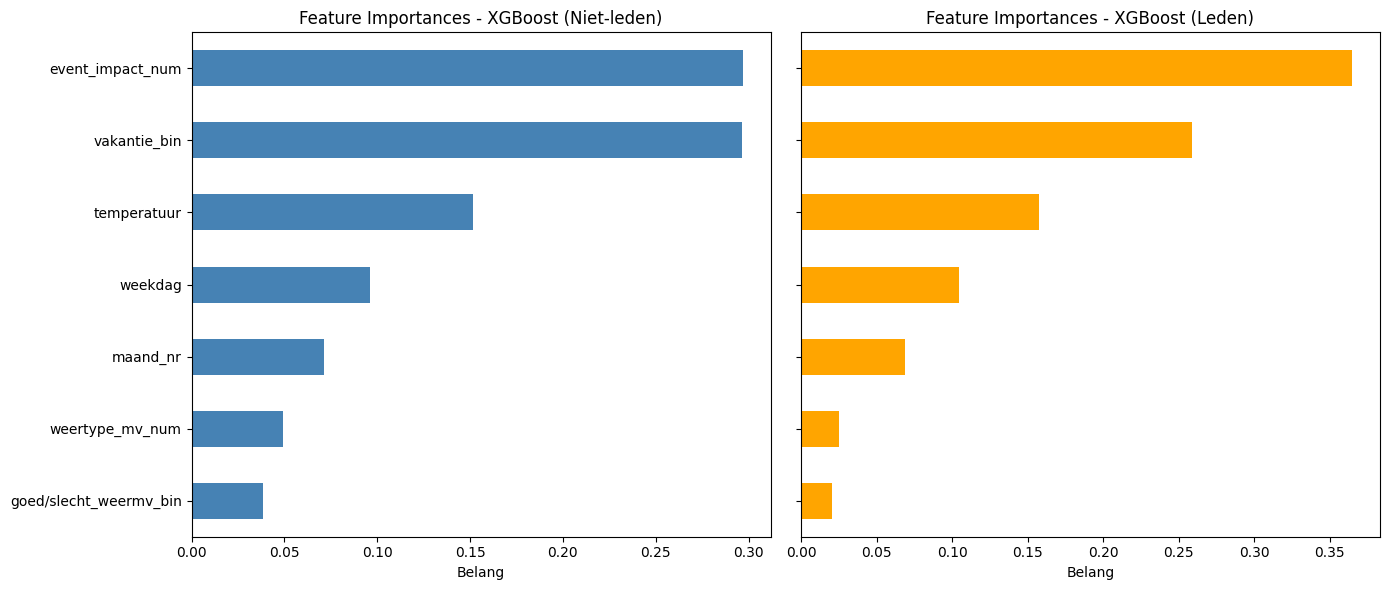

In [ ]:
# Feature importances ophalen
importances_xgb_tickets = pd.Series(model_xgb_tickets.feature_importances_, index=features)
importances_xgb_leden = pd.Series(model_xgb_leden.feature_importances_, index=features)

# Plot naast elkaar
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Niet-leden
importances_xgb_tickets.sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Feature Importances - XGBoost (Niet-leden)')
axes[0].set_xlabel('Belang')

# Leden
importances_xgb_leden.sort_values().plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Feature Importances - XGBoost (Leden)')
axes[1].set_xlabel('Belang')

plt.tight_layout()
plt.show()


We gaan voor XGboost, deze wertk net als random forest best goed maar werkt beter bij hoge pieken.

# DEEL 07: MODEL OPTIMALIZATION

## 7.1 Features engineering

In [ ]:
for df in [hist_tickets_dag, hist_leden_dag]:
    df.sort_values('date', inplace=True)

    # Verkoop vorige dag
    df['tickets_gisteren'] = df['Tickettotaal'].shift(1)

    # Voortschrijdend gemiddelde/max (met shift)
    df['rolling_mean_3dagen'] = df['Tickettotaal'].rolling(window=3).mean()
    df['rolling_max_3dagen'] = df['Tickettotaal'].shift(1).rolling(window=3).max()

    # Weekend indicator
    df['weekend_bin'] = df['weekdag'].isin([5, 6]).astype(int)

    # Vakantietype binaire codering
    df['vakantietype_bin'] = 0
    df.loc[df['vakantietype'] == 'Zomervakantie', 'vakantietype_bin'] = 1
    df.loc[df['vakantietype'] == 'Herfstvakantie', 'vakantietype_bin'] = 2
    df.loc[df['vakantietype'] == 'Voorjaarsvakantie', 'vakantietype_bin'] = 3

    # Interactietermen
    df['vakantie_en_goed_weer'] = df['vakantie_bin'] * df['goed/slecht_weermv_bin']
    df['event_weer_interactie'] = df['event_impact_num'] * df['goed/slecht_weermv_bin']
    df['temperatuur_weekend_interactie'] = df['temperatuur'] * df['weekend_bin']
    df['rolling_vakantie_interactie'] = df['rolling_mean_3dagen'] * df['vakantie_bin']

    # Schooldag indicator
    df['schooldag_bin'] = (
        ((df['weekdag'] >= 0) & (df['weekdag'] <= 4)) &
        (df['vakantie_bin'] == 0) &
        (df['feestdag_bin'] == 0)
    ).astype(int)

# Sample weights (optioneel, pas toe op het geheel of apart per groep)
sample_weights_tickets = hist_tickets_dag['Tickettotaal'] / hist_tickets_dag['Tickettotaal'].mean()
sample_weights_leden = hist_leden_dag['Tickettotaal'] / hist_leden_dag['Tickettotaal'].mean()

# Drop NA's waar nodig (bijvoorbeeld na shift/rolling)
hist_tickets_dag.dropna(subset=['tickets_gisteren', 'rolling_mean_3dagen'], inplace=True)
hist_leden_dag.dropna(subset=['tickets_gisteren', 'rolling_mean_3dagen'], inplace=True)

hist_tickets_dag.to_excel('/content/drive/My Drive/BillyBird/tussendata/hist_tickets_dag.xlsx', index=False)
hist_leden_dag.to_excel('/content/drive/My Drive/BillyBird/tussendata/hist_leden_dag.xlsx', index=False)


## 7.2 Optimale features simuleren (Niet runnen)

In [ ]:
# ----------------- Correlatie  -------------------
# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_leden_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_leden_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

correlaties_met_target = correlation_matrix['Tickettotaal'].sort_values(ascending=False)

#Show alleen correlaties hoger dan 0.2 of lager dan -0.2
correlaties_met_target = correlaties_met_target[(correlaties_met_target > 0.2) | (correlaties_met_target < -0.2)]
print(correlaties_met_target)

Tickettotaal                      1.000000
rolling_mean_3dagen               0.769660
rolling_vakantie_interactie       0.576038
temperatuur                       0.541944
tickets_gisteren                  0.541205
vakantie_bin                      0.440808
temperatuur_weekend_interactie    0.423215
rolling_max_3dagen                0.399564
vakantie_en_goed_weer             0.382997
vakantietype_bin                  0.336531
event_impact_num                  0.262581
weertype_mv_num                   0.255247
weekend_bin                       0.252015
event_weer_interactie             0.243490
goed/slecht_weermv_bin            0.239765
event_bin                         0.235834
weekdag                           0.228249
regen_bin                        -0.255638
bewolking_%                      -0.288244
schooldag_bin                    -0.503636
Name: Tickettotaal, dtype: float64


In [ ]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import tqdm

# === FEATURE COMBINATIE TESTING SETTINGS (Leden) ===
test_feature_candidates = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'tickets_gisteren',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'vakantie_en_goed_weer',
    'rolling_max_3dagen',
    'vakantietype_bin',
    'weekend_bin',
    'weekdag',
    'event_impact_num',
    'weertype_mv_num',
    'event_weer_interactie',
    'regen_bin',
    'bewolking_%',
    'schooldag_bin'
]

target_variable = "Tickettotaal"
max_test_features = 12  # Max aantal features per combinatie

# === TRAIN-TEST SPLIT VOOR LEDEN ===
train_data_ftest, test_data_ftest = train_test_split(hist_leden_dag, test_size=0.2, random_state=42)

# === RESULTAAT OPSLAG ===
feature_test_results = []

# === COMBINATIES TESTEN ===
for r in range(5, max_test_features + 1):
    for subset in tqdm.tqdm(list(combinations(test_feature_candidates, r)), desc=f"Test combinaties van {r} features"):
        X_train_ftest = train_data_ftest[list(subset)]
        y_train_ftest = train_data_ftest[target_variable]
        X_test_ftest = test_data_ftest[list(subset)]
        y_test_ftest = test_data_ftest[target_variable]

        model_ftest = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
        model_ftest.fit(X_train_ftest, y_train_ftest)
        y_pred_ftest = model_ftest.predict(X_test_ftest)

        mae = mean_absolute_error(y_test_ftest, y_pred_ftest)
        rmse = np.sqrt(mean_squared_error(y_test_ftest, y_pred_ftest))
        r2 = r2_score(y_test_ftest, y_pred_ftest)

        feature_test_results.append({
            "features": subset,
            "n_features": r,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# === RESULTAAT OVERZICHT ===
feature_test_df = pd.DataFrame(feature_test_results)
top5_feature_sets = feature_test_df.sort_values(by="RMSE").head(10)

print("Top 10 featurecombinaties voor model performance (Leden, laagste RMSE):")
print(top5_feature_sets[["features", "RMSE", "MAE", "R2"]])


In [ ]:
# ----------------- Correlatie  -------------------
# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_tickets_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

# Selecteer de numerieke kolommen voor de correlatiematrix
numerical_cols = hist_tickets_dag.select_dtypes(include=['number'])

# Bereken de correlatiematrix
correlation_matrix = numerical_cols.corr()

correlaties_met_target = correlation_matrix['Tickettotaal'].sort_values(ascending=False)
#Show alleen correlaties hoger dan 0.2 of lager dan -0.2
correlaties_met_target = correlaties_met_target[(correlaties_met_target > 0.2) | (correlaties_met_target < -0.2)]

print(correlaties_met_target)

Tickettotaal                      1.000000
rolling_mean_3dagen               0.849937
tickets_gisteren                  0.686583
rolling_vakantie_interactie       0.677012
temperatuur                       0.616274
rolling_max_3dagen                0.611276
vakantie_bin                      0.420854
vakantie_en_goed_weer             0.385064
temperatuur_weekend_interactie    0.341822
vakantietype_bin                  0.270102
goed/slecht_weermv_bin            0.229524
weertype_mv_num                   0.227112
regen_bin                        -0.232167
bewolking_%                      -0.265684
schooldag_bin                    -0.384198
Name: Tickettotaal, dtype: float64


In [ ]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import tqdm

# === FEATURE CANDIDATES OP BASIS VAN CORRELATIES (Niet-leden) ===
test_feature_candidates = [
    'rolling_mean_3dagen',
    'tickets_gisteren',
    'rolling_max_3dagen',
    'temperatuur',
    'rolling_vakantie_interactie',
    'vakantie_bin',
    'vakantie_en_goed_weer',
    'vakantietype_bin',
    'temperatuur_weekend_interactie',
    'bewolking_%',
    'schooldag_bin'
]

target_variable = "Tickettotaal"
min_test_features = 5
max_test_features = 10  # of 11 als je alles wil testen

# === TRAIN-TEST SPLIT VOOR NIET-LEDEN ===
train_data_ftest, test_data_ftest = train_test_split(hist_tickets_dag, test_size=0.2, random_state=42)

# === RESULTAAT OPSLAG ===
feature_test_results = []

# === COMBINATIES TESTEN ===
for r in range(min_test_features, max_test_features + 1):
    for subset in tqdm.tqdm(list(combinations(test_feature_candidates, r)), desc=f"Test combinaties van {r} features"):
        X_train_ftest = train_data_ftest[list(subset)]
        y_train_ftest = train_data_ftest[target_variable]
        X_test_ftest = test_data_ftest[list(subset)]
        y_test_ftest = test_data_ftest[target_variable]

        model_ftest = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
        model_ftest.fit(X_train_ftest, y_train_ftest)
        y_pred_ftest = model_ftest.predict(X_test_ftest)

        mae = mean_absolute_error(y_test_ftest, y_pred_ftest)
        rmse = np.sqrt(mean_squared_error(y_test_ftest, y_pred_ftest))
        r2 = r2_score(y_test_ftest, y_pred_ftest)

        feature_test_results.append({
            "features": subset,
            "n_features": r,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# === RESULTAAT OVERZICHT ===
feature_test_df = pd.DataFrame(feature_test_results)
top5_feature_sets = feature_test_df.sort_values(by="RMSE").head(10)

print("Top 10 featurecombinaties voor niet-leden (laagste RMSE):")
print(top5_feature_sets[["features", "RMSE", "MAE", "R2"]])


## 7.1 Hyperparameters (gridsearch)

In [ ]:
from sklearn.model_selection import train_test_split

# === Feature selectie ===
features_leden = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

features_tickets = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

# === Leden ===
X_leden = hist_leden_dag[features_leden]
y_leden = hist_leden_dag['Tickettotaal']

X_leden_train, X_leden_test, y_leden_train, y_leden_test = train_test_split(
    X_leden, y_leden, test_size=0.2, random_state=42
)

# === Niet-leden (tickets) ===
X_tickets = hist_tickets_dag[features_tickets]
y_tickets = hist_tickets_dag['Tickettotaal']

X_tickets_train, X_tickets_test, y_tickets_train, y_tickets_test = train_test_split(
    X_tickets, y_tickets, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Parametergrid specifiek voor XGBoost
param_grid_xgb = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# === GridSearch Niet-leden ===
grid_xgb_tickets = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb_tickets.fit(X_tickets_train, y_tickets_train,
                     sample_weight=sample_weights_tickets.loc[X_tickets_train.index])

print("Beste XGBoost-parameters (Niet-leden):", grid_xgb_tickets.best_params_)

# === GridSearch Leden ===
grid_xgb_leden = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb_leden.fit(X_leden_train, y_leden_train,
                   sample_weight=sample_weights_leden.loc[X_leden_train.index])

print("Beste XGBoost-parameters (Leden):", grid_xgb_leden.best_params_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


KeyboardInterrupt: 

## 7.4 Optimaal XGBOOST model

In [ ]:
hist_tickets_dag = pd.read_excel('/content/drive/My Drive/BillyBird/tussendata/hist_tickets_dag.xlsx')
hist_leden_dag = pd.read_excel('/content/drive/My Drive/BillyBird/tussendata/hist_leden_dag.xlsx')

In [ ]:
hist_tickets_dag.weertype_meestvoorkomen.value_counts()

,count
weertype_meestvoorkomen,
bovenlucht onzichtbaar,572
lichte motregen,173
helder,145
bewolkt,103
zwaar bewolkt,43
gedeeltelijk bewolkt,36
lichte regen,25
licht bewolkt,21
matige of zware regen met onweer,5



🔍 Niet-leden:
R² (train): 0.995
R² (test): 0.870
MAE: 82.57
RMSE: 162.27
MAPE >500: 20.99%

🔍 Leden:
R² (train): 0.997
R² (test): 0.816
MAE: 141.79
RMSE: 258.63
MAPE >500: 27.84%


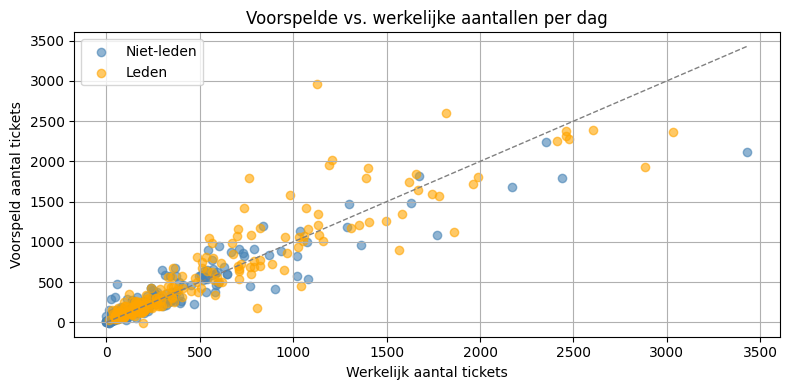

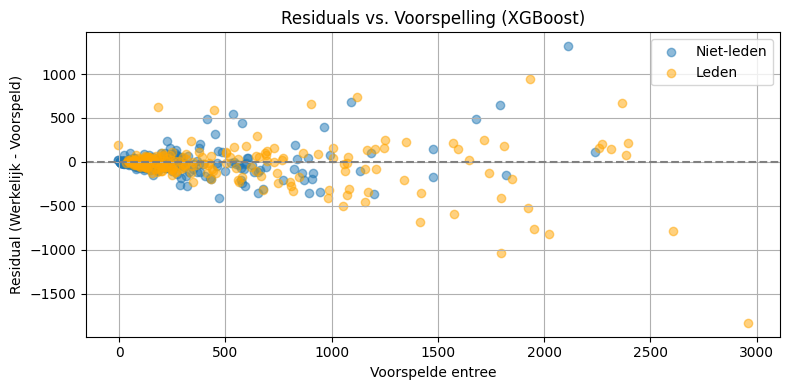

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === Feature selectie ===
features = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

features = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

# === Sample weight strategie ===
def gewicht_custom(x):
  return np.log1p(x)

    #if x > 2500:
        #return 6
    #elif x > 2000:
        #return 4
    #elif x > 1500:
        #return 3
    #else:
        #return 1
    #return np.sqrt(x)

# === Voorbereiding: niet-leden
hist_tickets_dag = hist_tickets_dag.reset_index(drop=True)
X_tickets = hist_tickets_dag[features]
y_tickets = hist_tickets_dag['Tickettotaal']
weights_tickets = hist_tickets_dag['Tickettotaal'].apply(gewicht_custom)

X_tickets_train, X_tickets_test, y_tickets_train, y_tickets_test, w_tickets_train, w_tickets_test = train_test_split(
    X_tickets, y_tickets, weights_tickets, test_size=0.2, random_state=42
)

# === Model trainen: niet-leden
model_tickets = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7,
                             subsample=0.8, colsample_bytree=1.0, objective='reg:absoluteerror', random_state=42)
model_tickets.fit(X_tickets_train, y_tickets_train, sample_weight=w_tickets_train)

# === Evaluatie: niet-leden
y_pred_tickets = model_tickets.predict(X_tickets_test)
results_tickets = pd.DataFrame({'werkelijk': y_tickets_test, 'voorspeld': y_pred_tickets})
results_tickets['abs_fout'] = abs(results_tickets['werkelijk'] - results_tickets['voorspeld'])

print("\n🔍 Niet-leden:")
print(f"R² (train): {model_tickets.score(X_tickets_train, y_tickets_train):.3f}")
print(f"R² (test): {r2_score(y_tickets_test, y_pred_tickets):.3f}")
print(f"MAE: {mean_absolute_error(y_tickets_test, y_pred_tickets):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_tickets_test, y_pred_tickets)):.2f}")
print(f"MAPE >500: {((results_tickets.loc[results_tickets['werkelijk'] > 500, 'abs_fout'] / results_tickets.loc[results_tickets['werkelijk'] > 500, 'werkelijk']).mean())*100:.2f}%")

# === Voorbereiding: leden
hist_leden_dag = hist_leden_dag.reset_index(drop=True)
X_leden = hist_leden_dag[features]
y_leden = hist_leden_dag['Tickettotaal']
weights_leden = hist_leden_dag['Tickettotaal'].apply(gewicht_custom)

X_leden_train, X_leden_test, y_leden_train, y_leden_test, w_leden_train, w_leden_test = train_test_split(
    X_leden, y_leden, weights_leden, test_size=0.2, random_state=42
)

# === Model trainen: leden
model_leden = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth= 7,
                           subsample=0.8, colsample_bytree=1.0, objective='reg:absoluteerror', random_state=42)
model_leden.fit(X_leden_train, y_leden_train, sample_weight=w_leden_train)

# === Evaluatie: leden
y_pred_leden = model_leden.predict(X_leden_test)
results_leden = pd.DataFrame({'werkelijk': y_leden_test, 'voorspeld': y_pred_leden})
results_leden['abs_fout'] = abs(results_leden['werkelijk'] - results_leden['voorspeld'])

print("\n🔍 Leden:")
print(f"R² (train): {model_leden.score(X_leden_train, y_leden_train):.3f}")
print(f"R² (test): {r2_score(y_leden_test, y_pred_leden):.3f}")
print(f"MAE: {mean_absolute_error(y_leden_test, y_pred_leden):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_leden_test, y_pred_leden)):.2f}")
print(f"MAPE >500: {((results_leden.loc[results_leden['werkelijk'] > 500, 'abs_fout'] / results_leden.loc[results_leden['werkelijk'] > 500, 'werkelijk']).mean())*100:.2f}%")

# -----------------Plot werkelijke vs voorspelde aantallen -------------------
import matplotlib.pyplot as plt

# Zorg dat x en y even lang zijn
min_len_tickets = min(len(y_tickets_test), len(y_pred_tickets))
min_len_leden = min(len(y_leden_test), len(y_pred_leden))

# Truncate naar dezelfde lengte
y_tickets_test_plot = y_tickets_test[:min_len_tickets]
y_pred_tickets_plot = y_pred_tickets[:min_len_tickets]
y_leden_test_plot = y_leden_test[:min_len_leden]
y_pred_leden_plot = y_pred_leden[:min_len_leden]

# Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_tickets_test_plot, y_pred_tickets_plot, alpha=0.6, label='Niet-leden', color='steelblue')
plt.scatter(y_leden_test_plot, y_pred_leden_plot, alpha=0.6, label='Leden', color='orange')
plt.plot([0, max(y_tickets_test.max(), y_leden_test.max())],
         [0, max(y_tickets_test.max(), y_leden_test.max())],
         color='gray', linestyle='--', linewidth=1)  # diagonale lijn

plt.xlabel("Werkelijk aantal tickets")
plt.ylabel("Voorspeld aantal tickets")
plt.title("Voorspelde vs. werkelijke aantallen per dag")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Evaluatie: Residuals

# Residuen berekenen
residuals_tickets = y_tickets_test - y_pred_tickets
residuals_leden = y_leden_test - y_pred_leden

# Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_pred_tickets, residuals_tickets, label="Niet-leden", alpha=0.5)
plt.scatter(y_pred_leden, residuals_leden, label="Leden", alpha=0.5, color='orange')

plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals vs. Voorspelling (XGBoost)")
plt.xlabel("Voorspelde entree")
plt.ylabel("Residual (Werkelijk - Voorspeld)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# -----------------Ticketklassen toekennen -------------------
def bucket_klasse(x):
    if x < 500:
        return '0–500'
    elif x < 1000:
        return '500–1000'
    elif x < 2000:
        return '1000–2000'
    else:
        return '2000+'

# Voor niet-leden
results_tickets['ticket_klasse'] = results_tickets['werkelijk'].apply(bucket_klasse)

bucket_stats_tickets = results_tickets.groupby('ticket_klasse').agg(
    MAE=('abs_fout', 'mean'),
    Aantal_dagen=('abs_fout', 'count')
).reset_index()

# Voor leden
results_leden['ticket_klasse'] = results_leden['werkelijk'].apply(bucket_klasse)

bucket_stats_leden = results_leden.groupby('ticket_klasse').agg(
    MAE=('abs_fout', 'mean'),
    Aantal_dagen=('abs_fout', 'count')
).reset_index()

# -----------------Sorteervolgorde afdwingen -------------------
klasse_volgorde = ['0–500', '500–1000', '1000–2000', '2000+']

bucket_stats_tickets['ticket_klasse'] = pd.Categorical(
    bucket_stats_tickets['ticket_klasse'],
    categories=klasse_volgorde,
    ordered=True
)

bucket_stats_leden['ticket_klasse'] = pd.Categorical(
    bucket_stats_leden['ticket_klasse'],
    categories=klasse_volgorde,
    ordered=True
)

# -----------------Print -------------------
print("\n📊 MAE per klasse – Niet-leden (gesorteerd):")
print(bucket_stats_tickets.sort_values('ticket_klasse'))

print("\n📊 MAE per klasse – Leden (gesorteerd):")
print(bucket_stats_leden.sort_values('ticket_klasse'))



📊 MAE per klasse – Niet-leden (gesorteerd):
  ticket_klasse         MAE  Aantal_dagen
0         0–500   49.894771           182
3      500–1000  134.720807            31
1     1000–2000  272.453097            11
2         2000+  642.953094             4

📊 MAE per klasse – Leden (gesorteerd):
  ticket_klasse         MAE  Aantal_dagen
0         0–500   59.303669           131
3      500–1000  228.704549            40
1     1000–2000  332.477921            31
2         2000+  344.393973             7


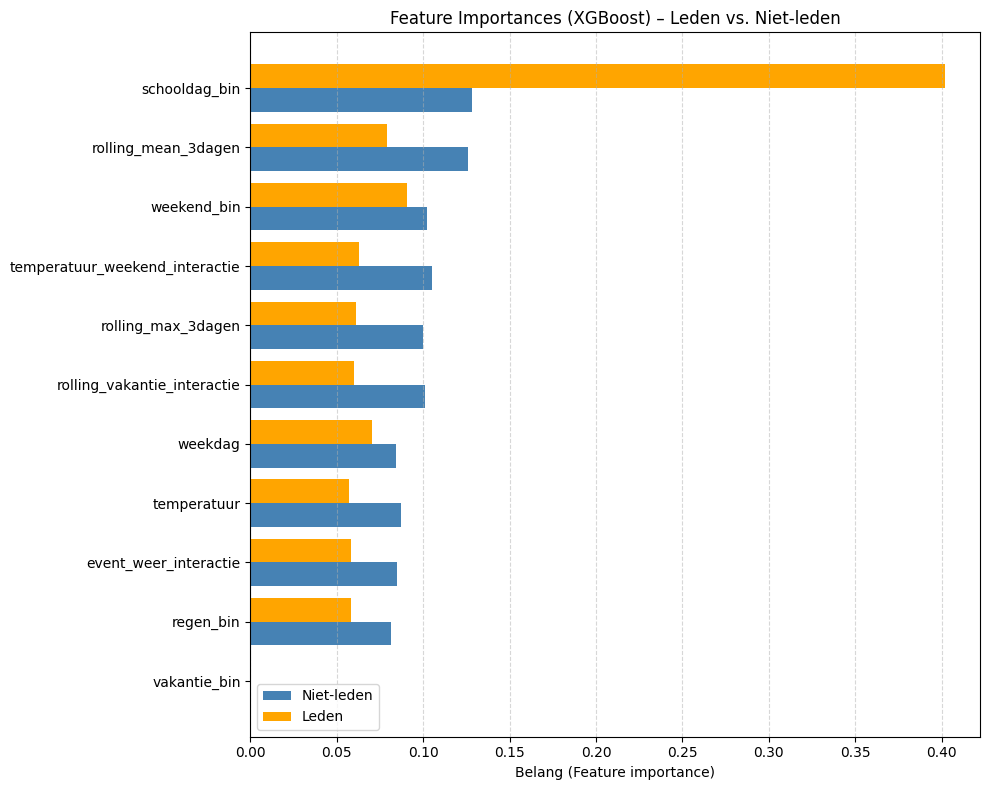

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# -----------------Feature importances ophalen -------------------
imp_tickets = pd.Series(model_tickets.feature_importances_, index=X_tickets_train.columns, name='Niet-leden')
imp_leden = pd.Series(model_leden.feature_importances_, index=X_leden_train.columns, name='Leden')

# -----------------Samenvoegen en sorteren -------------------
feat_imp_df = pd.concat([imp_tickets, imp_leden], axis=1)
feat_imp_df['avg'] = feat_imp_df.mean(axis=1)
feat_imp_df = feat_imp_df.sort_values(by='avg', ascending=True)

# -----------------Plot -------------------
plt.figure(figsize=(10, 8))
bar_width = 0.4
y = range(len(feat_imp_df))

plt.barh([i - bar_width/2 for i in y], feat_imp_df['Niet-leden'], height=bar_width, label='Niet-leden', color='steelblue')
plt.barh([i + bar_width/2 for i in y], feat_imp_df['Leden'], height=bar_width, label='Leden', color='orange')

plt.yticks(y, feat_imp_df.index)
plt.xlabel('Belang (Feature importance)')
plt.title('Feature Importances (XGBoost) – Leden vs. Niet-leden')
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


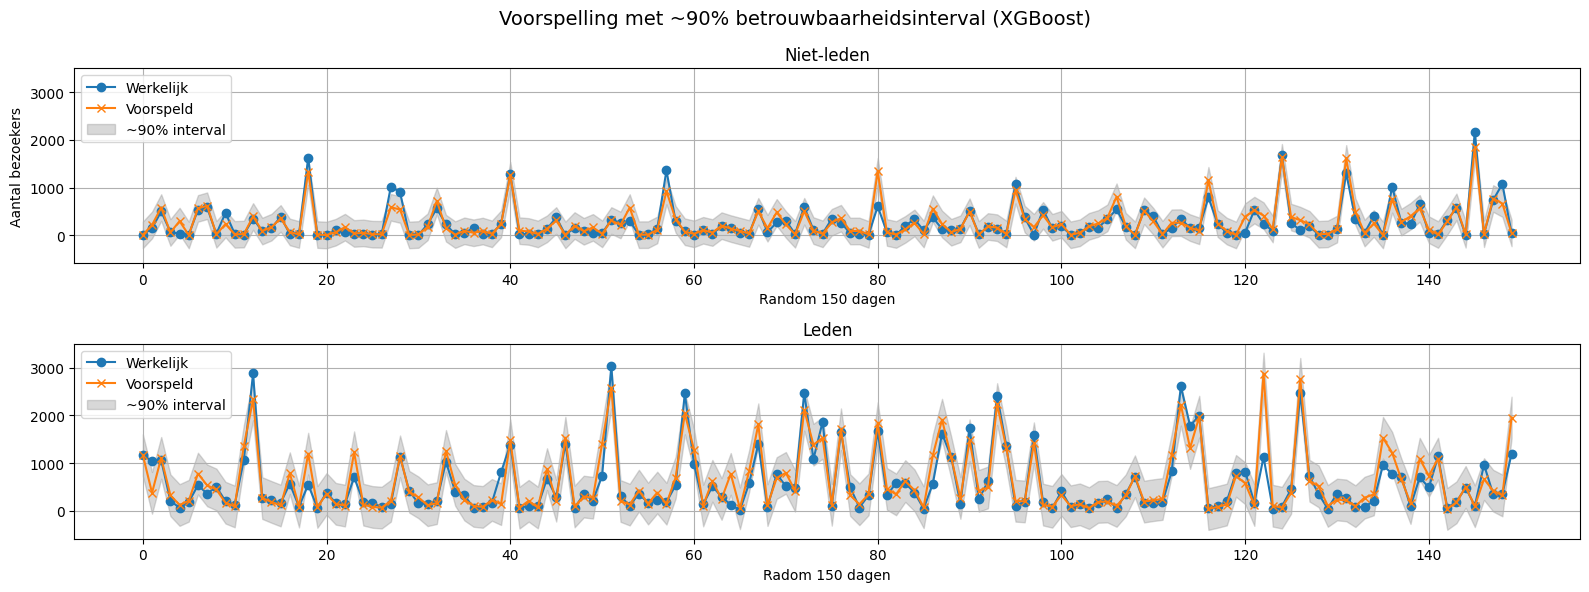

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharey=True)

# === NIET-LEDEN (tickets) ===
residuals_tickets = y_tickets_test - y_pred_tickets
res_std_tickets = residuals_tickets.std()
y_lower_tickets = y_pred_tickets - 1.64 * res_std_tickets
y_upper_tickets = y_pred_tickets + 1.64 * res_std_tickets

axes[0].plot(y_tickets_test.values[:150], label='Werkelijk', marker='o')
axes[0].plot(y_pred_tickets[:150], label='Voorspeld', marker='x')
axes[0].fill_between(range(150), y_lower_tickets[:150], y_upper_tickets[:150], color='gray', alpha=0.3, label='~90% interval')
axes[0].set_title('Niet-leden')
axes[0].set_xlabel('Random 150 dagen')
axes[0].set_ylabel('Aantal bezoekers')
axes[0].grid(True)
axes[0].legend()

# === LEDEN ===
residuals_leden = y_leden_test - y_pred_leden
res_std_leden = residuals_leden.std()
y_lower_leden = y_pred_leden - 1.64 * res_std_leden
y_upper_leden = y_pred_leden + 1.64 * res_std_leden

axes[1].plot(y_leden_test.values[:150], label='Werkelijk', marker='o')
axes[1].plot(y_pred_leden[:150], label='Voorspeld', marker='x')
axes[1].fill_between(range(150), y_lower_leden[:150], y_upper_leden[:150], color='gray', alpha=0.3, label='~90% interval')
axes[1].set_title('Leden')
axes[1].set_xlabel('Radom 150 dagen')
axes[1].grid(True)
axes[1].legend()

plt.suptitle('Voorspelling met ~90% betrouwbaarheidsinterval (XGBoost)', fontsize=14)
plt.tight_layout()
plt.show()


- **Blauwe lijn** = de **werkelijke entree**
- **Oranje lijn + kruisjes** = **voorspelling** met het model (hier: Random Forest)
- **Grijze band** = een **±90% interval** rond de voorspelling  
  → Gebaseerd op de standaarddeviatie van de fouten uit je testset vetgedrukte tekst vetgedrukte tekst


# DEEL 08: VALIDATIE

## 8.1 Laatse dagen dataset

In [ ]:
from xgboost import XGBRegressor
import pandas as pd

# === Feature selectie ===
features_leden = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

features_tickets = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

# === Functie per groep ===
def predict_last4_days(df, sample_weights, features, label=""):
    df = df.iloc[:-2].sort_values("date").reset_index(drop=True)

    test_4dagen = df.iloc[-4:]
    train_data = df.iloc[:-4]

    X_train = train_data[features].reset_index(drop=True)
    y_train = train_data["Tickettotaal"].reset_index(drop=True)
    X_test = test_4dagen[features]
    y_test = test_4dagen["Tickettotaal"]

    sample_weights = sample_weights.loc[train_data.index].reset_index(drop=True)

    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    )

    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)

    result = pd.DataFrame({
        "date": test_4dagen["date"],
        "werkelijk": y_test.values,
        "voorspeld": y_pred
    })

    print(f"📆 Laatste 4 dagen ({label}): werkelijk vs voorspeld")
    print(result.round(1), "\n")
    return result

# === Uitvoeren voor beide groepen ===
result_last4_tickets = predict_last4_days(hist_tickets_dag.copy(), sample_weights_tickets, features_tickets, label="Niet-leden")
result_last4_leden = predict_last4_days(hist_leden_dag.copy(), sample_weights_leden, features_leden, label="Leden")



📆 Laatste 4 dagen (Niet-leden): werkelijk vs voorspeld
           date  werkelijk  voorspeld
1113 2024-11-13         22  29.299999
1114 2024-11-14         23  18.799999
1115 2024-11-15         43  30.100000
1116 2024-11-16         50  70.599998 

📆 Laatste 4 dagen (Leden): werkelijk vs voorspeld
           date  werkelijk   voorspeld
1054 2024-11-14         89   59.599998
1055 2024-11-15        165  154.000000
1056 2024-11-16        206  251.199997
1057 2024-11-17        381  410.700012 



## 8.2 Random dagen

In [ ]:
from xgboost import XGBRegressor
import pandas as pd

# 📅 Kies je startdatum
jaar = 2024  #@param {type:"number"}
maand = 5    #@param {type:"number"}
dag_in_maand = 20  #@param {type:"number"}

# === Feature selectie ===
features_leden = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

features_tickets = [
    'rolling_mean_3dagen',
    'rolling_vakantie_interactie',
    'temperatuur',
    'temperatuur_weekend_interactie',
    'vakantie_bin',
    'rolling_max_3dagen',
    'weekend_bin',
    'weekdag',
    'event_weer_interactie',
    'regen_bin',
    'schooldag_bin'
]

# === Sample weight strategie ===
def gewicht_custom(x):
    return np.log1p(x)

# Bereken sample weights
sample_weights_tickets = hist_tickets_dag['Tickettotaal'].apply(gewicht_custom)
sample_weights_leden = hist_leden_dag['Tickettotaal'].apply(gewicht_custom)

# === Functie om 4-daagse voorspelling te maken vanaf een gekozen dag
def predict_4_days_from_date(df, sample_weights, features, jaar, maand, dag_in_maand, label=""):
    # Filter dagen in maand + jaar
    maand_data = df[
        (df['date'].dt.year == jaar) &
        (df['date'].dt.month == maand)
    ].sort_values('date').reset_index(drop=True)

    # Zoek dagindex
    geselecteerde_dag = maand_data[maand_data['date'].dt.day == dag_in_maand]
    if geselecteerde_dag.empty:
        raise ValueError(f"Geen data beschikbaar voor {jaar}-{maand:02}-{dag_in_maand:02}")

    start_index = geselecteerde_dag.index[0]
    if start_index > len(maand_data) - 4:
        raise ValueError("Niet genoeg dagen beschikbaar na geselecteerde dag voor een 4-daagse test")

    # Testset en trainset maken
    test_4dagen = maand_data.iloc[start_index:start_index + 4]
    train_data = df[~df['date'].isin(test_4dagen['date'])]

    X_train = train_data[features].reset_index(drop=True)
    y_train = train_data["Tickettotaal"].reset_index(drop=True)
    X_test = test_4dagen[features]
    y_test = test_4dagen["Tickettotaal"]

    sample_weights = sample_weights.loc[train_data.index].reset_index(drop=True)

    # Model trainen
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=1.0,
        objective='reg:absoluteerror',
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)

    # Resultaat
    result = pd.DataFrame({
        "date": test_4dagen["date"],
        "werkelijk": y_test.values,
        "voorspeld": y_pred
    })

    print(f"📆 Voorspelling voor 4 dagen vanaf {test_4dagen['date'].iloc[0].date()} ({label}):")
    print(result.round(1), "\n")
    return result

# === Uitvoeren voor beide groepen
result_4dagen_tickets = predict_4_days_from_date(
    hist_tickets_dag.copy(), sample_weights_tickets, features_tickets,
    jaar, maand, dag_in_maand, label="Niet-leden"
)

result_4dagen_leden = predict_4_days_from_date(
    hist_leden_dag.copy(), sample_weights_leden, features_leden,
    jaar, maand, dag_in_maand, label="Leden"
)


📆 Voorspelling voor 4 dagen vanaf 2024-05-20 (Niet-leden):
         date  werkelijk   voorspeld
19 2024-05-20        502  474.000000
20 2024-05-21        592  617.500000
21 2024-05-22         81  381.399994
22 2024-05-23        249  328.500000 

📆 Voorspelling voor 4 dagen vanaf 2024-05-20 (Leden):
         date  werkelijk    voorspeld
18 2024-05-20       1963  1519.599976
19 2024-05-21        948   527.000000
20 2024-05-22        201   537.700012
21 2024-05-23        117   265.000000 



## 8.3 Morgen

In [ ]:
#-------------------------#
# OPTIONAL: OM EEN BETER BEELD TE KRIJGEN VA NCOORELATIOES LATEN WE EXTREME EVEN BUITENBESCHOUWING
# In Ticket_toegang_park_dag Om te etsten wil ik even dat je alle kollemen verwijderd met Totaal dat hoger is dan 6000
Ticket_toegang_park_dag = Ticket_toegang_park_dag[Ticket_toegang_park_dag['Tickettotaal'] < 11000]
#Ticket_toegang_park_dag
#-------------------------#

# Find first date in Ticket_toegang_park_dag
first_date = Ticket_toegang_park_dag['date'].min()
last_date = Ticket_toegang_park_dag['date'].max()

# Filter the DataFrame based on the date range
hist_test_dag = External_hist_dta_dag[(External_hist_dta_dag['date'] >= first_date) & (External_hist_dta_dag['date'] <= last_date)]

# Merge the two DataFrames on the 'Datum	Tickets' column
hist_test_dag = pd.merge(Ticket_toegang_park_dag, hist_test_dag, on='date', how='left')

#replace Nan in feestdag with 'Geen'
hist_test_dag['feestdag'].fillna('Geen', inplace=True)

hist_test_dag

In [ ]:
External_hist_dta_dag

,date,temperatuur,maand_nr,bewolking_%,neerslag_mm,regen_bin,sneeuw_bin,mist_bin,onweer_bin,ijsvorming_bin,weertype_uur,vakantietype,verplicht_bin,vakantie_bin,weertype_dag,feestdag,feestdag_bin
0,2021-01-02,3.211111,1,100.000000,0.1075,1,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,lichte motregen,NaN,0
1,2021-01-03,3.388889,1,100.000000,0.0000,0,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,bovenlucht onzichtbaar,NaN,0
2,2021-01-04,2.911111,1,100.000000,0.1100,1,0,0,0,0,lichte motregen,Geen,Geen,0,lichte motregen,NaN,0
3,2021-01-05,2.655556,1,100.000000,0.0050,1,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,lichte motregen,NaN,0
4,2021-01-06,2.433333,1,100.000000,0.0000,0,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,bovenlucht onzichtbaar,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,2025-03-21,20.488889,3,30.444444,0.0000,0,0,0,0,0,helder,Geen,Geen,0,gedeeltelijk bewolkt,NaN,0
1540,2025-03-22,17.266667,3,97.333333,0.0000,0,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,zwaar bewolkt,NaN,0
1541,2025-03-23,15.422222,3,97.333333,0.0025,1,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,lichte motregen,NaN,0
1542,2025-03-24,14.966667,3,83.333333,0.0000,0,0,0,0,0,bovenlucht onzichtbaar,Geen,Geen,0,bewolkt,NaN,0


In [ ]:
# Filter the DataFrame based on the date range
forc_test_dag = External_forecast_dta_dag.copy()

#FEESTDAGEN
#replace Nan in feestdag with 'Geen'
forc_test_dag['feestdag'].fillna('Geen', inplace=True)

#EVENTS
# Merge evenementen met forc_test_dag
forc_test_dag = pd.merge(forc_test_dag, evenementen, on='date', how='left')
#Verwijder beschrijving
forc_test_dag = forc_test_dag.drop(columns=['beschrijving'])
# Fill NaN waardes in 'event' and 'beschrijving' met 'Geen evenement'
forc_test_dag['event'].fillna('Geen evenement', inplace=True)
# Impactniveau numeriek maken (bijv. 3 = hoog, 2 = medium, 1 = laag, 0 = geen, -1 = exclusief)
impact_dict_num = {
    "Herfstfestival": 3,
    "Heerlijk Hemelrijk Festival": 3,
    "Springspektakel": 2,
    "Oervalleidagen": 2,
    "Phoxy fanclub dag": 2,
    "Spetterspektakel": 1,
    "Piratendagen": 1,
    "Nieuwjaarsduik": 0,
    "Festyland": 0  }
forc_test_dag["event_impact_num"] = forc_test_dag["event"].map(impact_dict_num).fillna(0).astype(int)
#Nieuwe kolom event_bin (alleen middel en hoog staan op ja)
forc_test_dag["event_bin"] = forc_test_dag["event_impact_num"].apply(lambda x: 1 if x > 0 else 0)

#WEER
#weermapping
weertype_mapping = {
    "matige of zware regen met onweer": 0,
    "onweer mogelijk": 1,
    "ijzige mist": 2,
    "mist": 3,
    "kans op gladheid": 4,
    "zware sneeuwval": 5,
    "matige sneeuwval": 6,
    "lichte sneeuw": 7,
    "matige of zware regen": 8,
    "matige regen": 9,
    "lichte regen": 10,
    "lichte motregen": 11,
    "bovenlucht onzichtbaar": 12,
    "zwaar bewolkt": 13,
    "bewolkt": 14,
    "gedeeltelijk bewolkt": 15,
    "licht bewolkt": 16,
    "helder": 17
}
weertype_mapping2 = {
    "matige of zware regen met onweer": 0,
    "onweer mogelijk": 0,
    "ijzige mist": 0,
    "mist": 0,
    "kans op gladheid": 0,
    "zware sneeuwval": 0,
    "matige sneeuwval": 0,
    "lichte sneeuw": 0,
    "matige of zware regen": 0,
    "matige regen": 0,
    "lichte regen": 0,
    "lichte motregen": 0,
    "bovenlucht onzichtbaar": 0,
    "zwaar bewolkt": 0,
    "bewolkt": 1,
    "gedeeltelijk bewolkt": 1,
    "licht bewolkt": 1,
    "helder": 1
}
#3 manieren om weertype te generaliseren
forc_test_dag["weertype_dag_num"] = forc_test_dag["weertype_bepaald"].map(weertype_mapping)
forc_test_dag["weertype_uur_num"] = forc_test_dag["weertype_uur"].map(weertype_mapping)
forc_test_dag["goed/slecht_weer_bin"] = forc_test_dag["weertype_bepaald"].map(weertype_mapping2)
forc_test_dag.head()

forc_test_dag.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  4 non-null      datetime64[ns]
 1   temperatuur           4 non-null      float64       
 2   maand_nr              4 non-null      int32         
 3   bewolking_%           4 non-null      float64       
 4   neerslag_mm           4 non-null      float64       
 5   regen_bin             4 non-null      int64         
 6   sneeuw_bin            4 non-null      int64         
 7   weertype_uur          4 non-null      object        
 8   vakantietype          4 non-null      object        
 9   verplicht_bin         4 non-null      object        
 10  vakantie_bin          4 non-null      int64         
 11  weertype_bepaald      4 non-null      object        
 12  feestdag              4 non-null      object        
 13  feestdag_bin          4 

<ipython-input-118-d2de5c48a91c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  forc_test_dag['feestdag'].fillna('Geen', inplace=True)
<ipython-input-118-d2de5c48a91c>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
    'goed/slecht_weer_bin',
    'weekdag',

    'tickets_gisteren',
    'rolling_mean_3dagen',
    'rolling_max_3dagen',
    'schooldag_bin',
    'temperatuur_weekend_interactie'
]


In [ ]:
hist_test_dag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1136 entries, 2 to 1144
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            1136 non-null   datetime64[ns]
 1   Tickettotaal                    1136 non-null   int64         
 2   event                           1136 non-null   object        
 3   event_impact_num                1136 non-null   int64         
 4   event_bin                       1136 non-null   int64         
 5   temperatuur                     1136 non-null   float64       
 6   maand_nr                        1136 non-null   int32         
 7   bewolking_%                     1136 non-null   float64       
 8   neerslag_mm                     1136 non-null   float64       
 9   regen_bin                       1136 non-null   int64         
 10  sneeuw_bin                      1136 non-null   int64         
 11  mist_bin 

In [ ]:
# Vul hier even fictief alle dagen in
gister = 232  #@param {type:"number"}
eer_gister = 244  #@param {type:"number"}
eereer_gister= 533  #@param {type:"number"}
eereereer_gister = 456  #@param {type:"number"}
eereereereer_gister = 353  #@param {type:"number"}
eereereereereer_gister = 450  #@param {type:"number"}

import pandas as pd
from datetime import datetime, timedelta

# Huidige datum ophalen
vandaag = datetime.today()
dagen = [(vandaag - timedelta(days=i+1)).strftime("%A %d-%m-%Y") for i in range(6)]

# DataFrame maken
fictieve_toegang_recent = pd.DataFrame({
    "Dag": dagen,
    "Waarde": [gister, eer_gister, eereer_gister, eereereer_gister, eereereereer_gister,eereereereereer_gister]
})

# DataFrame weergeven
fictieve_toegang_recent['date'] = pd.to_datetime(fictieve_toegang_recent['Dag'])
fictieve_toegang_recent = fictieve_toegang_recent.drop(columns=['Dag'])
fictieve_toegang_recent = fictieve_toegang_recent.sort_values('date')

# Eerst berekenen op fictieve_toegang_recent
fictieve_toegang_recent['tickets_gisteren'] = fictieve_toegang_recent['Waarde'].shift(1)
fictieve_toegang_recent['rolling_mean_3dagen'] = fictieve_toegang_recent['Waarde'].rolling(window=3).mean()
fictieve_toegang_recent['rolling_max_3dagen'] = fictieve_toegang_recent['Waarde'].shift(1).rolling(window=3).max()

fictieve_toegang_recent


<ipython-input-136-5c1bec737145>:23: UserWarning: Parsing dates in %A %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fictieve_toegang_recent['date'] = pd.to_datetime(fictieve_toegang_recent['Dag'])


,Waarde,date,tickets_gisteren,rolling_mean_3dagen,rolling_max_3dagen
5,450,2025-03-21,NaN,NaN,NaN
4,353,2025-03-22,450.0,NaN,NaN
3,456,2025-03-23,353.0,419.666667,NaN
2,533,2025-03-24,456.0,447.333333,456.0
1,244,2025-03-25,533.0,411.000000,533.0
0,232,2025-03-26,244.0,336.333333,533.0


In [ ]:
hist_test_dag

,date,Tickettotaal,event,event_impact_num,event_bin,temperatuur,maand_nr,bewolking_%,neerslag_mm,regen_bin,...,tickets_gisteren,rolling_mean_3dagen,rolling_max_3dagen,weekend_bin,vakantietype_bin,vakantie_en_goed_weer,event_weer_interactie,temperatuur_weekend_interactie,rolling_vakantie_interactie,schooldag_bin
2,2021-08-11,14,Geen evenement,0,0,22.722222,8,34.666667,0.0000,0,...,32.0,17.333333,NaN,0,1,1,0,0.000000,17.333333,0
3,2021-08-12,14,Geen evenement,0,0,24.411111,8,95.888889,0.0000,0,...,14.0,20.000000,32.0,0,1,0,0,0.000000,20.000000,0
4,2021-08-13,11,Geen evenement,0,0,21.622222,8,100.000000,0.0000,0,...,14.0,13.000000,32.0,0,1,0,0,0.000000,13.000000,0
5,2021-08-14,15,Geen evenement,0,0,22.455556,8,41.444444,0.0000,0,...,11.0,13.333333,14.0,1,1,1,0,22.455556,13.333333,0
6,2021-08-15,14,Geen evenement,0,0,25.877778,8,90.444444,0.0000,0,...,15.0,13.333333,15.0,1,1,0,0,25.877778,13.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,2024-11-16,208,Geen evenement,0,0,7.933333,11,100.000000,0.0000,0,...,168.0,157.000000,168.0,1,0,0,0,7.933333,0.000000,0
1141,2024-11-17,357,Geen evenement,0,0,8.044444,11,82.111111,0.5000,1,...,208.0,244.333333,208.0,1,0,0,0,8.044444,0.000000,0
1142,2024-11-18,118,Geen evenement,0,0,5.966667,11,95.888889,0.0000,0,...,357.0,227.666667,357.0,0,0,0,0,0.000000,0.000000,1
1143,2024-11-19,1,Geen evenement,0,0,3.388889,11,100.000000,3.6075,1,...,118.0,158.666667,357.0,0,0,0,0,0.000000,0.000000,1


In [ ]:
# Vervolgens de laatste bekende waarde gebruiken om forc_test_dag aan te vullen
forc_test_dag['tickets_gisteren'] = fictieve_toegang_recent['tickets_gisteren'].iloc[-1]
forc_test_dag['rolling_mean_3dagen'] = fictieve_toegang_recent['rolling_mean_3dagen'].iloc[-1]
forc_test_dag['rolling_max_3dagen'] = fictieve_toegang_recent['rolling_max_3dagen'].iloc[-1]


In [ ]:
forc_test_dag

,date,temperatuur,maand_nr,bewolking_%,neerslag_mm,regen_bin,sneeuw_bin,weertype_uur,vakantietype,verplicht_bin,...,feestdag_bin,event,event_impact_num,event_bin,weertype_dag_num,weertype_uur_num,goed/slecht_weer_bin,tickets_gisteren,rolling_mean_3dagen,rolling_max_3dagen
0,2025-03-27,13.677778,3,3.444444,0.00,0,0,licht bewolkt,Geen,Geen,...,0,Geen evenement,0,0,16,16,1,244.0,336.333333,533.0
1,2025-03-28,14.944444,3,16.111111,0.07,1,0,helder,Geen,Geen,...,0,Geen evenement,0,0,11,17,0,244.0,336.333333,533.0
2,2025-03-29,10.744444,3,86.111111,0.13,1,0,bovenlucht onzichtbaar,Geen,Geen,...,0,Geen evenement,0,0,11,12,0,244.0,336.333333,533.0
3,2025-03-30,9.755556,3,88.777778,0.56,1,0,lichte motregen,Geen,Geen,...,0,Geen evenement,0,0,10,11,0,244.0,336.333333,533.0


In [ ]:


# Bereken nieuwe variabelen op de gecombineerde set
forc_test_dag['tickets_gisteren'] = fictieve_toegang_recent['Waarde'].shift(1)
forc_test_dag['rolling_mean_3dagen'] = fictieve_toegang_recent['Waarde'].rolling(window=3).mean()
forc_test_dag['rolling_max_3dagen'] = fictieve_toegang_recent['Waarde'].shift(1).rolling(window=3).max()

# Stap 3: Knip alleen het voorspeldeel eruit (forc_test_dag)
forc_test_dag = combined.loc[combined['Dag'] > fictieve_toegang_recent['Dag'].max()].copy()

# (optioneel: kolomnamen en volgorde aanpassen aan wat het model verwacht)


NameError: name 'combined' is not defined

In [ ]:
hist_test_dag